### imports, directories, load data

In [1]:
figDataSaveDir = r"C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data"
dryadDir = r"C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\dryad"


In [2]:
# general imports
import os
import pickle
import numpy as np
import sys
import pdb
import pandas as pd
import csv
import copy

# plotting imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import transforms
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

# signal imports
import numpy as np
import scipy.signal
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from random import randint

# ML imports
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# custom imports
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)  # Add the parent directory to the path
import assemblies  # Import your module located one directory up
from assemblies import *
from general_utils import generate_labels_from_cv_filtered_npx, significant_modulation_proportion
from scipy.stats import ttest_rel, ttest_ind

In [4]:
def load_session_data(base_directory):
    """
    Load session data from all pickle files in the specified directory.

    Parameters:
    -----------
    base_directory : str
        Path to directory containing the pickle files

    Returns:
    --------
    dict
        Nested dictionary with experiment day and animal ID as keys
    """
    # Initialize the main data dictionary
    data = {}

    # Iterate over all files in the directory
    for filename in os.listdir(base_directory):
        if filename.endswith('_day2_final.pkl'):
            # Extract day and animal ID from filename
            animal_id = filename.split('_')[0]
            day = filename.split('_')[1]

            # Load the pickle file
            file_path = os.path.join(base_directory, filename)
            with open(file_path, 'rb') as f:
                session_data = pickle.load(f)

            # Create nested dictionary structure
            if day not in data:
                data[day] = {}
            data[day][animal_id] = session_data

            print(f"Loaded data for animal {animal_id} on {day}")
    
    if not data:
        print(f"No matching pickle files found in {base_directory}")

    return data


group_data = load_session_data(dryadDir + "/ephys")

Loaded data for animal 7632 on day2
Loaded data for animal 7762 on day2
Loaded data for animal 7763 on day2
Loaded data for animal 7772 on day2
Loaded data for animal 7816 on day2
Loaded data for animal 7917 on day2
Loaded data for animal 7918 on day2


Saved plot as PNG: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\snippet_example.png
Saved plot as SVG: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\snippet_example.svg
Saved timeseries data as CSV: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\snippet_timeseries.csv
Saved spike data as CSV: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\snippet_spikes.csv


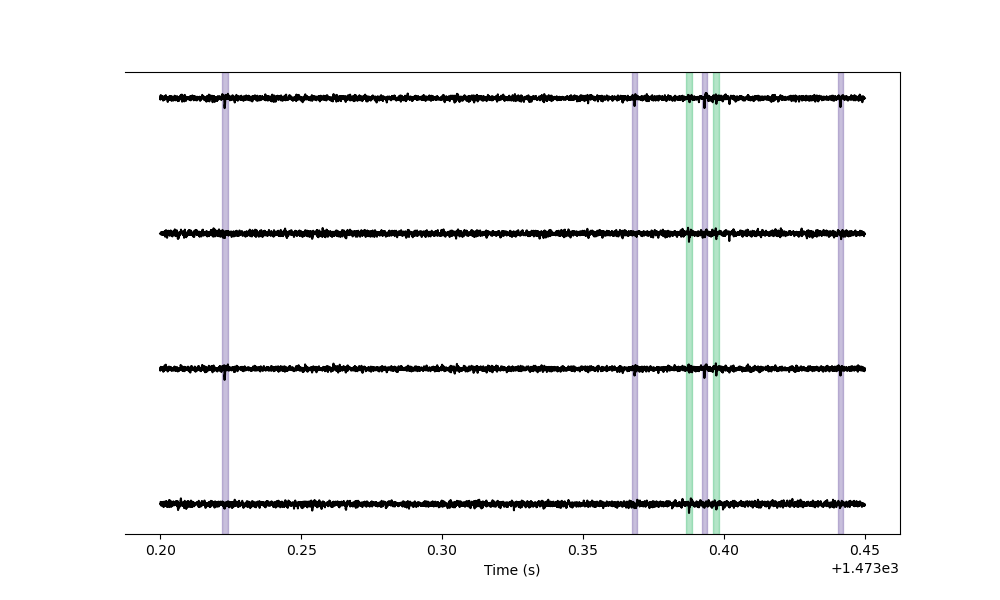

In [38]:
def load_and_plot_snippet(pickle_file, output_dir, plot_shading=True, scale_factor=500):
    """
    Load and plot imec data from a pickle file with optional spike shading and adjustable trace scaling.
    Saves plot as PNG, SVG, and outputs a CSV with timeseries data including spike timing information.
    
    Parameters:
    -----------
    pickle_file : str
        Path to the pickle file containing the data.
    output_dir : str
        Directory to save the outputs (PNG, SVG, CSV).
    plot_shading : bool
        Whether to overlay spike shading.
    scale_factor : int
        Vertical scaling factor for trace separation.
    """
    # Load data from pickle
    with open(pickle_file, 'rb') as f:
        plot_data = pickle.load(f)
    time_axis = plot_data['time_axis']
    data = plot_data['data']
    channels = plot_data['channels']
    spikes = plot_data['spikes']
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, ch_data in enumerate(data.T):
        ax.plot(time_axis, ch_data + i * scale_factor, color='black')
    
    # Create spike timing arrays for CSV export
    spike_times = []
    spike_types = []
    if spikes:
        for spike in spikes:
            if time_axis[0] <= spike['time'] <= time_axis[-1]:
                spike_times.append(spike['time'])
                spike_types.append(spike['type'])
                
                if plot_shading:
                    color = '#4B2E8D' if spike['type'] == 'FSI' else '#07AC4B'
                    ax.axvspan(spike['time'] - 0.001, spike['time'] + 0.001, 
                             color=color, alpha=0.3, ymin=0, ymax=1)
    
    ax.set_xlabel('Time (s)')
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    
    # Save plots
    os.makedirs(output_dir, exist_ok=True)
    png_path = os.path.join(output_dir, 'snippet_example.png')
    svg_path = os.path.join(output_dir, 'snippet_example.svg')
    plt.savefig(png_path, format='png', dpi=300)
    plt.savefig(svg_path, format='svg')
    
    # Create and save enhanced CSV with spike information
    df = pd.DataFrame(data, columns=[f'Channel_{ch}' for ch in channels])
    df['Time'] = time_axis
    
    # Create a separate DataFrame for spike information
    spike_df = pd.DataFrame({
        'Spike_Time': spike_times,
        'Spike_Type': spike_types
    })
    
    # Save both DataFrames to separate CSV files
    timeseries_path = os.path.join(output_dir, 'snippet_timeseries.csv')
    spikes_path = os.path.join(output_dir, 'snippet_spikes.csv')
    
    df.to_csv(timeseries_path, index=False)
    spike_df.to_csv(spikes_path, index=False)
    
    print(f"Saved plot as PNG: {png_path}")
    print(f"Saved plot as SVG: {svg_path}")
    print(f"Saved timeseries data as CSV: {timeseries_path}")
    print(f"Saved spike data as CSV: {spikes_path}")

# Usage example
pickle_snippet = dryadDir + "\ephys_snippet.pkl"
load_and_plot_snippet(pickle_snippet, figDataSaveDir + '/ephys', scale_factor=500)

### extracting rates

In [6]:
def analyze_rates_all_animals(group_data, bin_size_seconds=0.05, smooth_sigma=2, cell_type='FSI', plot=True):
   """
   Analyze and optionally plot firing rates and behavior for all animals
   
   Parameters
   ----------
   group_data : dict
       Nested dictionary containing recording data for each day/animal
   bin_size_seconds : float
       Size of time bins for rate calculation
   smooth_sigma : float
       Standard deviation for Gaussian smoothing of rates
   cell_type : str
       Cell type to analyze (e.g., 'FSI')
   plot : bool
       Whether to create plots for each animal
   
   Returns
   --------
   rate_data : dict
       Nested dictionary containing for each day/animal:
       - normalized_rates : normalized rate matrix for each neuron
       - raw_rates : raw firing rates for each neuron
       - time_bins : time points for the rates
       - cell_ids : cluster IDs of included neurons
       - cell_channels : recording channel for each neuron
       - cell_depths : probe depth for each neuron
       - behavior_events : dict with partner and novel side entry/exit times
       - max_firing_rates : maximum rate for each neuron
   """
   rate_data = {}
   
   for day, animals in group_data.items():
       rate_data[day] = {}
       
       for animal_id, session_data in animals.items():
           print(f"Processing {animal_id} on {day}")
           
           # Extract data
           spike_times = session_data['spike_times']
           spike_clusters = session_data['spike_clusters']
           validated_clusters = session_data['validated_clusters']
           curated_clusters = session_data['curated_clusters']
           recording_time = session_data['recording_time']
           cv = session_data.get('cv', None)  # Allow cv to be missing
           
           # Filter for cell type
           cell_clusters = validated_clusters[validated_clusters['Classification'] == cell_type]
           
           if len(cell_clusters) == 0:
               print(f"No {cell_type} cells found for {animal_id}")
               continue
               
           # Create time bins
           n_bins = int(np.ceil(recording_time / bin_size_seconds))
           time_bins = np.linspace(0, recording_time, n_bins + 1)
           
           # Initialize arrays
           rate_matrix = np.zeros((len(cell_clusters), n_bins))
           normalized_rate_matrix = np.zeros((len(cell_clusters), n_bins))
           max_firing_rates = []
           cell_channels = []
           cell_depths = []
           
           for i, (_, cluster_row) in enumerate(cell_clusters.iterrows()):
               cluster_id = cluster_row['ClusterID']
               
               # Get channel and depth info
               curated_info = curated_clusters[curated_clusters['cluster_id'] == cluster_id]
               channel = curated_info['ch'].values[0]
               depth = curated_info['depth'].values[0]
               cell_channels.append(channel)
               cell_depths.append(depth)
               
               # Calculate rates
               cluster_spikes = spike_times[spike_clusters == cluster_id] / 30000
               hist, _ = np.histogram(cluster_spikes, bins=time_bins)
               rates = hist / bin_size_seconds
               if smooth_sigma > 0:
                   rates = gaussian_filter1d(rates, smooth_sigma)
               
               rate_matrix[i] = rates
               max_firing_rates.append(np.max(rates))
               
               # Normalize
               min_rate = np.min(rates)
               max_rate = np.max(rates)
               if max_rate > min_rate:
                   normalized_rates = (rates - min_rate) / (max_rate - min_rate)
               else:
                   normalized_rates = np.zeros_like(rates)
               normalized_rate_matrix[i] = normalized_rates
           
           # Initialize behavior_events as empty if cv is missing
           behavior_events = {'partner': [], 'novel': []}
           
           if cv is not None:
               # Extract behavior events if cv data is available
               side_info = session_data.get('partner_side', '')
               
               if side_info:
                   # Partner events
                   partner_events = cv[cv['EventType'] == f'Area:Mouse 1 Center In {side_info} chamber']
                   for _, event in partner_events.iterrows():
                       behavior_events['partner'].append({
                           'start': event['indexStart'] / 30000,
                           'end': event['indexEnd'] / 30000
                       })
                   
                   # Novel events
                   opposite_side = 'right' if side_info == 'left' else 'left'
                   novel_events = cv[cv['EventType'] == f'Area:Mouse 1 Center In {opposite_side} chamber']
                   for _, event in novel_events.iterrows():
                       behavior_events['novel'].append({
                           'start': event['indexStart'] / 30000,
                           'end': event['indexEnd'] / 30000
                       })

           # Store data
           rate_data[day][animal_id] = {
               'normalized_rates': normalized_rate_matrix,
               'raw_rates': rate_matrix,
               'time_bins': time_bins[:-1],  # exclude last bin edge
               'cell_ids': cell_clusters['ClusterID'].values,
               'cell_channels': np.array(cell_channels),
               'cell_depths': np.array(cell_depths),
               'behavior_events': behavior_events,
               'max_firing_rates': max_firing_rates
           }
           
           # Optional plotting
           if plot:
               fig, (ax_behavior, ax_rates) = plt.subplots(2, 1, figsize=(10,5), 
                                                         gridspec_kw={'height_ratios': [1, 4]},
                                                         sharex=True)
               
               # Plot behavior if cv data is available
               if cv is not None:
                   ax_behavior.set_ylim(0, 1)
                   for event in behavior_events['partner']:
                       ax_behavior.axvspan(event['start'], event['end'], 
                                         color='green', alpha=0.5)
                   for event in behavior_events['novel']:
                       ax_behavior.axvspan(event['start'], event['end'], 
                                         color='purple', alpha=0.5)
                   
                   ax_behavior.set_title(f'{cell_type} Activity and Behavior - {animal_id} {day}')
                   ax_behavior.set_ylabel('Location')
                   ax_behavior.set_yticks([])
                   
                   ax_behavior.legend([
                       plt.Rectangle((0,0),1,1, facecolor='green', alpha=0.5),
                       plt.Rectangle((0,0),1,1, facecolor='purple', alpha=0.5)
                   ], ['Partner Side', 'Novel Side'], loc='upper right')
               
               # Plot rates
               im = ax_rates.imshow(normalized_rate_matrix, 
                                  aspect='auto', 
                                  extent=[0, recording_time, -0.5, len(cell_clusters)-0.5],
                                  origin='lower',
                                  cmap='magma')
               
               ax_rates.set_xlabel('Time (seconds)')
               ax_rates.set_ylabel(f'{cell_type} Neuron')
               
               ytick_labels = [f"ID: {cid} (ch:{ch}, {rate:.1f} Hz)" 
                             for cid, ch, rate in zip(cell_clusters['ClusterID'], 
                                                    cell_channels,
                                                    max_firing_rates)]
               ax_rates.set_yticks(range(len(cell_clusters)))
               ax_rates.set_yticklabels(ytick_labels)
               
               plt.tight_layout()
               plt.show()
   
   return rate_data

In [7]:
# Get rate data for all animals
rate_data = analyze_rates_all_animals(group_data, 
                                    bin_size_seconds=0.05, 
                                    smooth_sigma=2,
                                    cell_type='FSI',
                                    plot=False)

Processing 7632 on day2
Processing 7762 on day2
Processing 7763 on day2
Processing 7772 on day2
Processing 7816 on day2
Processing 7917 on day2
Processing 7918 on day2


### crosscorrelograms

In [11]:
def plot_pair_ccg(group_data, day, animal_id, fsi_id, msn_id, ax=None, 
                  bin_size_ms=1, exclude_window_ms=1, save_dir=None):
    """Plot CCG for a single FSI-MSN pair and save the plot and data."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    session_data = group_data[day][animal_id]
    spike_times = session_data['spike_times']
    spike_clusters = session_data['spike_clusters']
    
    fsi_spikes = spike_times[spike_clusters == fsi_id] / 30000
    msn_spikes = spike_times[spike_clusters == msn_id] / 30000
    
    # Compute CCG
    ccg, bins = compute_ccg(fsi_spikes, msn_spikes, bin_size_ms=bin_size_ms)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting

    # Generate surrogate CCGs
    surrogate_ccgs = generate_surrogate_ccgs(fsi_spikes, msn_spikes, bin_size_ms=bin_size_ms)
    
    # Analyze significance
    connection_type, percentile_999, percentile_001 = analyze_ccg_significance(
        ccg, surrogate_ccgs, bin_size_ms=bin_size_ms, exclude_window_ms=exclude_window_ms)
    
    # Mask out data within the exclude window
    exclude_mask = (bin_centers >= -exclude_window_ms) & (bin_centers <= exclude_window_ms)
    plot_mask = ~exclude_mask & (bin_centers >= -20) & (bin_centers <= 20)
    
    # Convert to float to allow NaNs
    ccg_with_nan = ccg.astype(float)
    percentile_999_with_nan = percentile_999.astype(float)
    percentile_001_with_nan = percentile_001.astype(float)
    
    # Replace excluded bins with NaN
    ccg_with_nan[exclude_mask] = np.nan
    percentile_999_with_nan[exclude_mask] = np.nan
    percentile_001_with_nan[exclude_mask] = np.nan
    
    # Plot (excluding bars within the exclude window)
    ax.bar(bin_centers[plot_mask], ccg[plot_mask], 
           width=bin_size_ms, color='black')  # Bars are always black
    
    # Plot significance thresholds
    ax.plot(bin_centers[plot_mask], percentile_999[plot_mask], 
            color='red', linestyle='--', label='99.9th percentile')  # Red thresholds
    ax.plot(bin_centers[plot_mask], percentile_001[plot_mask], 
            color='red', linestyle='--', label='0.1th percentile')  # Red thresholds
    
    # Mark excluded region with a vertical gray shaded area
    ax.axvspan(-exclude_window_ms, exclude_window_ms, 
               color='gray', alpha=0.5, label='Excluded')

    ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    
    title = f'FSI {fsi_id} - MSN {msn_id} CCG\n{connection_type}'
    ax.set_title(title)
    
    ax.set_xlabel('Time lag (ms)')
    ax.set_ylabel('Count')

    plt.tight_layout()

    # Save the plot if save_dir is specified
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        base_filename = os.path.join(save_dir, f'{animal_id}_FSI{fsi_id}_MSN{msn_id}_CCG')
        plt.savefig(f"{base_filename}.png", dpi=300)
        plt.savefig(f"{base_filename}.svg")
        print(f"Plot saved to {base_filename}.png and {base_filename}.svg")
        
        # Save CCG data to CSV
        csv_data = pd.DataFrame({
            'Bin_Centers': bin_centers,
            'CCG': ccg_with_nan,
            'Percentile_999': percentile_999_with_nan,
            'Percentile_001': percentile_001_with_nan
        })
        csv_filename = f"{base_filename}.csv"
        csv_data.to_csv(csv_filename, index=False)
        print(f"CCG data saved to {csv_filename}")
    
    # Only show the plot if not part of an existing figure
    if ax is None:
        plt.show()
    
    # Return the CCG and bins for further analysis
    return ccg, bins




def plot_fsi_group_ccg(group_data, day, animal_id, fsi_id, valid_pairs, ax=None,
                       bin_size_ms=1, exclude_window_ms=1, save_dir=None):
    """Plot group CCG for one FSI with all its nearby MSNs and save the plot."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    session_data = group_data[day][animal_id]
    spike_times = session_data['spike_times']
    spike_clusters = session_data['spike_clusters']
    
    fsi_spikes = spike_times[spike_clusters == fsi_id] / 30000
    
    # Compute CCGs for all pairs involving this specific FSI
    all_ccgs = []
    bins = None
    fsi_pairs = [p for p in valid_pairs if p['fsi_id'] == fsi_id]
    
    for pair in fsi_pairs:
        msn_spikes = spike_times[spike_clusters == pair['msn_id']] / 30000
        ccg, bins = compute_ccg(fsi_spikes, msn_spikes, bin_size_ms=bin_size_ms)
        all_ccgs.append(ccg)
    
    mean_ccg = np.mean(all_ccgs, axis=0)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting

    # Generate surrogate CCGs for this specific FSI
    all_surrogate_ccgs = []
    for pair in fsi_pairs:
        msn_spikes = spike_times[spike_clusters == pair['msn_id']] / 30000
        surrogate_ccgs = generate_surrogate_ccgs(fsi_spikes, msn_spikes, 
                                                 bin_size_ms=bin_size_ms)
        all_surrogate_ccgs.append(surrogate_ccgs)
    
    mean_surrogate_ccgs = np.mean(all_surrogate_ccgs, axis=0)
    
    # Analyze significance for this specific FSI
    connection_type, percentile_999, percentile_001 = analyze_ccg_significance(
        mean_ccg, mean_surrogate_ccgs, 
        bin_size_ms=bin_size_ms, exclude_window_ms=exclude_window_ms)
    
    # Mask out data within the exclude window
    exclude_mask = (bin_centers >= -exclude_window_ms) & (bin_centers <= exclude_window_ms)
    plot_mask = ~exclude_mask & (bin_centers >= -20) & (bin_centers <= 20)
    
    # Plot for the specific FSI
    ax.bar(bin_centers[plot_mask], mean_ccg[plot_mask], 
           width=bin_size_ms, color='black')  # Bars are always black
    
    ax.plot(bin_centers[plot_mask], percentile_999[plot_mask], 
            color='red', linestyle='--', label='99.9th percentile')  # Red thresholds
    ax.plot(bin_centers[plot_mask], percentile_001[plot_mask], 
            color='red', linestyle='--', label='0.1th percentile')  # Red thresholds
    
    # Mark excluded region with a vertical gray shaded area
    ax.axvspan(-exclude_window_ms, exclude_window_ms, 
               color='gray', alpha=0.5, label='Excluded')
    
    ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    
    title = f'FSI {fsi_id} - Group CCG (n={len(fsi_pairs)} MSNs)\n{connection_type}'
    ax.set_title(title)
    
    ax.set_xlabel('Time lag (ms)')
    ax.set_ylabel('Average count')

    plt.tight_layout()

    # Save the plot if save_dir is specified
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = os.path.join(save_dir, f'{animal_id}_FSI{fsi_id}_group_CCG')
        plt.savefig(f"{filename}.png", dpi=300)
        plt.savefig(f"{filename}.svg")
        print(f"Plot saved to {filename}.png and {filename}.svg")
    
    # Only show the plot if not part of an existing figure
    if ax is None:
        plt.show()


def plot_all_fsi_msn_pairs_ccg(group_data, day, animal_id, valid_pairs, ax=None,
                               bin_size_ms=1, exclude_window_ms=1, save_dir=None):
    """Plot a single CCG for all FSI-MSN pairs across different FSIs."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    if not valid_pairs:
        print(f"No valid FSI-MSN pairs found for {animal_id} on {day}. Skipping all-pairs plot.")
        return None

    session_data = group_data[day][animal_id]
    spike_times = session_data['spike_times']
    spike_clusters = session_data['spike_clusters']
    
    # Compute CCGs for all FSI-MSN pairs
    all_ccgs = []
    bins = None
    
    for pair in valid_pairs:
        fsi_spikes = spike_times[spike_clusters == pair['fsi_id']] / 30000
        msn_spikes = spike_times[spike_clusters == pair['msn_id']] / 30000
        ccg, bins = compute_ccg(fsi_spikes, msn_spikes, bin_size_ms=bin_size_ms)
        all_ccgs.append(ccg)
    
    if not all_ccgs:
        print(f"No valid CCGs computed for {animal_id} on {day}. Skipping all-pairs plot.")
        return None

    mean_ccg = np.mean(all_ccgs, axis=0) if len(all_ccgs) > 1 else all_ccgs[0]
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting

    # Generate surrogate CCGs for all pairs
    all_surrogate_ccgs = []
    for pair in valid_pairs:
        fsi_spikes = spike_times[spike_clusters == pair['fsi_id']] / 30000
        msn_spikes = spike_times[spike_clusters == pair['msn_id']] / 30000
        surrogate_ccgs = generate_surrogate_ccgs(fsi_spikes, msn_spikes, 
                                                 bin_size_ms=bin_size_ms)
        all_surrogate_ccgs.append(surrogate_ccgs)
    
    if not all_surrogate_ccgs:
        print(f"No surrogate CCGs generated for {animal_id} on {day}. Skipping all-pairs plot.")
        return None

    mean_surrogate_ccgs = np.mean(all_surrogate_ccgs, axis=0)
    
    # Analyze significance for all pairs combined
    connection_type, percentile_999, percentile_001 = analyze_ccg_significance(
        mean_ccg, mean_surrogate_ccgs, 
        bin_size_ms=bin_size_ms, exclude_window_ms=exclude_window_ms)
    
    # Mask out data within the exclude window
    exclude_mask = (bin_centers >= -exclude_window_ms) & (bin_centers <= exclude_window_ms)
    plot_mask = ~exclude_mask & (bin_centers >= -20) & (bin_centers <= 20)
    
    # Plot the combined CCG
    ax.bar(bin_centers[plot_mask], mean_ccg[plot_mask], 
           width=bin_size_ms, color='black')  # Bars are always black
    
    ax.plot(bin_centers[plot_mask], percentile_999[plot_mask], 
            color='red', linestyle='--', label='99.9th percentile')  # Red thresholds
    ax.plot(bin_centers[plot_mask], percentile_001[plot_mask], 
            color='red', linestyle='--', label='0.1th percentile')  # Red thresholds
    
    # Mark excluded region with a vertical gray shaded area
    ax.axvspan(-exclude_window_ms, exclude_window_ms, 
               color='gray', alpha=0.5, label='Excluded')
    
    ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    
    title = f'All FSI-MSN Pairs - Group CCG (n={len(valid_pairs)} pairs)\n{connection_type}'
    ax.set_title(title)
    
    ax.set_xlabel('Time lag (ms)')
    ax.set_ylabel('Average count')
    ax.legend(fontsize='small')

    plt.tight_layout()

    # Save the plot if save_dir is specified
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = os.path.join(save_dir, f'{animal_id}_all_FSI_MSN_pairs_CCG')
        plt.savefig(f"{filename}.png", dpi=300)
        plt.savefig(f"{filename}.svg")
        print(f"Plot saved to {filename}.png and {filename}.svg")
    
    # Only show the plot if not part of an existing figure
    if ax is None:
        plt.show()



def find_valid_pairs(group_data, day, animal_id, max_distance=100):
    """
    Find valid FSI-MSN pairs based on proximity and classification.
    
    Parameters:
    -----------
    group_data : dict
        The nested data structure containing session info.
    day : str
        Day to analyze.
    animal_id : str
        Animal ID to analyze.
    max_distance : float
        Maximum distance in μm between pairs (default: 100).
        
    Returns:
    --------
    list of dicts
        Each dict contains info about a valid pair:
        {
            'fsi_id': int,
            'msn_id': int,
            'fsi_depth': float,
            'msn_depth': float,
            'distance': float,
            'shank': int
        }
    """
    session_data = group_data[day][animal_id]
    validated_clusters = session_data['validated_clusters']
    curated_clusters = session_data['curated_clusters']
    
    # Get FSIs and MSNs
    fsi_clusters = validated_clusters[validated_clusters['Classification'] == 'FSI']
    msn_clusters = validated_clusters[validated_clusters['Classification'] == 'MSN']
    
    valid_pairs = []
    
    for _, fsi in fsi_clusters.iterrows():
        fsi_id = fsi['ClusterID']
        fsi_info = curated_clusters[curated_clusters['cluster_id'] == fsi_id].iloc[0]
        fsi_depth = fsi_info['depth']
        fsi_shank = fsi_info['shank']
        
        # Find MSNs on same shank within distance
        for _, msn in msn_clusters.iterrows():
            msn_id = msn['ClusterID']
            msn_info = curated_clusters[curated_clusters['cluster_id'] == msn_id].iloc[0]
            
            if msn_info['shank'] == fsi_shank:
                distance = abs(msn_info['depth'] - fsi_depth)
                if distance <= max_distance:
                    valid_pairs.append({
                        'fsi_id': fsi_id,
                        'msn_id': msn_id,
                        'fsi_depth': fsi_depth,
                        'msn_depth': msn_info['depth'],
                        'distance': distance,
                        'shank': fsi_shank
                    })
    
    return valid_pairs


def compute_ccg(spike_times1, spike_times2, bin_size_ms=0.5, window_size_ms=100):
    """
    Compute basic CCG including all spikes with symmetric bins centered around 0.
    """
    st1_ms = spike_times1 * 1000  # Convert to milliseconds
    st2_ms = spike_times2 * 1000  # Convert to milliseconds
    
    # Create symmetric bins centered around 0
    bins = np.arange(-window_size_ms / 2, window_size_ms / 2 + bin_size_ms, bin_size_ms)
    if len(bins) % 2 == 0:  # Ensure an odd number of bins for symmetry around 0
        bins = np.append(bins, bins[-1] + bin_size_ms)
    
    # Collect all differences
    differences = []
    for t1 in st1_ms:
        diffs = st2_ms - t1
        mask = np.abs(diffs) <= window_size_ms / 2  # Only keep differences within the window
        differences.extend(diffs[mask])
    
    counts, bin_edges = np.histogram(differences, bins=bins)
    
    return counts, bin_edges

def compute_ccg_with_shift(spike_times1, spike_times2, bin_size_ms=0.5, window_size_ms=100, shift_ms=100):
    """
    Compute CCG including shift predictor correction.
    Returns both raw and shift-corrected CCGs.
    """
    st1_ms = spike_times1 * 1000  # Convert to milliseconds
    st2_ms = spike_times2 * 1000  # Convert to milliseconds
    
    # Create symmetric bins centered around 0
    bins = np.arange(-window_size_ms / 2, window_size_ms / 2 + bin_size_ms, bin_size_ms)
    if len(bins) % 2 == 0:  # Ensure odd number of bins for symmetry around 0
        bins = np.append(bins, bins[-1] + bin_size_ms)
    
    # Compute original CCG
    differences = []
    for t1 in st1_ms:
        diffs = st2_ms - t1
        mask = np.abs(diffs) <= window_size_ms / 2
        differences.extend(diffs[mask])
    
    raw_ccg, bin_edges = np.histogram(differences, bins=bins)
    
    # Compute shifted CCG
    shifted_st2_ms = st2_ms + shift_ms
    shifted_differences = []  # New list for shifted differences
    for t1 in st1_ms:
        diffs = shifted_st2_ms - t1
        mask = np.abs(diffs) <= window_size_ms / 2
        shifted_differences.extend(diffs[mask])  # Use shifted_differences instead
    
    shifted_ccg, _ = np.histogram(shifted_differences, bins=bins)
    
    # Compute shift-corrected CCG
    corrected_ccg = raw_ccg - shifted_ccg
    
    return raw_ccg, shifted_ccg, corrected_ccg, bin_edges

def generate_surrogate_ccgs(spike_times1, spike_times2, bin_size_ms=1, n_surrogates=1000):
    """
    Generate surrogate CCGs using ±50ms jittering, including all spikes
    """
    surrogate_ccgs = []
    
    # Get all differences within ±50ms
    st1_ms = spike_times1 * 1000
    st2_ms = spike_times2 * 1000
    original_differences = []
    for t1 in st1_ms:
        diffs = st2_ms - t1
        mask = np.abs(diffs) <= 50  # Only limit by window
        original_differences.extend(diffs[mask])
    
    for _ in range(n_surrogates):
        jittered_diffs = np.random.uniform(-50, 50, size=len(original_differences))
        counts, _ = np.histogram(jittered_diffs, 
                               bins=np.arange(-50, 50 + bin_size_ms, bin_size_ms))
        surrogate_ccgs.append(counts)
    
    return np.array(surrogate_ccgs)

def analyze_ccg_significance(ccg, surrogate_ccgs, bin_size_ms=1, exclude_window_ms=1):
    """
    Analyze significance of CCG peaks/troughs in pre and post windows,
    excluding spikes within exclude_window_ms
    """
    center_idx = len(ccg) // 2
    
    # Calculate how many bins to exclude on each side
    exclude_bins = int(np.ceil(exclude_window_ms / bin_size_ms))
    
    # Define pre and post 3ms windows (excluding specified window)
    bins_in_3ms = int(3 / bin_size_ms)
    pre_window = slice(center_idx - bins_in_3ms, center_idx - exclude_bins)
    post_window = slice(center_idx + exclude_bins + 1, center_idx + bins_in_3ms + 1)
    
    # Calculate percentile thresholds for each bin
    percentile_999 = np.percentile(surrogate_ccgs, 99, axis=0)
    percentile_001 = np.percentile(surrogate_ccgs, 1, axis=0)

    
    # Check pre-window
    pre_exc = any(ccg[pre_window] > percentile_999[pre_window])
    pre_inh = any(ccg[pre_window] < percentile_001[pre_window])
    
    # Check post-window
    post_exc = any(ccg[post_window] > percentile_999[post_window])
    post_inh = any(ccg[post_window] < percentile_001[post_window])
    
    # Determine connection type by accumulating all matching conditions
    connection_types = []
    
    if post_inh:
        connection_types.append("Post-FSI Inhibition")
    if post_exc:
        connection_types.append("Post-FSI Excitation")
    if pre_inh:
        connection_types.append("Pre-FSI Inhibition")
    if pre_exc:
        connection_types.append("Pre-FSI Excitation")

    # Combine all conditions or default to "No significant connection"
    connection_type = ", ".join(connection_types) if connection_types else "No significant connection"

    
    return connection_type, percentile_999, percentile_001


def analyze_all_pairs_significance(group_data, day, animal_id, valid_pairs, 
                                   bin_size_ms=1, exclude_window_ms=1):
    """
    Analyze significance for each individual FSI-MSN pair and return the results.
    """
    session_data = group_data[day][animal_id]
    spike_times = session_data['spike_times']
    spike_clusters = session_data['spike_clusters']
    
    results = []
    
    for pair in valid_pairs:
        fsi_spikes = spike_times[spike_clusters == pair['fsi_id']] / 30000
        msn_spikes = spike_times[spike_clusters == pair['msn_id']] / 30000
        
        # Compute CCG
        ccg, bins = compute_ccg(fsi_spikes, msn_spikes, bin_size_ms=bin_size_ms)
        
        # Generate surrogate CCGs
        surrogate_ccgs = generate_surrogate_ccgs(fsi_spikes, msn_spikes, 
                                                 bin_size_ms=bin_size_ms)
        
        # Analyze significance
        connection_type, percentile_999, percentile_001 = analyze_ccg_significance(
            ccg, surrogate_ccgs, bin_size_ms=bin_size_ms, exclude_window_ms=exclude_window_ms)
        
        results.append({
            'Animal_ID': animal_id,
            'FSI_ID': pair['fsi_id'],
            'MSN_ID': pair['msn_id'],
            'Connection_Type': connection_type,
            'CCG': ccg,
            'Bins': bins,
            'Percentile_999': percentile_999,
            'Percentile_001': percentile_001
        })
    
    return results


def analyze_ccg_significance_with_shift(ccg, shifted_ccg, corrected_ccg, bin_size_ms=1, exclude_window_ms=1):
    """
    Analyze significance using both surrogate and shift-predictor methods
    """
    center_idx = len(ccg) // 2
    exclude_bins = int(np.ceil(exclude_window_ms / bin_size_ms))
    bins_in_3ms = int(3 / bin_size_ms)
    
    pre_window = slice(center_idx - bins_in_3ms, center_idx - exclude_bins)
    post_window = slice(center_idx + exclude_bins + 1, center_idx + bins_in_3ms + 1)
    
    # Calculate mean of shifted CCG for baseline
    shift_mean = np.mean(shifted_ccg)
    shift_std = np.std(shifted_ccg)
    
    # Calculate significance thresholds (0.1 percentile)
    threshold_high = shift_mean + 3.29 * shift_std  # 99.9th percentile (3.29 sigma)
    threshold_low = shift_mean - 3.29 * shift_std   # 0.1th percentile
    
    # Check significance in pre and post windows
    pre_exc = any(corrected_ccg[pre_window] > threshold_high)
    pre_inh = any(corrected_ccg[pre_window] < threshold_low)
    post_exc = any(corrected_ccg[post_window] > threshold_high)
    post_inh = any(corrected_ccg[post_window] < threshold_low)
    
    # Determine connection type
    connection_types = []
    if post_inh:
        connection_types.append("Post-FSI Inhibition")
    if post_exc:
        connection_types.append("Post-FSI Excitation")
    if pre_inh:
        connection_types.append("Pre-FSI Inhibition")
    if pre_exc:
        connection_types.append("Pre-FSI Excitation")
    
    connection_type = ", ".join(connection_types) if connection_types else "No significant connection"
    
    return connection_type, threshold_high, threshold_low

    

def analyze_all_pairs_significance_with_shift(group_data, day, animal_id, valid_pairs, 
                                            bin_size_ms=1, exclude_window_ms=1, shift_ms=100):
    """
    Analyze significance for each pair using shift predictor method
    """
    session_data = group_data[day][animal_id]
    spike_times = session_data['spike_times']
    spike_clusters = session_data['spike_clusters']
    
    results = []
    
    for pair in valid_pairs:
        fsi_spikes = spike_times[spike_clusters == pair['fsi_id']] / 30000
        msn_spikes = spike_times[spike_clusters == pair['msn_id']] / 30000
        
        # Compute CCGs with shift predictor
        raw_ccg, shifted_ccg, corrected_ccg, bins = compute_ccg_with_shift(
            fsi_spikes, msn_spikes, 
            bin_size_ms=bin_size_ms, 
            shift_ms=shift_ms
        )
        
        # Analyze significance using shift predictor
        connection_type, threshold_high, threshold_low = analyze_ccg_significance_with_shift(
            raw_ccg, shifted_ccg, corrected_ccg,
            bin_size_ms=bin_size_ms, 
            exclude_window_ms=exclude_window_ms
        )
        
        results.append({
            'Animal_ID': animal_id,
            'FSI_ID': pair['fsi_id'],
            'MSN_ID': pair['msn_id'],
            'Connection_Type': connection_type,
            'Raw_CCG': raw_ccg,
            'Shifted_CCG': shifted_ccg,
            'Corrected_CCG': corrected_ccg,
            'Bins': bins,
            'Threshold_High': threshold_high,
            'Threshold_Low': threshold_low
        })
    
    return results

                           

def plot_ccg_analysis(group_data, day, animal_id, max_distance=60, 
                      bin_size_ms=1, exclude_window_ms=1,
                      plot_individual=True, plot_group=True, plot_all_pairs=True,
                      save_dir=None, shift_ms=100):
    """
    Main analysis function to plot CCGs for FSI-MSN pairs, groups, and all pairs,
    and return all relevant data for post-hoc analysis including shift predictor results.
    
    Returns:
    --------
    dict
        Contains all relevant data for post-hoc analysis and further plotting:
        - 'individual_pairs': List of results for individual FSI-MSN pairs.
        - 'group_level': List of results for each FSI and its associated MSNs.
        - 'all_pairs': Aggregated results for all FSI-MSN pairs combined.
        - 'ccg_data': A dict storing CCGs for individual pairs, groups, and all pairs.
        - 'shift_predictor': Dict containing shift predictor analysis results:
            - 'individual_pairs': Results for each pair using shift predictor
            - 'raw_ccgs': Original CCGs before shift correction
            - 'shifted_ccgs': CCGs computed with temporal shift
            - 'corrected_ccgs': Shift-corrected CCGs (raw - shifted)
    """
    # Find valid FSI-MSN pairs
    valid_pairs = find_valid_pairs(group_data, day, animal_id, max_distance)
    
    # Collect results for post-hoc analysis
    analysis_results = {
        'individual_pairs': [],  # Individual-level significance results
        'group_level': [],  # Group-level significance results
        'all_pairs': None,  # All-pairs significance results
        'ccg_data': {  # Raw CCG data for all levels
            'individual': [],  # List of dicts for each individual pair
            'group': [],  # List of group-level CCG data
            'all': None   # Combined CCG data for all pairs
        },
        'shift_predictor': {  # New shift predictor results
            'individual_pairs': [],  # Shift predictor results for each pair
            'raw_ccgs': [],  # Original CCGs
            'shifted_ccgs': [],  # Shifted CCGs
            'corrected_ccgs': []  # Corrected CCGs (raw - shifted)
        }
    }
    
    # Add shift predictor analysis for all pairs
    shift_results = analyze_all_pairs_significance_with_shift(
        group_data, day, animal_id, valid_pairs,
        bin_size_ms=bin_size_ms, 
        exclude_window_ms=exclude_window_ms,
        shift_ms=shift_ms
    )
    analysis_results['shift_predictor']['individual_pairs'] = shift_results
    
    # Extract and store CCGs from shift predictor analysis
    for result in shift_results:
        analysis_results['shift_predictor']['raw_ccgs'].append(result['Raw_CCG'])
        analysis_results['shift_predictor']['shifted_ccgs'].append(result['Shifted_CCG'])
        analysis_results['shift_predictor']['corrected_ccgs'].append(result['Corrected_CCG'])
    
    # Plot individual pairs and group plots for each FSI
    if plot_individual or plot_group:
        fsi_ids = np.unique([p['fsi_id'] for p in valid_pairs])
        
        for fsi_id in fsi_ids:
            fsi_pairs = [p for p in valid_pairs if p['fsi_id'] == fsi_id]
            n_pairs = len(fsi_pairs)
            
            # Calculate the number of rows needed for individual plots
            num_rows = (n_pairs + 1) // 2 + 1  # Add an extra row for the group plot
            
            fig = plt.figure(figsize=(10, 3 * num_rows))
            gs = gridspec.GridSpec(num_rows, 2)
            gs.update(hspace=0.4, wspace=0.3)
            
            for i, pair in enumerate(fsi_pairs):
                ax = plt.subplot(gs[i // 2, i % 2])
                ccg, bins = plot_pair_ccg(group_data, day, animal_id, 
                                          pair['fsi_id'], pair['msn_id'], ax=ax,
                                          bin_size_ms=bin_size_ms, 
                                          exclude_window_ms=exclude_window_ms,
                                          save_dir=save_dir)
                
                # Collect individual pair data and CCG
                individual_result = analyze_all_pairs_significance(
                    group_data, day, animal_id, [pair], bin_size_ms, exclude_window_ms
                )[0]
                analysis_results['individual_pairs'].append(individual_result)
                analysis_results['ccg_data']['individual'].append({
                    'pair': (pair['fsi_id'], pair['msn_id']),
                    'ccg': ccg,
                    'bins': bins
                })
            
            # Group plot
            ax = plt.subplot(gs[num_rows - 1, :])
            plot_fsi_group_ccg(group_data, day, animal_id, fsi_id, valid_pairs, ax=ax,
                              bin_size_ms=bin_size_ms, 
                              exclude_window_ms=exclude_window_ms,
                              save_dir=save_dir)
            
            plt.tight_layout()

            # Save the group plot if save_dir is specified
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                filename = os.path.join(save_dir, f'{animal_id}_FSI{fsi_id}_group_CCG_all')
                plt.savefig(f"{filename}.png", dpi=300)
                plt.savefig(f"{filename}.svg")
                print(f"Group plot saved to {filename}.png and {filename}.svg")
            
            plt.show()
    
    # Plot all FSI-MSN pairs combined
    if plot_all_pairs:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        plot_all_fsi_msn_pairs_ccg(group_data, day, animal_id, valid_pairs, ax=ax,
                                  bin_size_ms=bin_size_ms, 
                                  exclude_window_ms=exclude_window_ms,
                                  save_dir=save_dir)
        plt.tight_layout()
        plt.show()
    
    return analysis_results



Processing 7632...


C:\Users\ephys\AppData\Local\Temp\ipykernel_22296\1028991809.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_MSN10_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_MSN10_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_MSN10_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_MSN14_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_MSN14_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_MSN14_CCG.csv


C:\Users\ephys\AppData\Local\Temp\ipykernel_22296\1028991809.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_group_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_group_CCG.svg


C:\Users\ephys\AppData\Local\Temp\ipykernel_22296\1028991809.py:686: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Group plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_group_CCG_all.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI11_group_CCG_all.svg


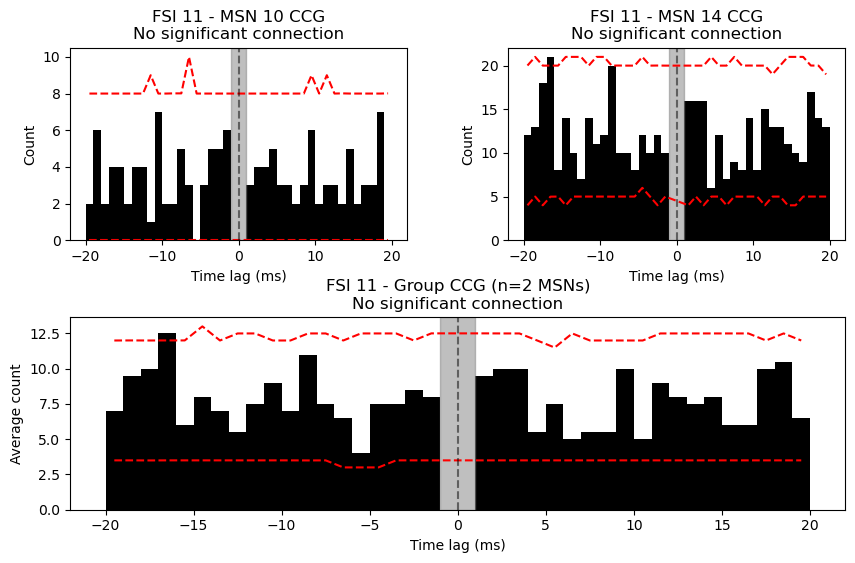

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI36_MSN31_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI36_MSN31_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI36_MSN31_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI36_MSN37_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI36_MSN37_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI36_MSN37_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/cc

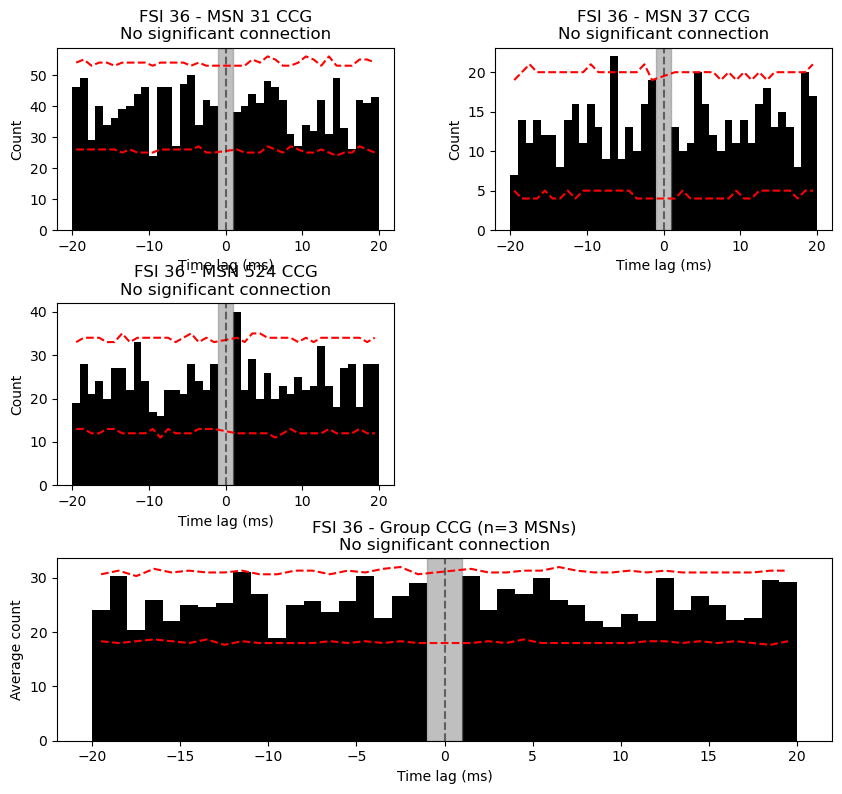

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI51_MSN46_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI51_MSN46_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI51_MSN46_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI51_MSN528_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI51_MSN528_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI51_MSN528_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys

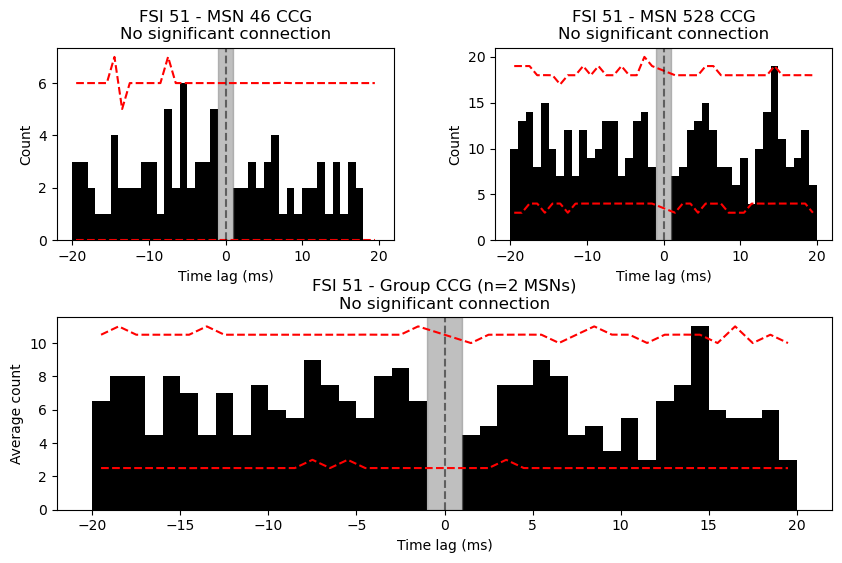

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI85_MSN84_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI85_MSN84_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI85_MSN84_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI85_MSN91_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI85_MSN91_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI85_MSN91_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/cc

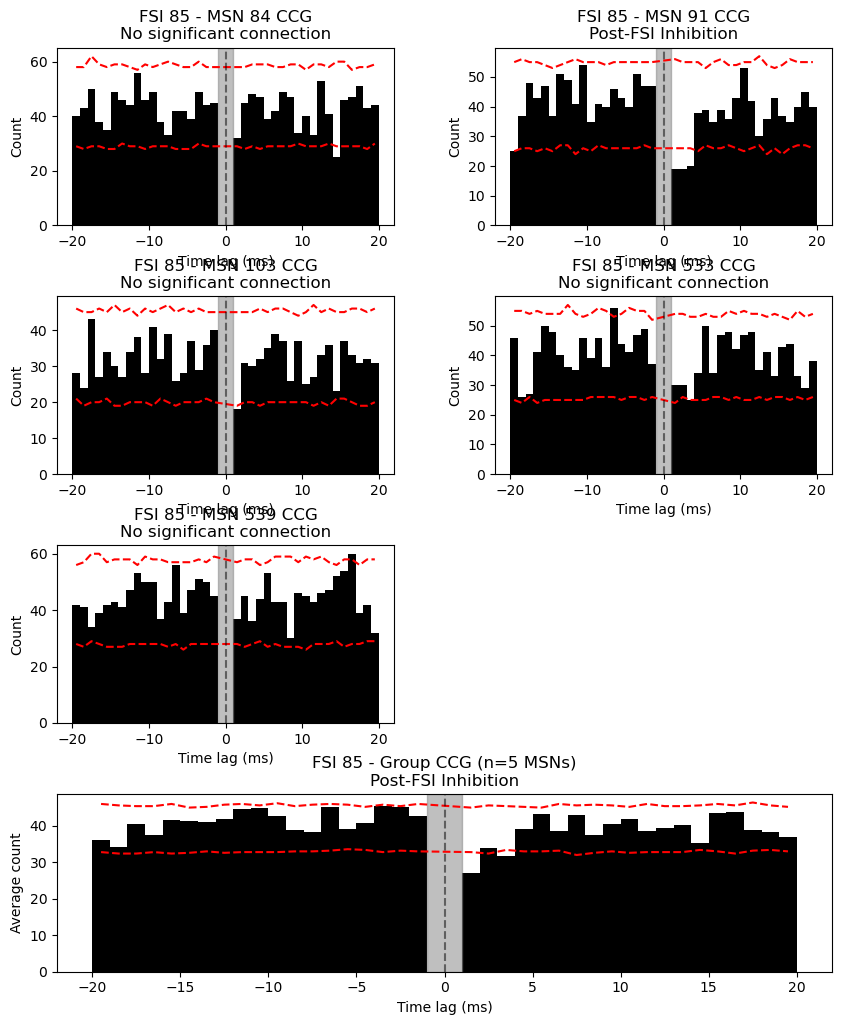

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI288_MSN163_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI288_MSN163_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI288_MSN163_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI288_MSN171_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI288_MSN171_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI288_MSN171_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_d

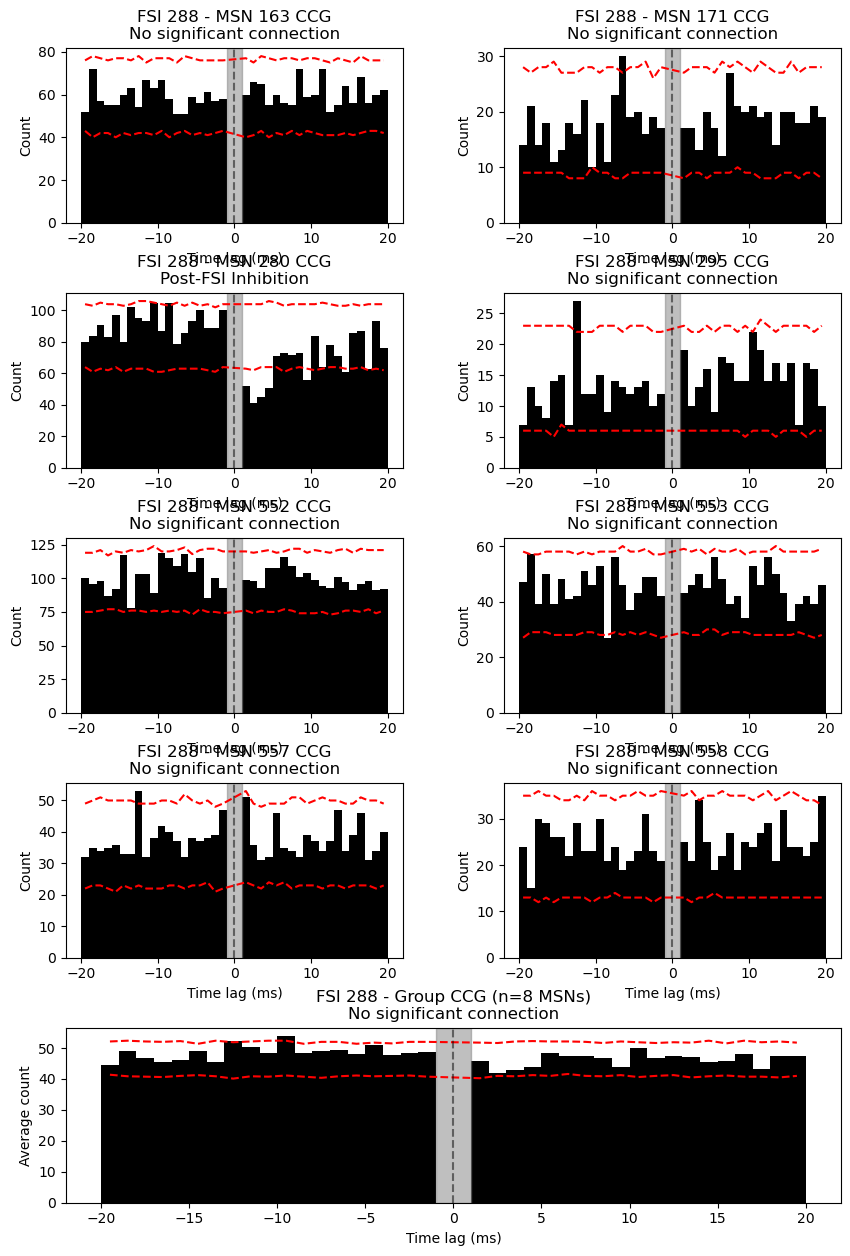

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI617_MSN371_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI617_MSN371_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI617_MSN371_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI617_MSN443_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI617_MSN443_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_FSI617_MSN443_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_d

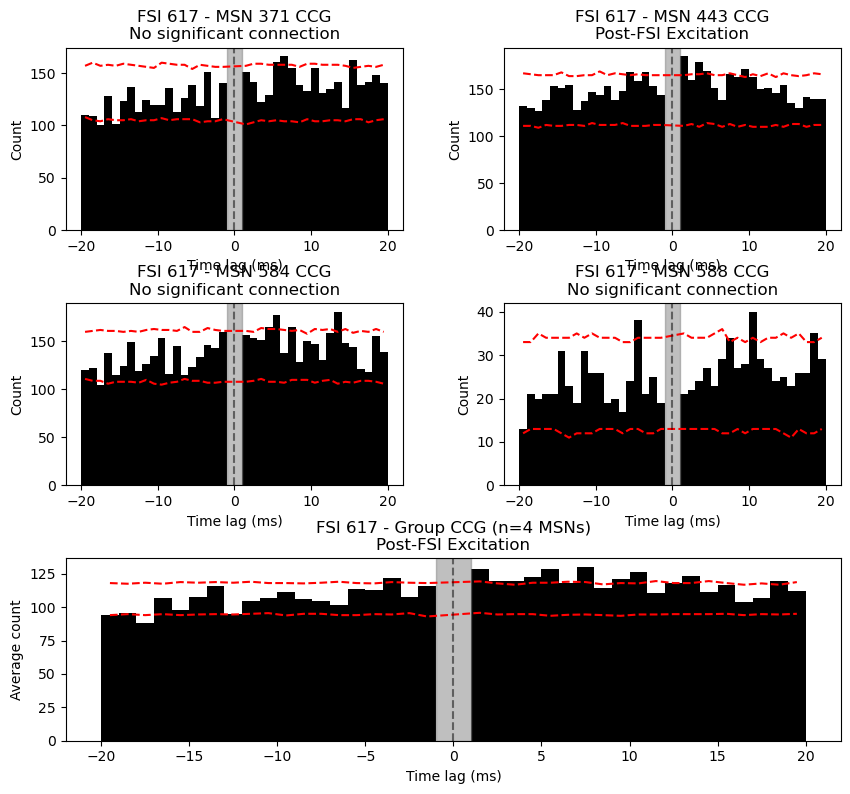

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_all_FSI_MSN_pairs_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7632_all_FSI_MSN_pairs_CCG.svg


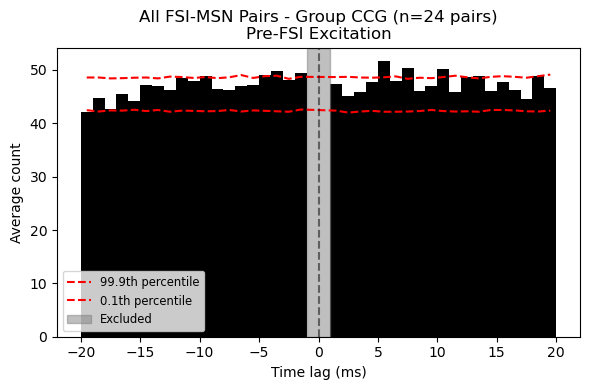

Processing 7762...
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_FSI347_MSN387_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_FSI347_MSN387_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_FSI347_MSN387_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_FSI347_MSN472_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_FSI347_MSN472_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_FSI347_MSN472_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\fi

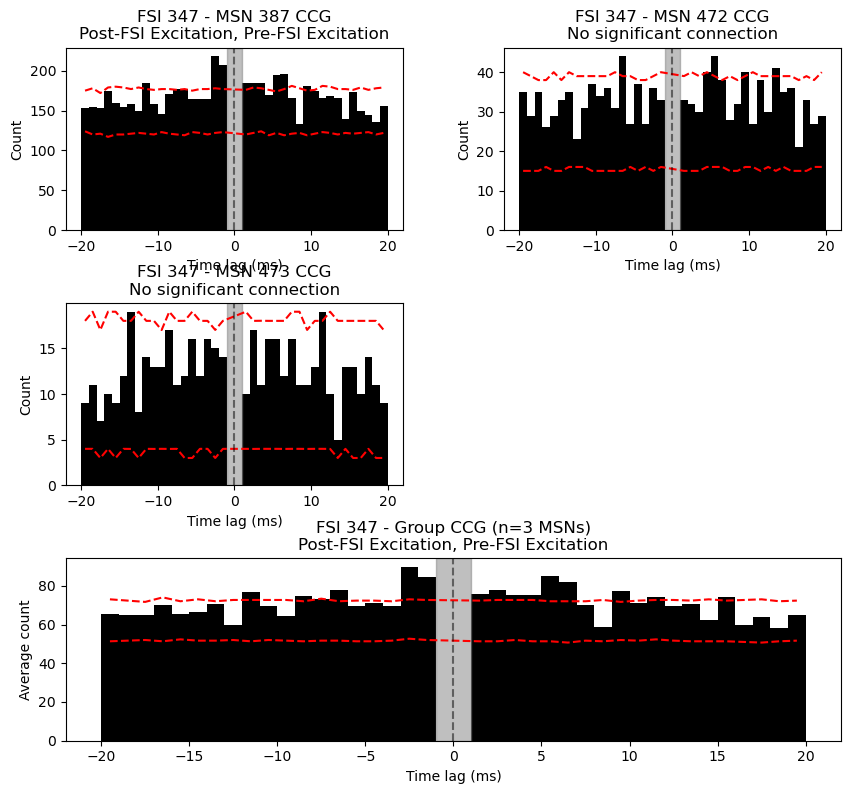

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_all_FSI_MSN_pairs_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7762_all_FSI_MSN_pairs_CCG.svg


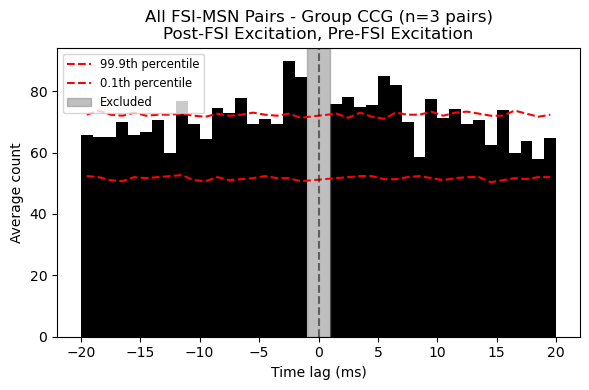

Processing 7763...
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI38_MSN47_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI38_MSN47_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI38_MSN47_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI38_MSN366_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI38_MSN366_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI38_MSN366_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_

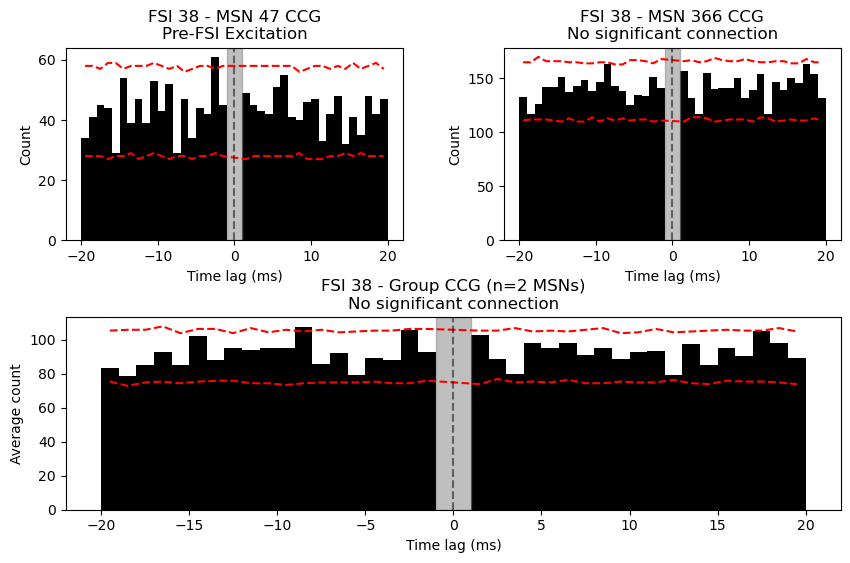

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI82_MSN408_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI82_MSN408_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI82_MSN408_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI82_group_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI82_group_CCG.svg
Group plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI82_group_CCG_all.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg

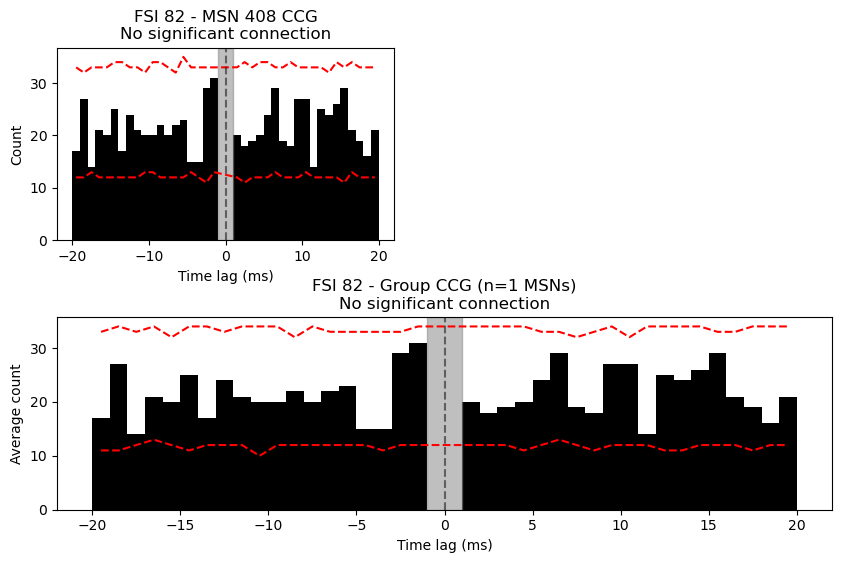

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI218_MSN233_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI218_MSN233_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI218_MSN233_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI218_group_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI218_group_CCG.svg
Group plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI218_group_CCG_all.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/eph

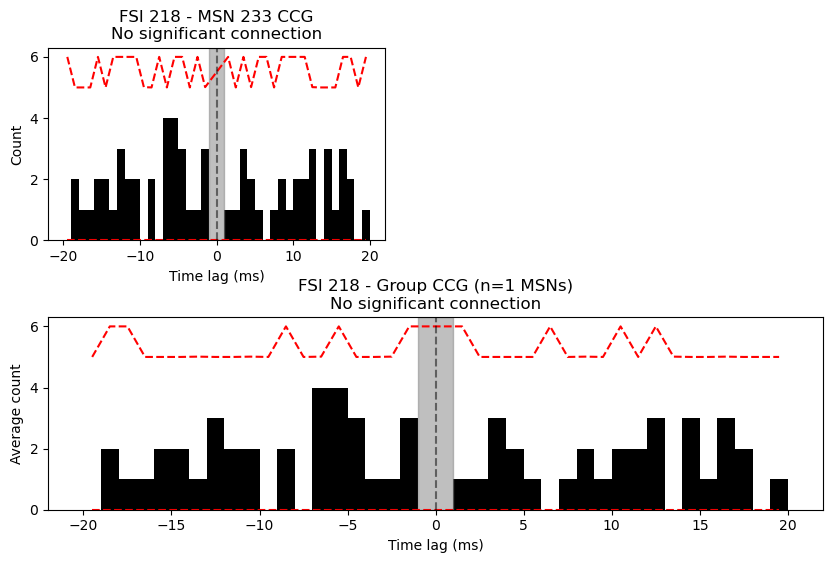

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI283_MSN284_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI283_MSN284_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI283_MSN284_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI283_MSN331_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI283_MSN331_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI283_MSN331_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_d

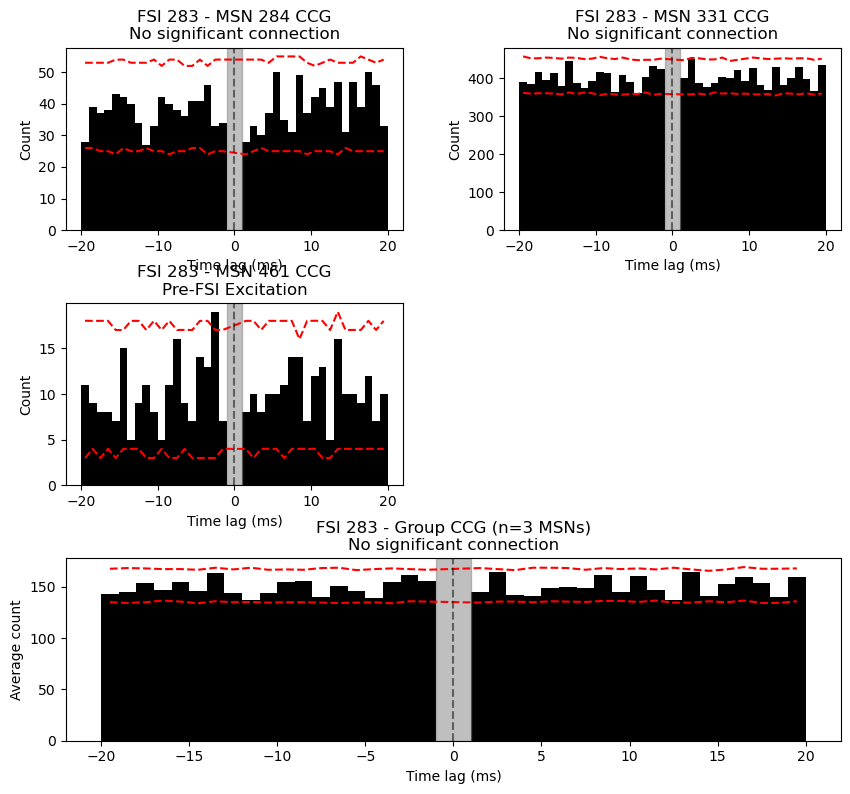

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI345_MSN346_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI345_MSN346_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI345_MSN346_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI345_MSN464_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI345_MSN464_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_FSI345_MSN464_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_d

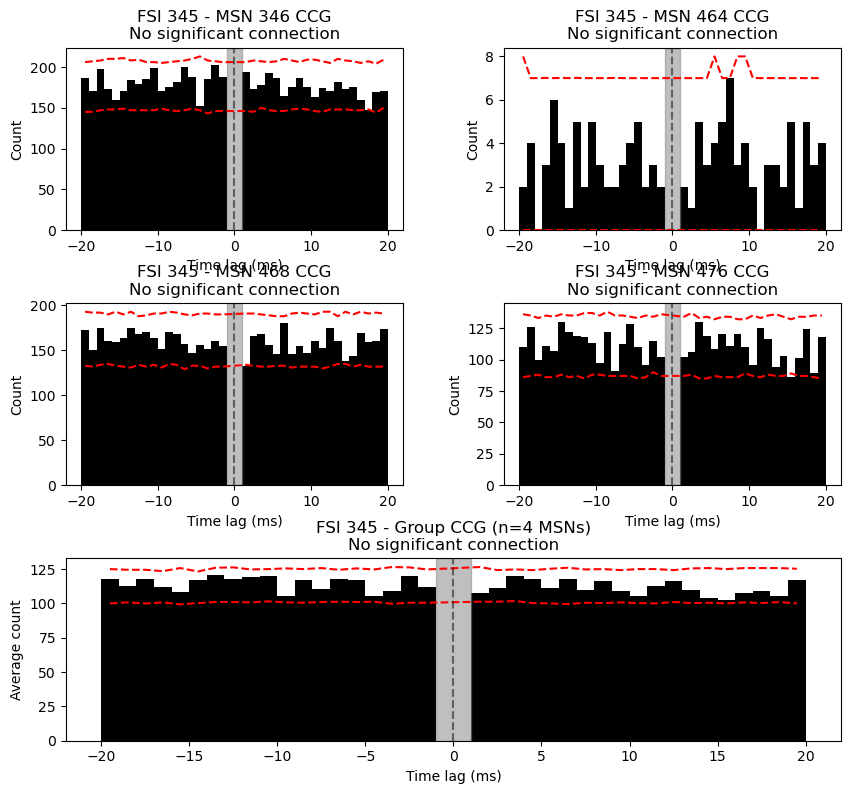

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_all_FSI_MSN_pairs_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7763_all_FSI_MSN_pairs_CCG.svg


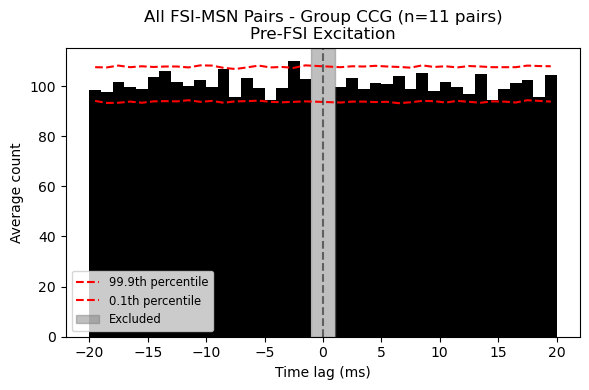

Processing 7772...
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_FSI218_MSN332_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_FSI218_MSN332_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_FSI218_MSN332_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_FSI218_group_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_FSI218_group_CCG.svg
Group plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_FSI218_group_CCG_all.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\pape

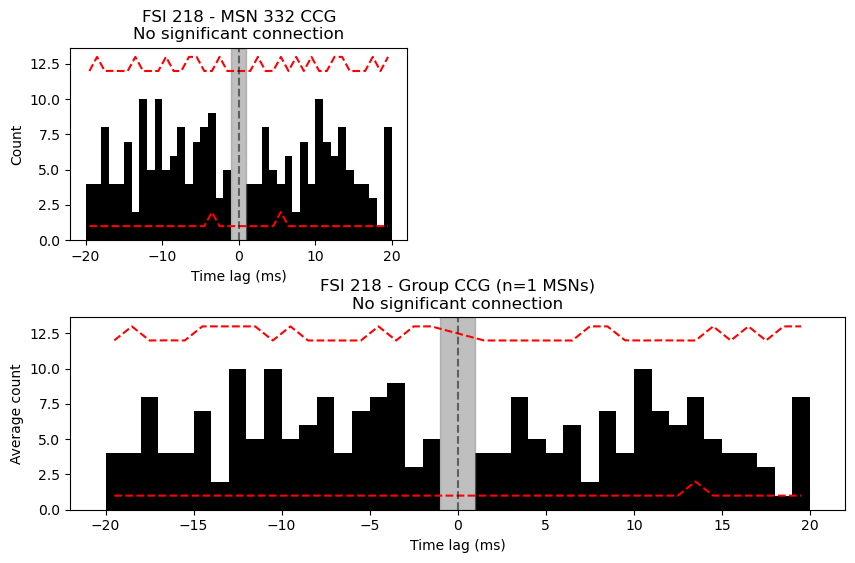

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_all_FSI_MSN_pairs_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7772_all_FSI_MSN_pairs_CCG.svg


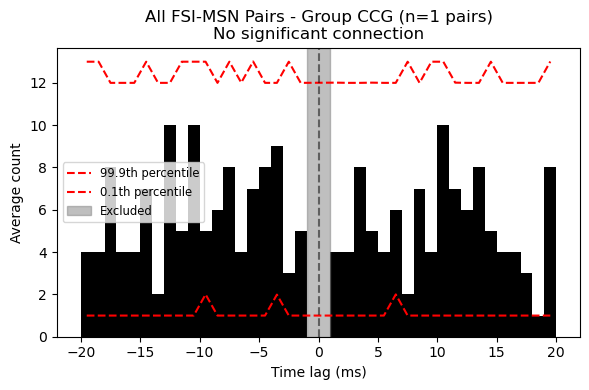

Processing 7816...
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_FSI120_MSN123_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_FSI120_MSN123_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_FSI120_MSN123_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_FSI120_MSN426_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_FSI120_MSN426_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_FSI120_MSN426_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\fi

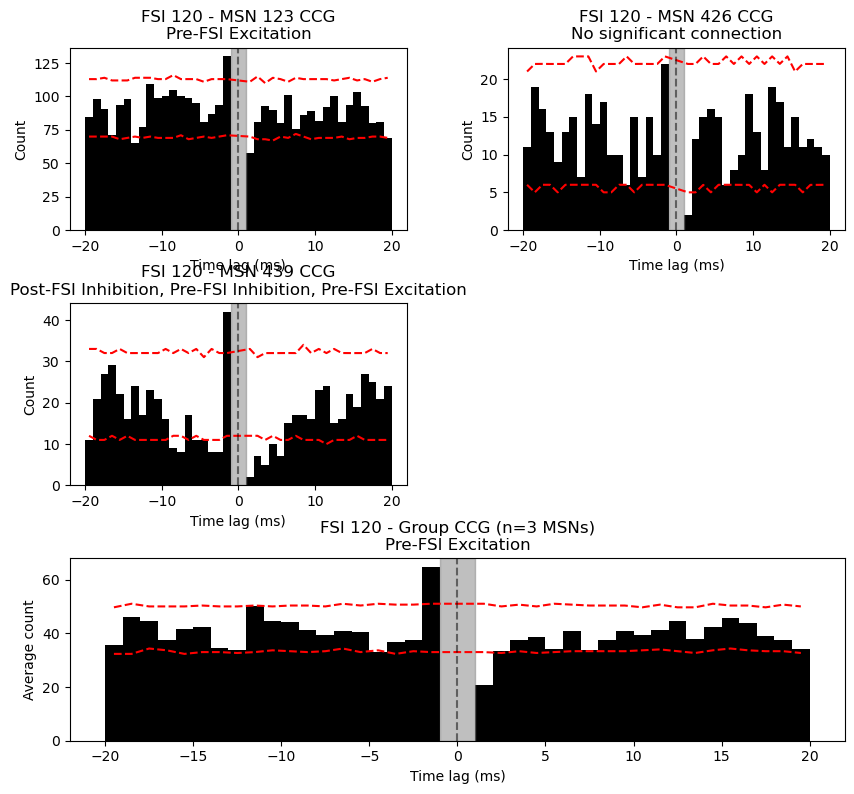

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_all_FSI_MSN_pairs_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7816_all_FSI_MSN_pairs_CCG.svg


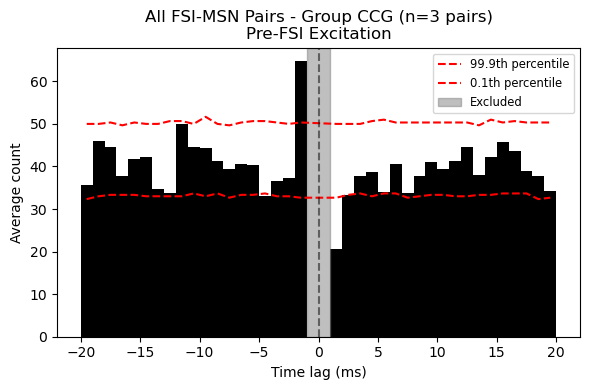

Processing 7917...
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI196_MSN194_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI196_MSN194_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI196_MSN194_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI196_group_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI196_group_CCG.svg
Group plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI196_group_CCG_all.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\pape

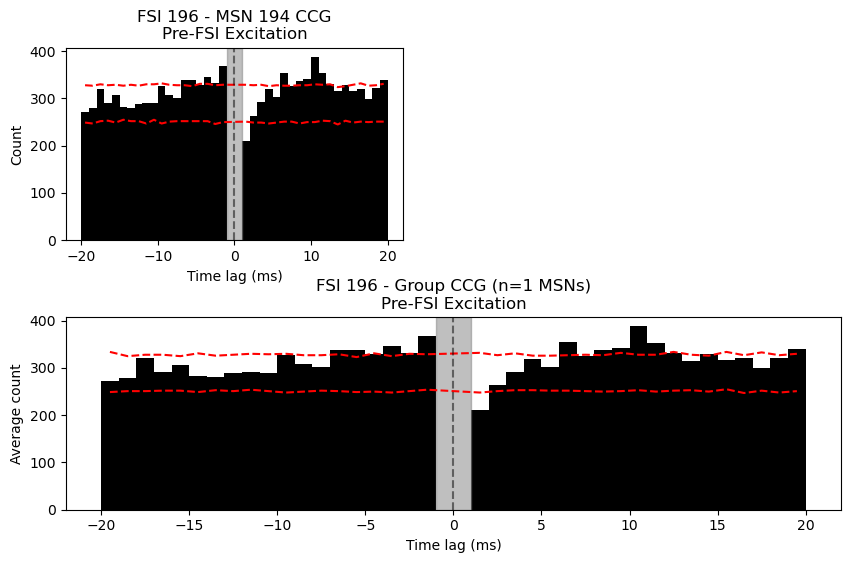

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI371_MSN395_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI371_MSN395_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI371_MSN395_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI371_group_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI371_group_CCG.svg
Group plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI371_group_CCG_all.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/eph

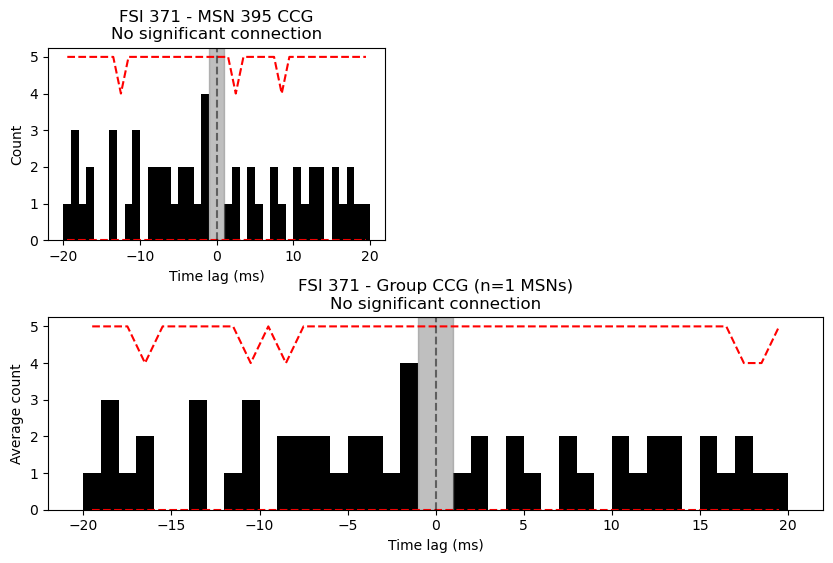

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI377_MSN285_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI377_MSN285_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI377_MSN285_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI377_MSN291_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI377_MSN291_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_FSI377_MSN291_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_d

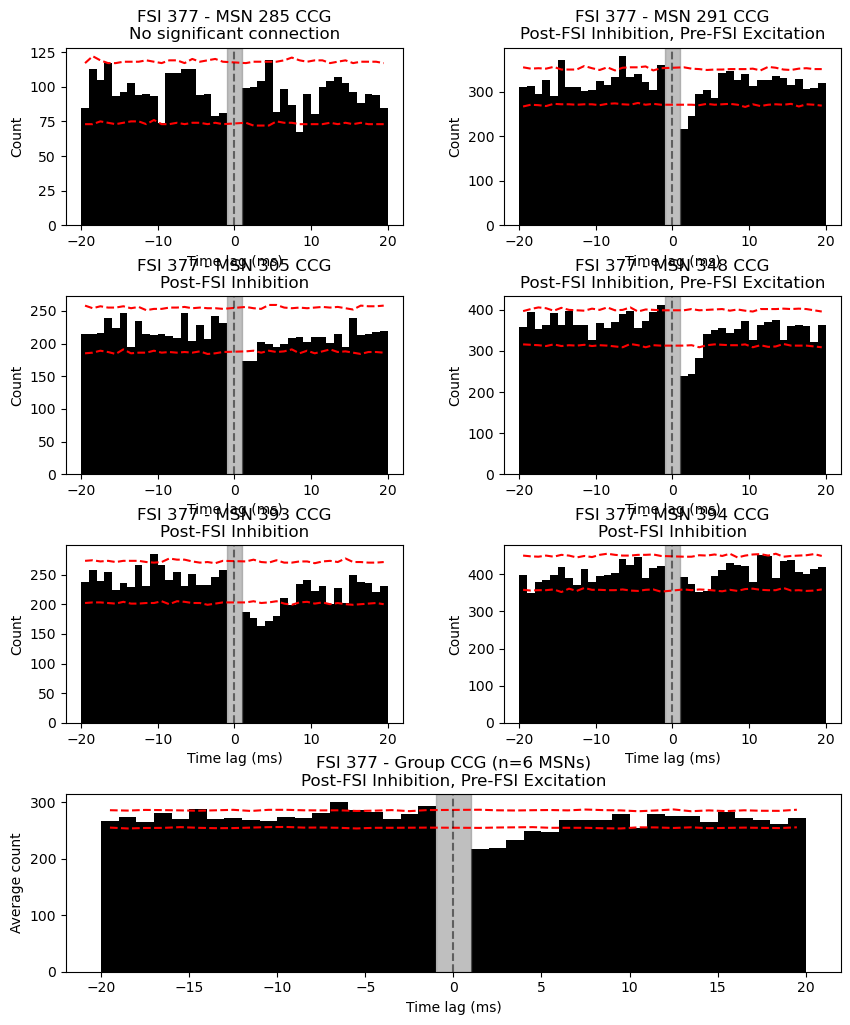

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_all_FSI_MSN_pairs_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7917_all_FSI_MSN_pairs_CCG.svg


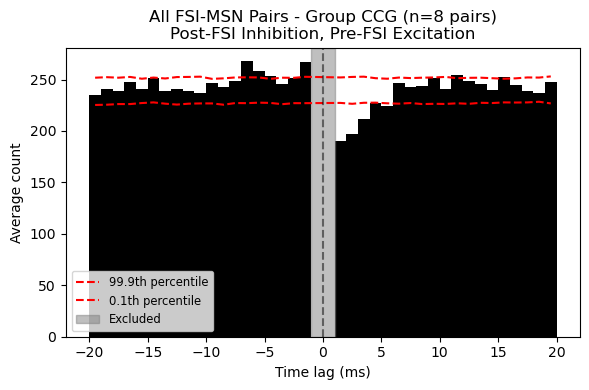

Processing 7918...
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI23_MSN22_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI23_MSN22_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI23_MSN22_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI23_MSN24_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI23_MSN24_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI23_MSN24_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_fig

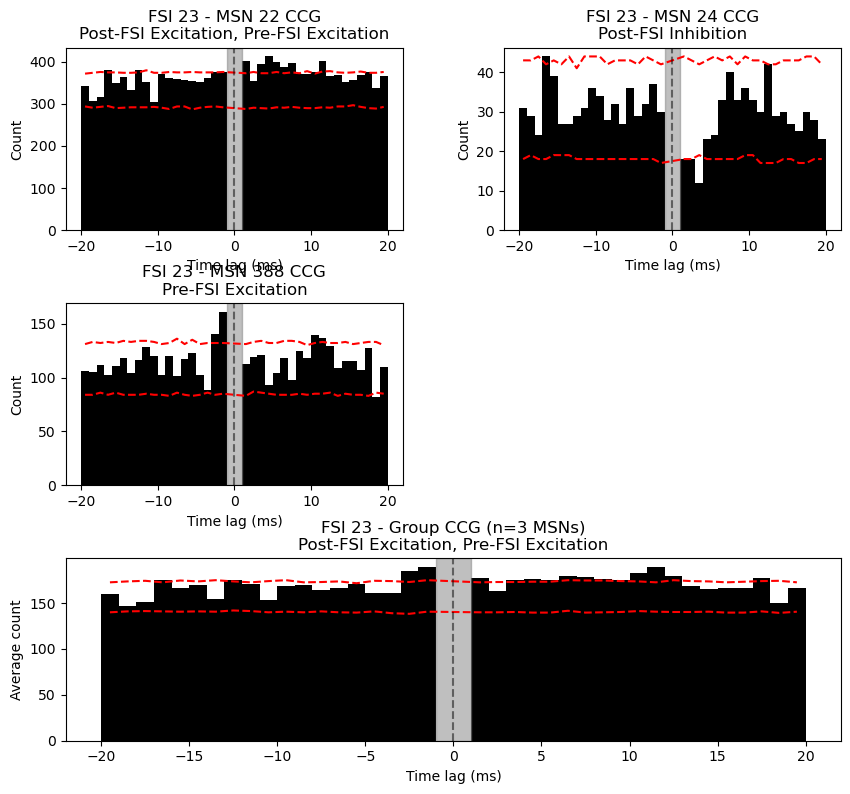

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI35_MSN22_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI35_MSN22_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI35_MSN22_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI35_MSN24_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI35_MSN24_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI35_MSN24_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/cc

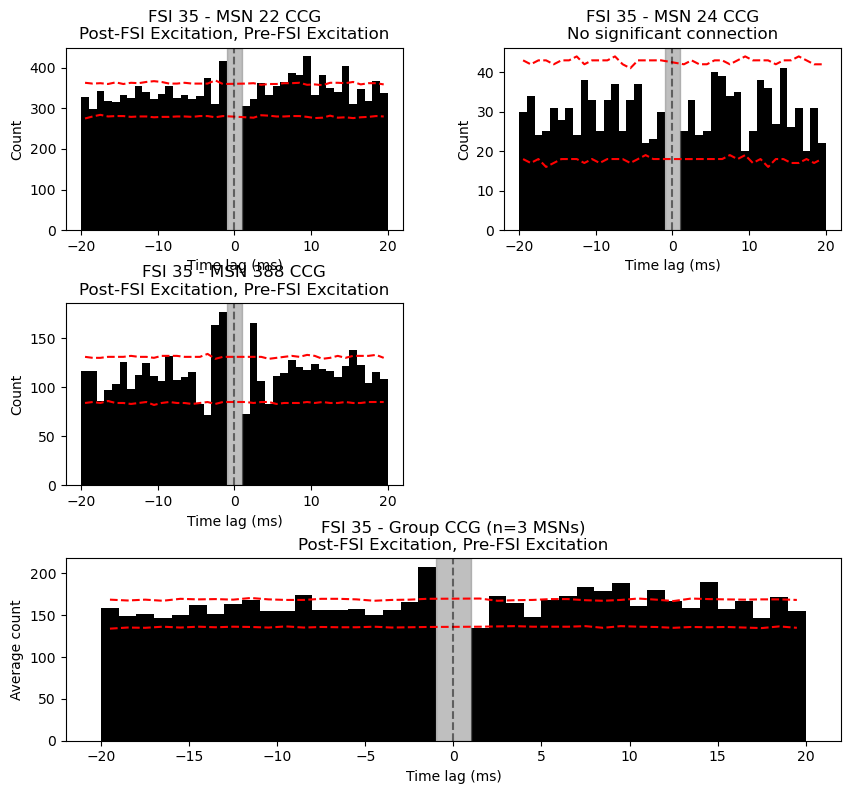

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI78_MSN378_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI78_MSN378_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI78_MSN378_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI78_group_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI78_group_CCG.svg
Group plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI78_group_CCG_all.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg

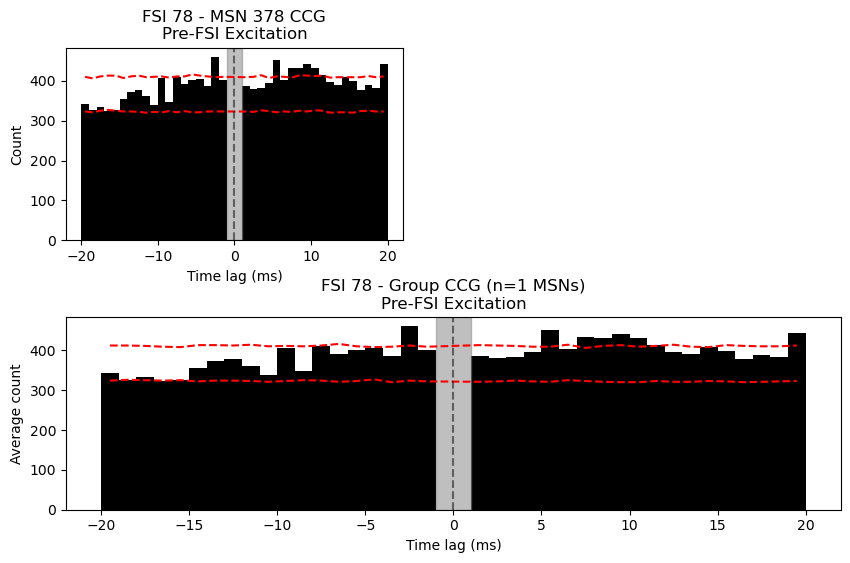

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI181_MSN384_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI181_MSN384_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI181_MSN384_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI181_MSN390_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI181_MSN390_CCG.svg
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_FSI181_MSN390_CCG.csv
Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_d

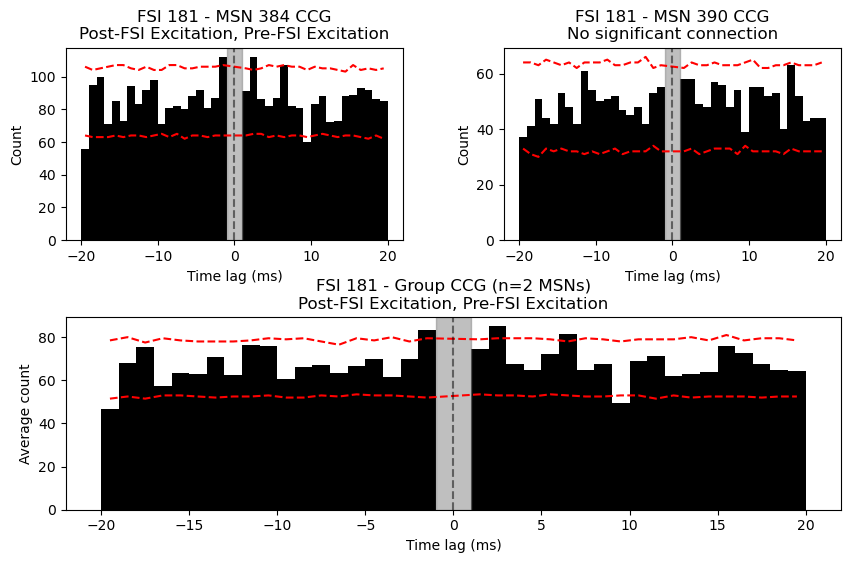

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_all_FSI_MSN_pairs_CCG.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg/all\7918_all_FSI_MSN_pairs_CCG.svg


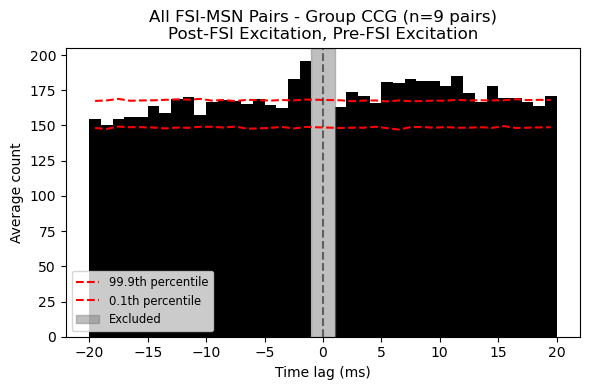

Results saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/ccg\all_ccg_results_day2.pkl


In [12]:
day = 'day2'
all_ccg_results = []

for animal_id in group_data[day].keys():
    print(f"Processing {animal_id}...")
    animal_results = plot_ccg_analysis(group_data, day, animal_id, save_dir=figDataSaveDir + '/ephys/ccg/all')
    all_ccg_results.append(animal_results)

# Define a path to save the results
output_dir = figDataSaveDir + '/ephys/ccg'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'all_ccg_results_{day}.pkl')

# Save the results into a .pkl file
with open(output_path, 'wb') as f:
    pickle.dump(all_ccg_results, f)

print(f"Results saved to {output_path}")



In [13]:
def identify_inhibitory_connection(ccg, bins, exclude_window_ms=1, bin_size_ms=1, 
                                 end_window_ms=5, consecutive_bins_required=2):
    """
    Identify if a pair shows inhibitory connection in specified window following FSI spike.
    
    Parameters:
    -----------
    ccg : array
        The cross-correlogram
    bins : array
        Bin edges
    exclude_window_ms : float
        Width of exclusion window around 0 (default: 1ms)
    bin_size_ms : float
        Size of CCG bins in milliseconds (default: 1ms)
    end_window_ms : float
        End point of analysis window after spike (default: 5ms)
    consecutive_bins_required : int
        Number of consecutive bins that must be below threshold (default: 2)
    
    Returns:
    --------
    bool 
        Whether the pair shows inhibitory connection
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Define the analysis window
    exclude_bins = int(np.ceil(exclude_window_ms / bin_size_ms))
    post_start = np.where(bin_centers >= exclude_window_ms)[0][0]
    post_end = np.where(bin_centers >= end_window_ms)[0][0]
    post_window = slice(post_start, post_end)
    
    # Check for inhibition
    baseline = np.mean(ccg)
    inhibition_threshold = baseline - 2 * np.std(ccg)
    
    # Look for consecutive bins below threshold
    below_threshold = ccg[post_window] < inhibition_threshold
    consecutive_bins = 0
    for is_below in below_threshold:
        if is_below:
            consecutive_bins += 1
            if consecutive_bins >= consecutive_bins_required:
                return True
        else:
            consecutive_bins = 0
            
    return False

def save_ccg_to_csv(bin_centers, ccg_avg, ccg_sem, save_path):
    """
    Save CCG average and error bars to a CSV file.
    
    Parameters:
    -----------
    bin_centers : array
        Bin center times.
    ccg_avg : array
        Average CCG values.
    ccg_sem : array
        Standard error of the mean for CCG values.
    save_path : str
        Path to save the CSV file.
    """
    with open(save_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Bin_Center_ms", "CCG_Avg", "CCG_SEM"])
        for bin_center, avg, sem in zip(bin_centers, ccg_avg, ccg_sem):
            writer.writerow([bin_center, avg, sem])
    print(f"CCG data saved to {save_path}")


def plot_combined_ccg(all_results, save_dir=None, exclude_window_ms=1, bin_size_ms=1, 
                               end_window_ms=5, consecutive_bins_required=2, plot_individual=False):
    """
    Plot combined CCG across all animals and pairs, and save CSV files for the results.
    
    Additional functionality: Saves CSV files for CCG averages and SEMs.
    """
    inhibitory_ccgs = []
    non_inhibitory_ccgs = []
    bins = None
    
    # Sort CCGs into inhibitory and non-inhibitory groups
    for animal_result in all_results:
        individual_data = animal_result['ccg_data']['individual']
        
        if individual_data:
            for entry in individual_data:
                ccg = entry['ccg']
                if bins is None:
                    bins = entry['bins']
                
                # Classify the connection
                is_inhibitory = identify_inhibitory_connection(
                    ccg, bins, 
                    exclude_window_ms=exclude_window_ms,
                    bin_size_ms=bin_size_ms,
                    end_window_ms=end_window_ms,
                    consecutive_bins_required=consecutive_bins_required
                )
                
                if is_inhibitory:
                    inhibitory_ccgs.append(ccg)
                else:
                    non_inhibitory_ccgs.append(ccg)
    
    if not (inhibitory_ccgs or non_inhibitory_ccgs):
        print("No valid CCG data found across all animals.")
        return

    bin_centers = (bins[:-1] + bins[1:]) / 2
    plot_mask = (bin_centers >= -20) & (bin_centers <= 20)
    
    # Calculate averages and SEMs
    if inhibitory_ccgs:
        inhibitory_avg = np.mean(inhibitory_ccgs, axis=0)
        inhibitory_sem = np.std(inhibitory_ccgs, axis=0) / np.sqrt(len(inhibitory_ccgs))
        if save_dir:
            save_ccg_to_csv(bin_centers[plot_mask], inhibitory_avg[plot_mask], inhibitory_sem[plot_mask], 
                            os.path.join(save_dir, 'Inhibitory_CCG.csv'))
    
    if non_inhibitory_ccgs:
        non_inhibitory_avg = np.mean(non_inhibitory_ccgs, axis=0)
        non_inhibitory_sem = np.std(non_inhibitory_ccgs, axis=0) / np.sqrt(len(non_inhibitory_ccgs))
        if save_dir:
            save_ccg_to_csv(bin_centers[plot_mask], non_inhibitory_avg[plot_mask], non_inhibitory_sem[plot_mask], 
                            os.path.join(save_dir, 'Non_Inhibitory_CCG.csv'))
    
    all_ccgs = inhibitory_ccgs + non_inhibitory_ccgs
    if all_ccgs:
        all_avg = np.mean(all_ccgs, axis=0)
        all_sem = np.std(all_ccgs, axis=0) / np.sqrt(len(all_ccgs))
        if save_dir:
            save_ccg_to_csv(bin_centers[plot_mask], all_avg[plot_mask], all_sem[plot_mask], 
                            os.path.join(save_dir, 'All_Pairs_Combined_CCG.csv'))
    

    # Plot individual CCGs if requested
    if plot_individual:
        n_inhibitory = len(inhibitory_ccgs)
        n_non_inhibitory = len(non_inhibitory_ccgs)
        n_rows = max(n_inhibitory, n_non_inhibitory)
        
        if n_rows > 0:
            fig_ind, (ax_inh, ax_non) = plt.subplots(1, 2, figsize=(15, 3*n_rows))
            bin_centers = (bins[:-1] + bins[1:]) / 2
            exclude_mask = (bin_centers >= -exclude_window_ms) & (bin_centers <= exclude_window_ms)
            plot_mask = ~exclude_mask & (bin_centers >= -20) & (bin_centers <= 20)
            
            # Plot inhibitory CCGs
            for i, ccg in enumerate(inhibitory_ccgs):
                ax_inh.plot(bin_centers[plot_mask], ccg[plot_mask], 
                          alpha=0.5, label=f'Pair {i+1}')
            
            # Plot non-inhibitory CCGs
            for i, ccg in enumerate(non_inhibitory_ccgs):
                ax_non.plot(bin_centers[plot_mask], ccg[plot_mask], 
                          alpha=0.5, label=f'Pair {i+1}')
            
            # Format individual plots
            for ax, title in zip([ax_inh, ax_non], 
                               [f'Individual Inhibitory CCGs (n={n_inhibitory})',
                                f'Individual Non-inhibitory CCGs (n={n_non_inhibitory})']):
                ax.axvspan(exclude_window_ms, end_window_ms, 
                          color='yellow', alpha=0.2, label='Analysis Window')
                ax.axvspan(-exclude_window_ms, exclude_window_ms, 
                          color='gray', alpha=0.5, label='Excluded Zone')
                ax.axvline(0, color='k', linestyle='--', alpha=0.5)
                ax.set_title(title)
                ax.set_xlabel('Time Lag (ms)')
                ax.set_ylabel('Count')
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            
            if save_dir:
                filename = os.path.join(save_dir, 'Individual_CCGs')
                plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
                plt.savefig(f"{filename}.svg", bbox_inches='tight')
    
    # Plot averages
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 12))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    exclude_mask = (bin_centers >= -exclude_window_ms) & (bin_centers <= exclude_window_ms)
    plot_mask = ~exclude_mask & (bin_centers >= -20) & (bin_centers <= 20)
    
    # Plot inhibitory pairs average
    if inhibitory_ccgs:
        inhibitory_avg = np.mean(inhibitory_ccgs, axis=0)
        inhibitory_sem = np.std(inhibitory_ccgs, axis=0) / np.sqrt(len(inhibitory_ccgs))
        
        ax1.bar(bin_centers[plot_mask], inhibitory_avg[plot_mask],
                width=bin_size_ms, color='black')
        ax1.fill_between(bin_centers[plot_mask], 
                        inhibitory_avg[plot_mask] - inhibitory_sem[plot_mask],
                        inhibitory_avg[plot_mask] + inhibitory_sem[plot_mask],
                        color='gray', alpha=0.3, label='SEM')
    
    # Plot non-inhibitory pairs average
    if non_inhibitory_ccgs:
        non_inhibitory_avg = np.mean(non_inhibitory_ccgs, axis=0)
        non_inhibitory_sem = np.std(non_inhibitory_ccgs, axis=0) / np.sqrt(len(non_inhibitory_ccgs))
        
        ax2.bar(bin_centers[plot_mask], non_inhibitory_avg[plot_mask],
                width=bin_size_ms, color='black')
        ax2.fill_between(bin_centers[plot_mask], 
                        non_inhibitory_avg[plot_mask] - non_inhibitory_sem[plot_mask],
                        non_inhibitory_avg[plot_mask] + non_inhibitory_sem[plot_mask],
                        color='gray', alpha=0.3, label='SEM')
    
    # Plot all pairs combined
    all_ccgs = inhibitory_ccgs + non_inhibitory_ccgs
    all_avg = np.mean(all_ccgs, axis=0)
    all_sem = np.std(all_ccgs, axis=0) / np.sqrt(len(all_ccgs))
    
    ax3.bar(bin_centers[plot_mask], all_avg[plot_mask],
            width=bin_size_ms, color='black')
    ax3.fill_between(bin_centers[plot_mask], 
                    all_avg[plot_mask] - all_sem[plot_mask],
                    all_avg[plot_mask] + all_sem[plot_mask],
                    color='gray', alpha=0.3, label='SEM')
    
    # Format average plots
    for ax, title in zip([ax1, ax2, ax3], 
                        [f'Inhibitory Pairs (n={len(inhibitory_ccgs)})',
                         f'Non-inhibitory Pairs (n={len(non_inhibitory_ccgs)})',
                         f'All Pairs Combined (n={len(all_ccgs)})']):
        ax.axvspan(exclude_window_ms, end_window_ms, 
                  color='yellow', alpha=0.2, label='Analysis Window')
        ax.axvspan(-exclude_window_ms, exclude_window_ms, 
                  color='gray', alpha=0.5, label='Excluded Zone')
        ax.axvline(0, color='k', linestyle='--', alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('Time Lag (ms)')
        ax.set_ylabel('Average Count')
        ax.legend(fontsize='small')
    
    plt.tight_layout()
    
    # Save average plots
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = os.path.join(save_dir, 'CCG_Analysis_All_Types')
        plt.savefig(f"{filename}.png", dpi=300)
        plt.savefig(f"{filename}.svg")
        print(f"Plots saved to {filename}.png and {filename}.svg")
    
    plt.show()

CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\Inhibitory_CCG.csv
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\Non_Inhibitory_CCG.csv
CCG data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\All_Pairs_Combined_CCG.csv
Plots saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\CCG_Analysis_All_Types.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\CCG_Analysis_All_Types.svg


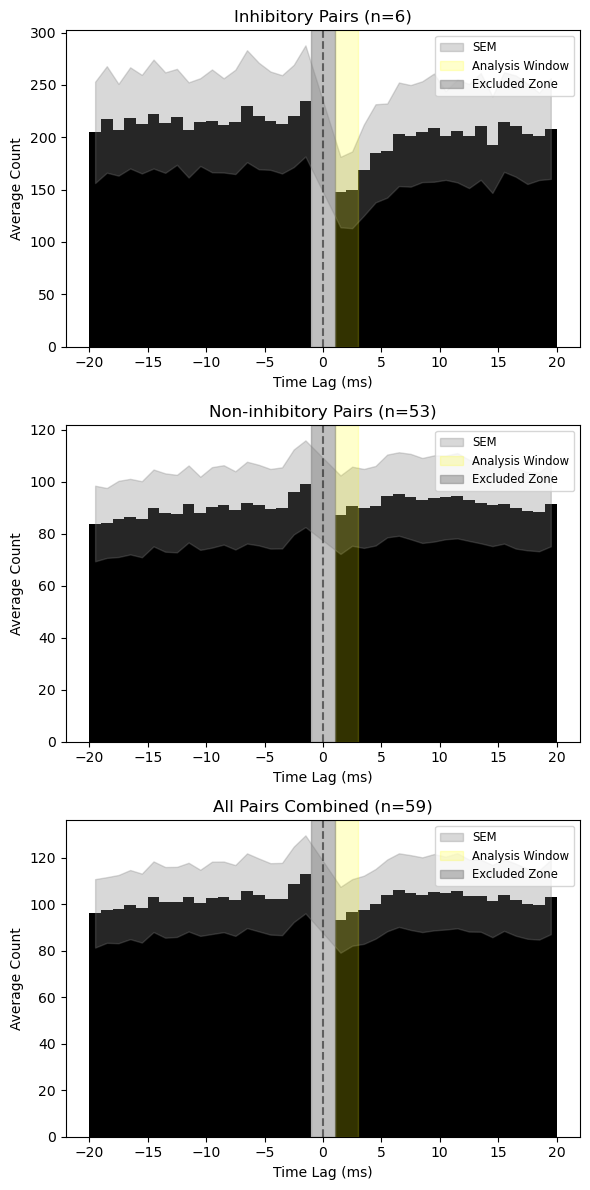

In [14]:
plot_combined_ccg(all_ccg_results, save_dir=figDataSaveDir + '/ephys', exclude_window_ms=1, plot_individual = False,
                 end_window_ms=3, consecutive_bins_required=2)


### example ensemble

10.0
0.0
Matrix shape: (60, 37124)


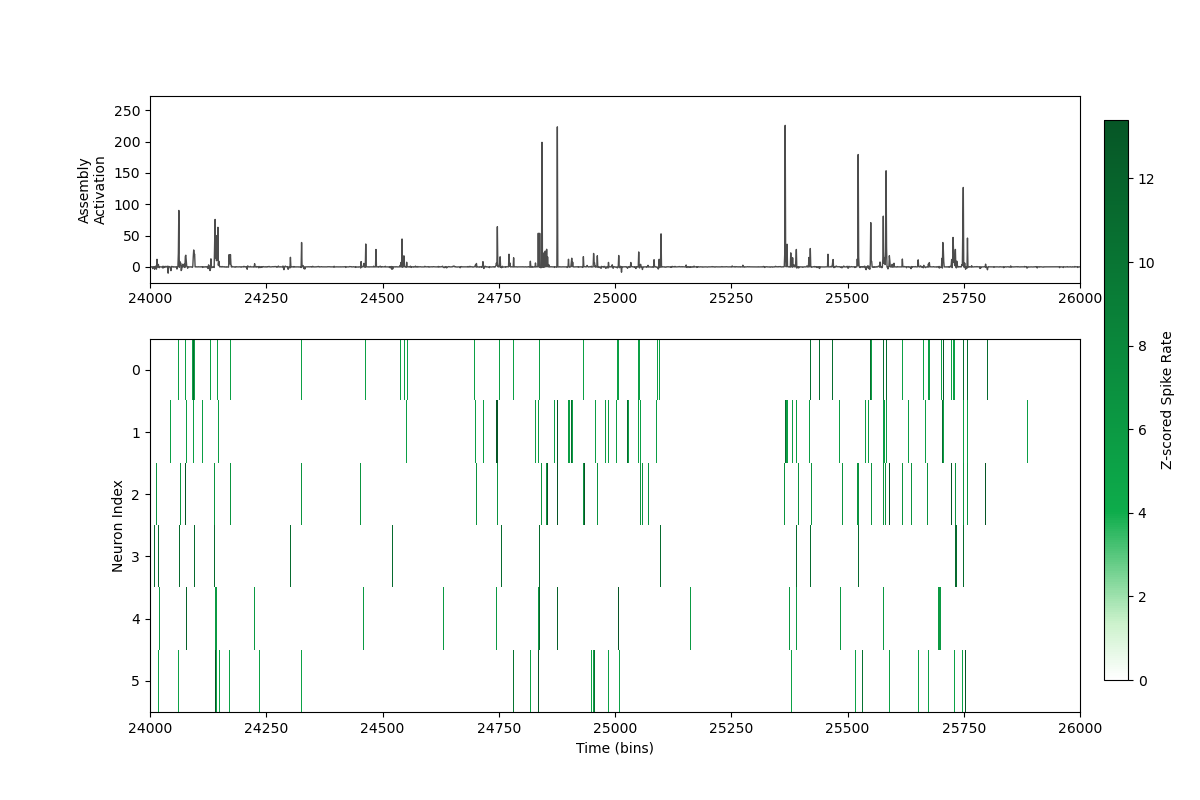

In [15]:

example_day = 'day2'     
example_animal = '7632' 

# Extract session data
session_data = group_data[example_day][example_animal]

# Extract relevant data
spike_times = session_data['spike_times']
spike_clusters = session_data['spike_clusters']
validated_clusters = session_data['validated_clusters']
recording_time = session_data['recording_time']

# Filter for MSNs
msn_mask = validated_clusters['Classification'] == 'MSN'
msn_clusters = validated_clusters[msn_mask]

# Create C_final matrix (binned spike counts) for MSNs only
bin_size = 0.05  # Same as used earlier
n_bins = int(np.ceil(recording_time / bin_size))
C_final = np.zeros((len(msn_clusters), n_bins))

for i, cluster_id in enumerate(msn_clusters['ClusterID']):
    cluster_spikes = spike_times[spike_clusters == cluster_id] / 30000  # Convert to seconds
    spike_bins = (cluster_spikes / bin_size).astype(int)
    for b in spike_bins:
        if b < n_bins:
            C_final[i, b] += 1  # Count spikes per bin

# Convert spike counts to Hz (given bin_size in seconds)
C_final_hz = C_final / bin_size  # converts counts/bin to counts/second (Hz)

print(np.max(C_final))
print(np.min(C_final))



# Ensure C_final matrix is not empty
if C_final.size == 0:
    print(f"No valid C_final matrix found for {example_animal} on {example_day}.")
else:
    print(f"Matrix shape: {C_final.shape}")


    %matplotlib widget
    assembly_dict, fig, axs = find_assemblies(
        C_final_hz, 
        method='ica', 
        nullhyp='mp', 
        n_shuffles=1000, 
        percentile=99, 
        tracywidow=False, 
        compute_activity=True, 
        use_bool=False, 
        plot=True, 
        plot_each_pattern=True,
        save_single_pattern=True,
        which_pattern_toSave=1,  
        save_dir=figDataSaveDir + '/ephys',  
        filename='spike_ensemble_example'
    )


### ensemble identification

In [16]:
def process_animal_for_assemblies(group_data, bin_size=0.05):
    assemblies_data = {}
    groupName = 'control'
    assemblies_data[groupName] = {}
    
    for day, animals in group_data.items():
        for animal_id, session_data in animals.items():

            
            # Extract session data
            spike_times = session_data['spike_times']
            spike_clusters = session_data['spike_clusters']
            validated_clusters = session_data['validated_clusters']
            recording_time = session_data['recording_time']
            
            # Filter for MSNs only
            msn_mask = validated_clusters['Classification'] == 'MSN'
            msn_clusters = validated_clusters[msn_mask]
            
            # Create C_final matrix (binned spike counts) for MSNs only
            n_bins = int(np.ceil(recording_time / bin_size))
            C_final = np.zeros((len(msn_clusters), n_bins))
            
            for i, cluster_id in enumerate(msn_clusters['ClusterID']):
                cluster_spikes = spike_times[spike_clusters == cluster_id] / 30000  # Convert to seconds
                spike_bins = (cluster_spikes / bin_size).astype(int)
                
                for b in spike_bins:
                    if b < n_bins:
                        C_final[i, b] += 1  # Count spikes per bin
                        
            assembly_dict, _, _ = find_assemblies(
                C_final, 
                method='ica', 
                nullhyp='mp', 
                n_shuffles=1000, 
                percentile=99, 
                tracywidow=False, 
                compute_activity=True, 
                use_bool=False, 
                plot=False, 
                plot_each_pattern=False
            )
            
            # Process assembly data
            if assembly_dict is None:
                assemblies_data[animal_id] = 'none'
                print(f"{animal_id} - No assemblies found (empty actmat).")
                continue

            #print(assembly_dict['significance'].nassemblies)
            
            assemblies_data[groupName][animal_id] = {
                day: {
                    'num_assemblies': assembly_dict['significance'].nassemblies,
                    'num_neurons': C_final.shape[0],  # Now reflects number of MSNs only
                    'activations': assembly_dict['activations'],
                    'important_neurons': assembly_dict['patterns'],  # weights for each MSN
                    'cv': session_data.get('cv', None),  # Uses None if 'cv' is not present
                    'partner_side': session_data.get('partner_side', None),
                    'msn_cluster_ids': msn_clusters['ClusterID'].values  # Added to keep track of which MSNs were used
                }
            }
            #print(f"{animal_id} - Assemblies found.")
            
                        
    return assemblies_data


In [17]:
bin_size = 0.05
assemblies_data_day2 = process_animal_for_assemblies(group_data, bin_size=bin_size)

In [18]:
bin_size = 1
assemblies_data_day2_forbehav = process_animal_for_assemblies(group_data, bin_size=bin_size)

### ensemble SVM

In [19]:
def generate_event_vectors_npx(cv, activations, event_type=None, bin_size=0.05, sampling_rate=30000, shift_amount=0, return_individual_vectors=False):
    """
    Generate vectors from activation data based on events in the cv file for Neuropixels.

    Parameters:
    ----------
    cv : pandas.DataFrame
        Behavioral events data with start and end timestamps.
    activations : np.ndarray
        Assembly activation matrix (num_assemblies x num_bins).
    event_type : list or None
        Filter events to specific types. If None, include all events.
    bin_size : float
        Size of time bins for activations (in seconds).
    sampling_rate : int
        Sampling rate of the recording (in Hz).
    shift_amount : int
        Amount to shift event timestamps (for null distributions).
    return_individual_vectors : bool
        If True, return individual event vectors. If False, return average vector per event.

    Returns:
    -------
    vectors : np.ndarray
        Array of vectors extracted from activations, or empty array if no valid events are found.
    event_bounds : list of tuples
        Start and end bin indices for each event.
    """
    vectors = []
    event_bounds = []
    total_bins = activations.shape[1]  # Total number of bins in the activations matrix

    # Shift event times if specified (for null distributions)
    if shift_amount != 0:
        cv = cv.copy()
        cv['indexStart'] = np.roll(cv['indexStart'], shift_amount)
        cv['indexEnd'] = np.roll(cv['indexEnd'], shift_amount)

    for _, row in cv.iterrows():
        # Filter events by type if specified
        if event_type is None or row['EventType'] in event_type:
            # Convert timestamps to bin indices
            start_bin = int(row['indexStart'] / (sampling_rate * bin_size))
            end_bin = int(row['indexEnd'] / (sampling_rate * bin_size))

            # Ensure indices are within bounds
            if 0 <= start_bin < end_bin <= total_bins:
                if return_individual_vectors:
                    event_vectors = activations[:, start_bin:end_bin].T
                    if event_vectors.size > 0:  # Check if the array is not empty
                        vectors.extend(event_vectors)
                else:
                    event_vector = np.nanmean(activations[:, start_bin:end_bin], axis=1)
                    if not np.isnan(event_vector).all() and event_vector.size > 0:
                        vectors.append(event_vector)
                event_bounds.append((start_bin, end_bin))

    if len(vectors) == 0:
        return np.array([]), []  # Return empty array and empty list if no vectors

    if return_individual_vectors:
        return np.array(vectors)
    else:
        return np.array(vectors), event_bounds


def SVM_assemblies_ephys(assemblies_data, bin_size=1, n_splits=10, n_shuffles=1000, plot_results=False):
    """
    Perform SVM-based decoding of partner vs. novel chamber using assembly activations.
    Now includes accuracy alongside F1 and AUROC scores.
    """
    results = {'control': {}, 'expt': {}}

    for group_name, group_data in assemblies_data.items():
        print(f"Processing group: {group_name}")
        for animal_id, session_data in group_data.items():
            if 'day2' not in session_data:
                print(f"Skipping animal {animal_id} as no day2 data exists.")
                continue

            day_data = session_data['day2']
            activations = day_data['activations']
            num_assemblies = day_data['num_assemblies']
            partner_side = day_data['partner_side']
            cv = day_data['cv']

            if partner_side is None or cv is None:
                print(f"Skipping animal {animal_id} due to missing partner_side or cv data.")
                continue

            partner_event_type = f"Area:Mouse 1 Center In {partner_side} chamber"
            novel_event_type = f"Area:Mouse 1 Center In {'right' if partner_side == 'left' else 'left'} chamber"

            print(f"Generating event vectors for animal {animal_id}")
            partner_vectors, partner_bounds = generate_event_vectors_npx(cv, activations, [partner_event_type], bin_size)
            novel_vectors, novel_bounds = generate_event_vectors_npx(cv, activations, [novel_event_type], bin_size)

            print(f"Animal {animal_id}: Partner Vectors: {len(partner_vectors)}, Partner Events: {len(partner_bounds)}")
            print(f"Animal {animal_id}: Novel Vectors: {len(novel_vectors)}, Novel Events: {len(novel_bounds)}")

            if partner_vectors.size == 0 or novel_vectors.size == 0:
                print(f"Skipping animal {animal_id} due to empty partner or novel vectors.")
                continue

            X = np.vstack((partner_vectors, novel_vectors))
            y = np.hstack((np.ones(len(partner_vectors)), np.zeros(len(novel_vectors))))

            if len(partner_vectors) < n_splits or len(novel_vectors) < n_splits:
                print(f"Skipping animal {animal_id} due to insufficient samples for n_splits={n_splits}.")
                continue

            print(f"Running Stratified K-Fold Cross-Validation for animal {animal_id}")
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            f1_scores = []
            auroc_scores = []
            accuracy_scores = []
            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                svm = SVC(kernel='linear', random_state=42, class_weight=None, probability=True)
                svm.fit(X_train, y_train)
                y_pred = svm.predict(X_test)
                y_prob = svm.predict_proba(X_test)[:, 1]
                
                f1_scores.append(f1_score(y_test, y_pred))
                auroc_scores.append(roc_auc_score(y_test, y_prob))
                accuracy_scores.append(accuracy_score(y_test, y_pred))

            avg_f1 = np.mean(f1_scores)
            avg_auroc = np.mean(auroc_scores)
            avg_accuracy = np.mean(accuracy_scores)
            print(f"Animal {animal_id} - Avg F1: {avg_f1:.3f}, Avg Accuracy: {avg_accuracy:.3f}")

            print(f"Generating null distribution for animal {animal_id} with {n_shuffles} shuffles.")
            null_f1_scores = []
            null_auroc_scores = []
            null_accuracy_scores = []
            for shuffle_idx in range(n_shuffles):
                shift_amount = np.random.randint(1, activations.shape[1])
                shuffled_activations = np.roll(activations, shift_amount, axis=1)

                try:
                    shuffled_partner_vectors, _ = generate_event_vectors_npx(cv, shuffled_activations, [partner_event_type], bin_size)
                    shuffled_novel_vectors, _ = generate_event_vectors_npx(cv, shuffled_activations, [novel_event_type], bin_size)

                    if shuffled_partner_vectors.size == 0 or shuffled_novel_vectors.size == 0:
                        print(f"Shuffle {shuffle_idx}: Skipping due to empty vectors.")
                        continue

                    X_shuffle = np.vstack((shuffled_partner_vectors, shuffled_novel_vectors))
                    y_shuffle = np.hstack((np.ones(len(shuffled_partner_vectors)), np.zeros(len(shuffled_novel_vectors))))

                    X_train, X_test, y_train, y_test = train_test_split(X_shuffle, y_shuffle, test_size=0.2, stratify=y_shuffle)
                    svm_shuffle = SVC(kernel='linear', random_state=42, class_weight=None, probability=True)
                    svm_shuffle.fit(X_train, y_train)
                    y_pred_shuffle = svm_shuffle.predict(X_test)
                    y_prob_shuffle = svm_shuffle.predict_proba(X_test)[:, 1]
                    
                    null_f1_scores.append(f1_score(y_test, y_pred_shuffle))
                    null_auroc_scores.append(roc_auc_score(y_test, y_prob_shuffle))
                    null_accuracy_scores.append(accuracy_score(y_test, y_pred_shuffle))

                except Exception as e:
                    print(f"Error during shuffle {shuffle_idx} for animal {animal_id}: {e}")
                    continue
                    
            print(f"Null scores - F1: {np.mean(null_f1_scores):.3f}, Accuracy: {np.mean(null_accuracy_scores):.3f}")
            
            results[group_name][animal_id] = {
                'avg_f1': avg_f1,
                'avg_auroc': avg_auroc,
                'avg_accuracy': avg_accuracy,
                'null_f1_scores': null_f1_scores,
                'null_auroc_scores': null_auroc_scores,
                'null_accuracy_scores': null_accuracy_scores,
                'partner_vectors': len(partner_vectors),
                'novel_vectors': len(novel_vectors),
                'num_assemblies': num_assemblies
            }

    return results


In [20]:
def plot_ephys_decoder(results, save_dir=None, filename_prefix=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    real_color = '#07AC4B'  # Real data green color
    null_color = '#808080'  # Gray color for null scores
    
    # Extract F1 scores and null scores
    control_scores = []
    null_scores = []  # Will store mean null score per animal
    animal_ids = []
    
    for animal_id, animal_data in results['control'].items():
        control_scores.append(animal_data['avg_f1'])
        null_scores.append(np.mean(animal_data['null_f1_scores']))
        animal_ids.append(animal_id)
    
    print(f"Control F1 scores: {control_scores}")
    print(f"Control Null F1 scores: {null_scores}")

    try:
        t_stat, p_value = ttest_rel(control_scores, null_scores, nan_policy='omit')
        print(f'Control vs Null F1 Scores: statistic = {t_stat}, p-value = {p_value}')
    except ValueError as e:
        print(f"Error in t-test: {e}")

    # Plot individual points and connecting lines
    x_jitter = 0.025
    x_control = np.random.normal(0, x_jitter, len(control_scores))
    x_null = np.random.normal(0.25, x_jitter, len(null_scores))
    
    # Draw connecting lines first
    for i in range(len(control_scores)):
        ax.plot([x_control[i], x_null[i]], [control_scores[i], null_scores[i]], 
                color='lightgray', linestyle='-', alpha=0.5, zorder=1, linewidth=2)
    
    # Plot scatter points on top with larger size
    ax.scatter(x_control, control_scores, color=real_color, alpha=0.7, s=150, 
              label='Control', zorder=2)
    ax.scatter(x_null, null_scores, color=null_color, alpha=0.7, s=150, 
              label='Shuffled', zorder=2)
    
    # Add error bars with thicker lines
    if control_scores:
        control_mean = np.mean(control_scores)
        control_se = np.std(control_scores) / np.sqrt(len(control_scores))
        ax.errorbar([0], [control_mean], yerr=[control_se], fmt='', color=real_color, 
                   capsize=5, zorder=3, linewidth=2, capthick=2)
        
        null_mean = np.mean(null_scores)
        null_se = np.std(null_scores) / np.sqrt(len(null_scores))
        ax.errorbar([0.25], [null_mean], yerr=[null_se], fmt='', color=null_color, 
                   capsize=5, zorder=3, linewidth=2, capthick=2)
    
    ax.grid(False)
    ax.set_title('Ephys Decoder F1 Scores')
    ax.set_xticks([0, 0.25])
    ax.set_xticklabels(['Control', 'Shuffled'])
    ax.set_ylabel('Decoder F1 Score')
    ax.set_ylim(0.1, 0.9)
    ax.set_xlim(-0.1, 0.35)
    ax.legend()
    plt.tight_layout()
    
    # Save the plot and underlying data
    if save_dir and filename_prefix:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path_svg = os.path.join(save_dir, f'{filename_prefix}_ephys_decoder.svg')
        save_path_png = os.path.join(save_dir, f'{filename_prefix}_ephys_decoder.png')
        csv_path = os.path.join(save_dir, f'{filename_prefix}_ephys_decoder_data.csv')
        
        # Save plot
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')
        print(f"Plots saved as {save_path_svg} and {save_path_png}")
        
        # Save data to CSV
        data = {
            'Animal ID': animal_ids,
            'Control Scores': control_scores,
            'Shuffled Scores': null_scores
        }
        pd.DataFrame(data).to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")
    
    plt.show()
    
    print(f'Number of Control animals: {len(control_scores)}')


In [21]:
decoder_results = SVM_assemblies_ephys(assemblies_data_day2_forbehav, plot_results=False)

Processing group: control
Skipping animal 7632 due to missing partner_side or cv data.
Generating event vectors for animal 7762
Animal 7762: Partner Vectors: 16, Partner Events: 16
Animal 7762: Novel Vectors: 16, Novel Events: 16
Running Stratified K-Fold Cross-Validation for animal 7762
Animal 7762 - Avg F1: 0.617, Avg Accuracy: 0.700
Generating null distribution for animal 7762 with 1000 shuffles.
Null scores - F1: 0.450, Accuracy: 0.470
Generating event vectors for animal 7763
Animal 7763: Partner Vectors: 29, Partner Events: 29
Animal 7763: Novel Vectors: 29, Novel Events: 29
Running Stratified K-Fold Cross-Validation for animal 7763
Animal 7763 - Avg F1: 0.565, Avg Accuracy: 0.603
Generating null distribution for animal 7763 with 1000 shuffles.
Null scores - F1: 0.454, Accuracy: 0.468
Generating event vectors for animal 7772
Animal 7772: Partner Vectors: 38, Partner Events: 38
Animal 7772: Novel Vectors: 46, Novel Events: 46
Running Stratified K-Fold Cross-Validation for animal 77

Control F1 scores: [0.6166666666666667, 0.5654761904761905, 0.3820634920634921, 0.7233333333333334, 0.6, 0.5466666666666666]
Control Null F1 scores: [0.45029834054834056, 0.4539980867172043, 0.14808809987853938, 0.5047486291486291, 0.4326753968253968, 0.44111190476190476]
Control vs Null F1 Scores: statistic = 7.739105915942849, p-value = 0.0005756218345221008
Plots saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\ephys_assembly_SVM_ephys_decoder.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\ephys_assembly_SVM_ephys_decoder.png
Data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\ephys_assembly_SVM_ephys_decoder_data.csv


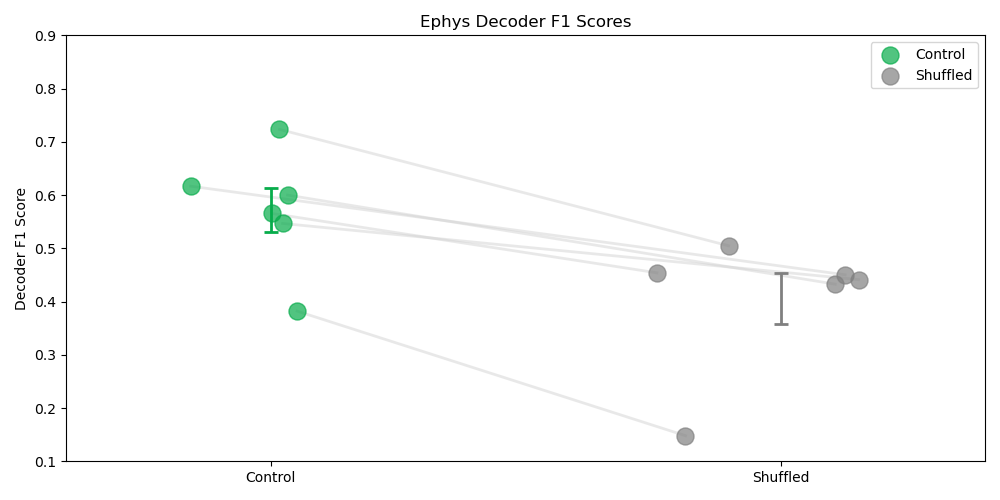

Number of Control animals: 6


In [22]:
# For F1 scores
plot_ephys_decoder(decoder_results, save_dir=figDataSaveDir + '/ephys', filename_prefix='ephys_assembly_SVM')


In [23]:
def assembly_prediction_PPTs(assemblies_data, days=['day2'], context='partner', bin_size=0.05, plot_assemblies=False):
    results = {'control': {}, 'expt': {}}
    print('beginning prediction')
    for group_name, group_data in assemblies_data.items():
        for animal_id, sessions in group_data.items():
            results[group_name][animal_id] = {}
            for day in days:
                session_data = sessions.get(day)
                if session_data and 'activations' in session_data:
                    activations = session_data['activations']
                    num_assemblies = session_data['num_assemblies']
                    num_neurons = session_data['num_neurons']

                    # Print shape of activations matrix
                    print(f"\nProcessing {group_name} - {animal_id} - {day}")
                    print(f"Activations shape: {activations.shape}, Number of assemblies: {num_assemblies}")

                    # Get partner_side from session_data
                    partner_side = session_data.get('partner_side', None)
                    
                    # Replace NaNs in activations with zeros
                    if np.isnan(activations).any():
                        print(f"Replacing NaNs for {animal_id} on {day}")
                        activations = np.nan_to_num(activations)
                    
                    # Check if 'cv' exists in session_data
                    cv = session_data.get('cv', None)
                    if cv is not None:
                        # Determine the event type based on the day and context
                        if day in ['day0', 'day1']:
                            event_type = 'Distance between [ 2 and 1 ] Less Than  50.00 mm'
                        else:
                            side_info = partner_side
                            if side_info:
                                if context == 'partner':
                                    event_type = f'Area:Mouse 1 Center In {side_info} chamber'
                                elif context == 'novel':
                                    opposite_side = 'right' if side_info == 'left' else 'left'
                                    event_type = f'Area:Mouse 1 Center In {opposite_side} chamber'
                                elif context == 'nonsocial':
                                    event_type = [
                                        f'Area:Mouse 1 Center In center chamber'
                                    ]

                        # Filter CV for specified EventType
                        if isinstance(event_type, list):
                            filtered_cv = cv[cv['EventType'].isin(event_type)]
                        else:
                            filtered_cv = cv[cv['EventType'] == event_type]


                        # Generate labels and debug output
                        labels = generate_labels_from_cv_filtered_npx(filtered_cv, activations.shape[1], bin_size=bin_size)

                        # Calculate auROC and determine significant modulation
                        prop_positive, prop_negative, pos_indices, neg_indices, auroc_vals, p_vals = significant_modulation_proportion(
                            activations, labels, num_permutations=5000, threshold=True, significance_level=0.025
                        )
                        
                        if plot_assemblies:
                            # Plot each assembly's activation relative to the labels with AUROC in the title
                            for i, (activation, auroc_val) in enumerate(zip(activations, auroc_vals)):
                                plt.figure(figsize=(15, 4))
                                plt.plot(activation, label=f'Assembly {i} Activation')
                                plt.plot(labels * np.max(activation), label='Labels', linestyle='--', alpha=0.7)
                                plt.title(f'Animal {animal_id} - {group_name} - {day} - Assembly {i} (AUROC: {auroc_val:.3f})')
                                plt.xlabel('Time Bins')
                                plt.ylabel('Activation Level')
                                plt.legend()
                                plt.grid(True)
                                plt.show()

                        
                        prop_total = prop_positive + prop_negative
                        important_neurons = session_data['important_neurons']

                        results[group_name][animal_id][day] = {
                            'positive': prop_positive,
                            'negative': prop_negative,
                            'total': prop_total,
                            'pos_indices': pos_indices,
                            'neg_indices': neg_indices,
                            'auroc_vals': auroc_vals,
                            'p_vals': p_vals,
                            'num_neurons': num_neurons,  # Include number of neurons
                            'important_neurons': important_neurons  # Add important ensemble members
                        }
                    else:
                        # Handle case where 'cv' is missing by returning NaNs or placeholders
                        print(f"Missing 'cv' data for {animal_id} on {day}, returning NaNs.")
                        results[group_name][animal_id][day] = {
                            'positive': np.nan,
                            'negative': np.nan,
                            'total': np.nan,
                            'pos_indices': [],
                            'neg_indices': [],
                            'auroc_vals': [np.nan] * num_assemblies,
                            'p_vals': [np.nan] * num_assemblies,
                            'num_neurons': num_neurons,
                            'important_neurons': session_data['important_neurons']
                        }
                else:
                    print(f"Missing data for {animal_id} on {day}, skipping.")
                    
    return results


In [24]:
assembly_results_partner_day2 = assembly_prediction_PPTs(assemblies_data_day2, bin_size = bin_size, plot_assemblies=False)


beginning prediction

Processing control - 7632 - day2
Activations shape: (12, 37124), Number of assemblies: 12
Missing 'cv' data for 7632 on day2, returning NaNs.

Processing control - 7762 - day2
Activations shape: (5, 37094), Number of assemblies: 5

Processing control - 7763 - day2
Activations shape: (11, 39726), Number of assemblies: 11
Insufficient data points for meaningful AUROC calculation. Returning neutral values.

Processing control - 7772 - day2
Activations shape: (4, 37060), Number of assemblies: 4
Insufficient data points for meaningful AUROC calculation. Returning neutral values.

Processing control - 7816 - day2
Activations shape: (3, 36631), Number of assemblies: 3

Processing control - 7917 - day2
Activations shape: (12, 37681), Number of assemblies: 12

Processing control - 7918 - day2
Activations shape: (4, 36961), Number of assemblies: 4
Insufficient data points for meaningful AUROC calculation. Returning neutral values.


In [25]:
assembly_results_novel_day2 = assembly_prediction_PPTs(assemblies_data_day2, context='novel', bin_size = bin_size, plot_assemblies=False)


beginning prediction

Processing control - 7632 - day2
Activations shape: (12, 37124), Number of assemblies: 12
Missing 'cv' data for 7632 on day2, returning NaNs.

Processing control - 7762 - day2
Activations shape: (5, 37094), Number of assemblies: 5
Insufficient data points for meaningful AUROC calculation. Returning neutral values.
Insufficient data points for meaningful AUROC calculation. Returning neutral values.
Insufficient data points for meaningful AUROC calculation. Returning neutral values.
Insufficient data points for meaningful AUROC calculation. Returning neutral values.

Processing control - 7763 - day2
Activations shape: (11, 39726), Number of assemblies: 11
Insufficient data points for meaningful AUROC calculation. Returning neutral values.

Processing control - 7772 - day2
Activations shape: (4, 37060), Number of assemblies: 4
Insufficient data points for meaningful AUROC calculation. Returning neutral values.

Processing control - 7816 - day2
Activations shape: (3, 

### individual FSI burst

In [26]:
def find_fsi_activation_bins(rate_matrix, z_score_thresh=2.5, consecutive_bins=3):
    """
    Find activation bins for individual FSIs based on z-scored activity.

    Parameters:
    ----------
    rate_matrix : array
        FSI raw firing rates over time (FSIs x time bins).
    z_score_thresh : float
        Threshold for z-scored activity to consider an FSI active.
    consecutive_bins : int
        Minimum number of consecutive bins required for activation.

    Returns:
    -------
    activation_bins : list of lists
        List of activation bins for each FSI (list of start bins).
        Each entry corresponds to an FSI and contains a list of
        starting bins for valid activation periods.
    """
    n_fsis, n_bins = rate_matrix.shape
    activation_bins = []

    for fsi_idx in range(n_fsis):
        # Extract raw activity for the current FSI
        fsi_activity = rate_matrix[fsi_idx]

        # Z-score the activity
        mean_rate = np.mean(fsi_activity)
        std_rate = np.std(fsi_activity)
        if std_rate > 0:
            z_scored_activity = (fsi_activity - mean_rate) / std_rate
        else:
            z_scored_activity = np.zeros_like(fsi_activity)

        # Find bins above the z-score threshold
        above_thresh = z_scored_activity > z_score_thresh

        # Identify consecutive bins above threshold
        valid_start_bins = []
        streak = 0

        for i in range(n_bins):
            if above_thresh[i]:
                streak += 1
                if streak >= consecutive_bins:
                    valid_start_bins.append(i - consecutive_bins + 1)
                    streak = 0  # Reset streak to avoid overlapping clusters
            else:
                streak = 0

        activation_bins.append(valid_start_bins)
    #pdb.set_trace()

    return activation_bins
    
def plot_fsi_burst(rate_data, group_data, animal_id, fsi_idx,  
                   z_score_thresh=2.5, consecutive_bins=3, 
                   analysis_window=1, saveDir=None):
    """
    Plot a burst for a specified FSI in a specified animal with improved visualization and save data to CSV.
    """
    
    bin_size_seconds = 0.05
    day = 'day2'
                                
    if saveDir is not None:
        os.makedirs(saveDir, exist_ok=True)

    # Extract spike and rate data
    session_data = group_data[day][animal_id]
    spike_times = session_data['spike_times']
    spike_clusters = session_data['spike_clusters']
    fsi_ids = rate_data[day][animal_id]['cell_ids']
    fsi_rates = rate_data[day][animal_id]['raw_rates']
    time_bins = rate_data[day][animal_id]['time_bins']

    # Z-score the rates
    z_scored_rates = np.zeros_like(fsi_rates)
    for idx in range(fsi_rates.shape[0]):
        mean_rate = np.mean(fsi_rates[idx])
        std_rate = np.std(fsi_rates[idx])
        if std_rate > 0:
            z_scored_rates[idx] = (fsi_rates[idx] - mean_rate) / std_rate

    # Identify activation bins
    activation_bins = find_fsi_activation_bins(z_scored_rates, z_score_thresh=z_score_thresh, consecutive_bins=consecutive_bins)

    # Check if there are bursts
    if not activation_bins[fsi_idx]:
        print(f"No bursts found for FSI {fsi_idx + 1} in animal {animal_id} on {day}")
        return

    # Use the first burst
    burst_start = activation_bins[fsi_idx][0]
    window_bins = int(analysis_window / bin_size_seconds)
    start_bin = max(0, burst_start - window_bins)
    end_bin = min(len(time_bins), burst_start + window_bins)

    burst_time_start = time_bins[start_bin]
    burst_time_end = time_bins[end_bin]

    # Extract spike times for raster
    fsi_spike_times = spike_times[spike_clusters == fsi_ids[fsi_idx]]
    burst_time_start_samples = int(burst_time_start * 30000)
    burst_time_end_samples = int(burst_time_end * 30000)

    burst_spikes = fsi_spike_times[
        (fsi_spike_times >= burst_time_start_samples) & 
        (fsi_spike_times < burst_time_end_samples)
    ]

    # Convert spike times to seconds relative to burst start
    burst_spikes_seconds = (burst_spikes / 30000) - burst_time_start - analysis_window
    z_scored_rate = z_scored_rates[fsi_idx, start_bin:end_bin]
    relative_time_window = np.linspace(-analysis_window, analysis_window, len(z_scored_rate))

    # Save data to CSV
    csv_data = pd.DataFrame({
        'Time (s)': relative_time_window,
        'Z-scored Rate': z_scored_rate,
    })

    # Save spikes as separate events
    spikes_df = pd.DataFrame({'Spike Times (s)': burst_spikes_seconds})

    if saveDir:
        csv_rate_path = f"{saveDir}/{animal_id}_FSI_{fsi_idx + 1}_Burst_Rate_Data.csv"
        csv_spikes_path = f"{saveDir}/{animal_id}_FSI_{fsi_idx + 1}_Burst_Spike_Data.csv"
        csv_data.to_csv(csv_rate_path, index=False)
        spikes_df.to_csv(csv_spikes_path, index=False)
        print(f"Saved rate data to {csv_rate_path}")
        print(f"Saved spike data to {csv_spikes_path}")

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    # Raster Plot
    ax.eventplot(burst_spikes_seconds, lineoffsets=-2, colors='gray', alpha=0.8, linewidths=1.5, label='Spike Raster')

    # Z-Scored Spike Rate
    ax.plot(relative_time_window, z_scored_rate, label='Z-scored Rate', color='black', linewidth=1.5)
    ax.axhline(y=z_score_thresh, color='red', linestyle='--', linewidth=1, label='Burst Threshold')

    # Formatting
    ax.set_title(f'FSI Burst Analysis (Animal {animal_id}, FSI {fsi_idx + 1})', fontsize=12)
    ax.set_xlim([-analysis_window, analysis_window])
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Z-Score / Raster', fontsize=10)
    ax.legend(loc='upper right', fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    if saveDir:
        plt.savefig(f"{saveDir}/{animal_id}_FSI_{fsi_idx + 1}_Improved_Burst.png", dpi=300)
        plt.savefig(f"{saveDir}/{animal_id}_FSI_{fsi_idx + 1}_Improved_Burst.svg", dpi=300)
    plt.show()





Saved rate data to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/7917_FSI_1_Burst_Rate_Data.csv
Saved spike data to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys/7917_FSI_1_Burst_Spike_Data.csv


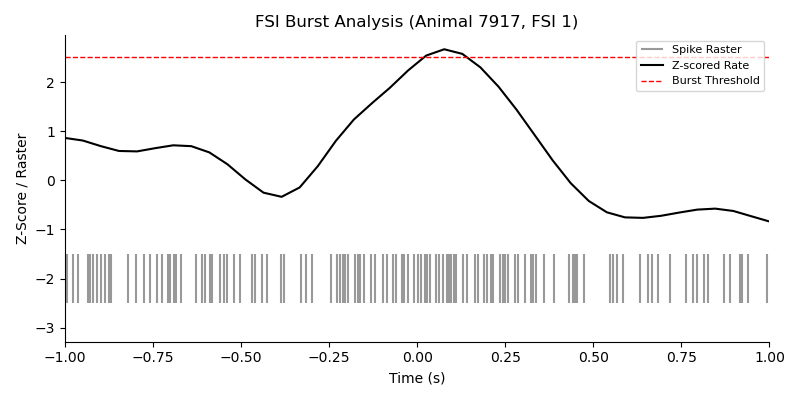

In [27]:
plot_fsi_burst(rate_data, group_data, animal_id = '7917', fsi_idx = 0,  
                         saveDir=figDataSaveDir + '/ephys')


In [28]:
# Create a custom colormap
colors = ['#000000', '#4B2E8D', '#FFFFFF']  # Adjust colors as needed
custom_cmap = LinearSegmentedColormap.from_list('custom_magma', colors, N=256)

def plot_fsi_heatmap_and_summary(rate_data, z_score_thresh=2.5, analysis_window=3, saveDir=None):
    """
    Generate a heatmap of average z-scored activity for each FSI,
    plot the mean ± SEM across FSIs, and save data to a CSV.

    Parameters:
    ----------
    rate_data : dict
        Precomputed rate data from `analyze_rates_all_animals`.
    z_score_thresh : float
        Z-score threshold for identifying bursts.
    analysis_window : float
        Time window (in seconds) around the burst.
    saveDir : str or None
        Directory to save the plots and CSV. If None, plots are only displayed.

    Returns:
    -------
    None
    """
    consecutive_bins = 3

    # Create a custom colormap
    colors = ['#000000', '#4B2E8D', '#FFFFFF']
    custom_cmap = LinearSegmentedColormap.from_list('custom_magma', colors, N=256)

    bin_size_seconds = 0.05
    day = 'day2'
    if saveDir is not None:
        os.makedirs(saveDir, exist_ok=True)

    all_fsi_averages = []
    all_fsi_ids = []

    for animal_id, rate_info in rate_data[day].items():
        print(f"Processing Animal {animal_id} on Day {day}")

        # Extract rates and metadata
        fsi_rates = rate_info['raw_rates']
        time_bins = rate_info['time_bins']

        # Z-score the rates
        z_scored_rates = np.zeros_like(fsi_rates)
        for fsi_idx in range(fsi_rates.shape[0]):
            mean_rate = np.mean(fsi_rates[fsi_idx])
            std_rate = np.std(fsi_rates[fsi_idx])
            if std_rate > 0:
                z_scored_rates[fsi_idx] = (fsi_rates[fsi_idx] - mean_rate) / std_rate

        # Identify activation bins based on z-scored rates
        activation_bins = find_fsi_activation_bins(z_scored_rates, z_score_thresh=z_score_thresh, consecutive_bins=consecutive_bins)

        for fsi_idx, bins in enumerate(activation_bins):
            if not bins:
                continue

            # Align all bursts for this FSI
            fsi_activity_aligned = []
            for burst_start in bins:
                window_bins = int(analysis_window / bin_size_seconds)
                start_bin = max(0, burst_start - window_bins)
                end_bin = min(len(time_bins), burst_start + window_bins)

                # Extract the aligned activity
                aligned_activity = z_scored_rates[fsi_idx, start_bin:end_bin]
                if len(aligned_activity) == int(2 * analysis_window / bin_size_seconds):
                    fsi_activity_aligned.append(aligned_activity)

            # Average across events for this FSI
            if fsi_activity_aligned:
                average_activity = np.mean(fsi_activity_aligned, axis=0)
                all_fsi_averages.append(average_activity)
                all_fsi_ids.append(f"Animal {animal_id} FSI {fsi_idx + 1}")

    # Convert to array for heatmap
    all_fsi_averages = np.array(all_fsi_averages)

    # Save CSV with z-scored data
    time_points = np.linspace(-analysis_window, analysis_window, all_fsi_averages.shape[1])
    df = pd.DataFrame(all_fsi_averages, index=all_fsi_ids, columns=time_points)
    if saveDir:
        csv_path = os.path.join(saveDir, "FSI_Heatmap_Data.csv")
        df.to_csv(csv_path)
        print(f"Saved heatmap data to {csv_path}")

    # Generate heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(
        all_fsi_averages,
        aspect='auto',
        extent=[-analysis_window, analysis_window, 0, len(all_fsi_averages)],
        cmap=custom_cmap,
        origin='lower'
    )
    ax.set_title('FSI Heatmap of Average Z-scored Activity')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('FSIs')
    plt.colorbar(heatmap, label='Z-score')
    if saveDir:
        plt.savefig(f"{saveDir}/FSI_Heatmap.png", dpi=300)
        plt.savefig(f"{saveDir}/FSI_Heatmap.svg", dpi=300)
    plt.show()

    # Generate Mean ± SEM Plot
    mean_activity = np.mean(all_fsi_averages, axis=0)
    sem_activity = np.std(all_fsi_averages, axis=0) / np.sqrt(all_fsi_averages.shape[0])

    time_axis = np.linspace(-analysis_window, analysis_window, mean_activity.shape[0])

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.fill_between(time_axis, mean_activity - sem_activity, mean_activity + sem_activity, color='gray', alpha=0.3, label='SEM')
    ax.plot(time_axis, mean_activity, color='black', label='Mean Z-scored Activity')
    ax.axhline(0, color='red', linestyle='--', label='Baseline')
    ax.set_title('Mean ± SEM of Z-scored FSI Activity')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Z-score')
    ax.legend()
    if saveDir:
        plt.savefig(f"{saveDir}/Mean_SEM_FSI_Activity.png", dpi=300)
        plt.savefig(f"{saveDir}/Mean_SEM_FSI_Activity.svg", dpi=300)
    plt.show()



Processing Animal 7632 on Day day2
Processing Animal 7762 on Day day2
Processing Animal 7763 on Day day2
Processing Animal 7772 on Day day2
Processing Animal 7816 on Day day2
Processing Animal 7917 on Day day2
Processing Animal 7918 on Day day2
Saved heatmap data to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/ephys\FSI_Heatmap_Data.csv


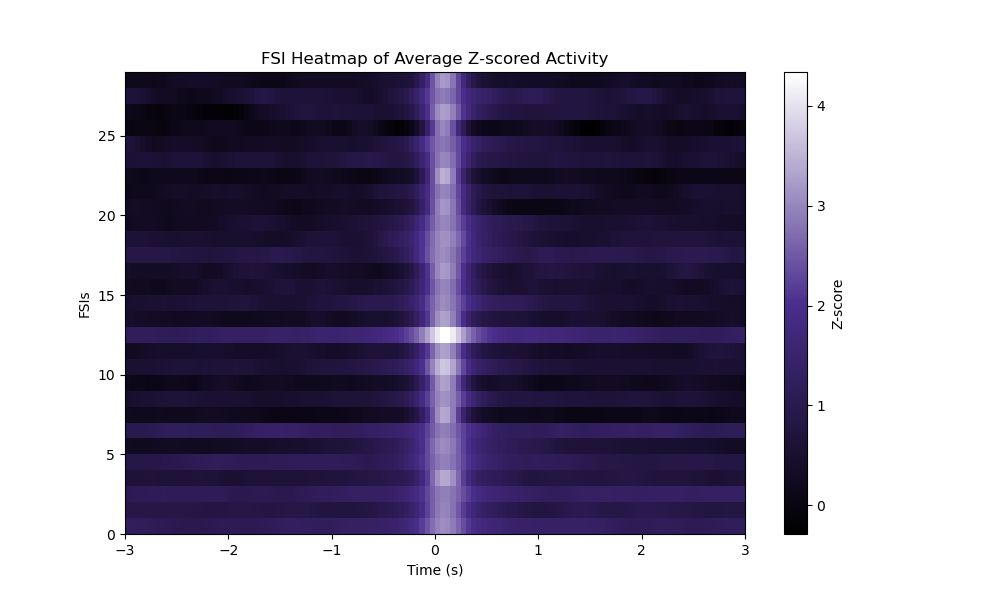

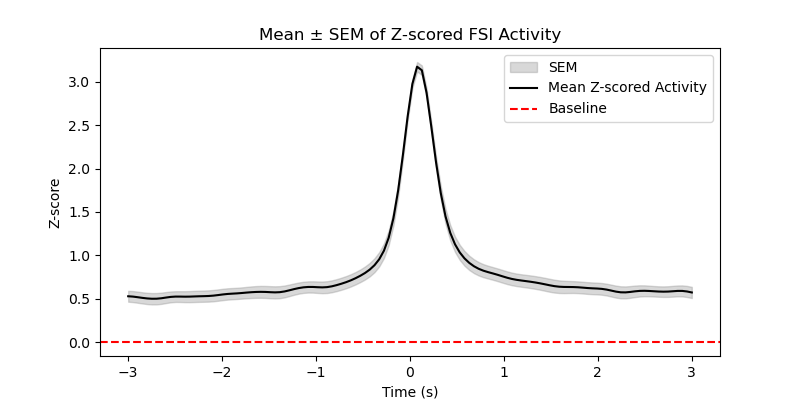

In [29]:
plot_fsi_heatmap_and_summary(
    rate_data=rate_data,          # Precomputed rate data
    saveDir=figDataSaveDir + '/ephys'     # Directory to save the plots (set to None if not saving)
)



### individual FSIs > ensembles

In [30]:
def generate_surrogate_data(activations, n_surrogates=1000):
    """
    Generate surrogate ensemble activity by circular shifting.
    
    Parameters:
    -----------
    activations : np.ndarray
        Original ensemble activations (n_ensembles x n_timepoints)
    n_surrogates : int
        Number of surrogate datasets to generate
        
    Returns:
    --------
    np.ndarray
        Surrogate datasets (n_surrogates x n_ensembles x n_timepoints)
    """
    n_ensembles, n_timepoints = activations.shape
    surrogates = np.zeros((n_surrogates, n_ensembles, n_timepoints))
    
    for surr in range(n_surrogates):
        for ens in range(n_ensembles):
            # Generate random shift amount
            shift = np.random.randint(0, n_timepoints)
            # Circular shift the data
            surrogates[surr, ens] = np.roll(activations[ens], shift)
            
    return surrogates

def plot_fsi_ensemble_relationships(rate_data, assemblies_data, day='day2',
                                    target_animal=None, target_fsi=None,
                                    z_score_thresh=2.5, consecutive_bins=3, 
                                    analysis_window=3, bin_size_seconds=0.05,
                                    n_surrogates=1000, percentile_thresh=99.9,
                                    saveDir=None, suppressPlotting=False):
    """
    Visualize relationships between FSIs and ensemble activation using raw rates,
    with statistical testing against surrogate data.
    """
    if saveDir is not None:
        os.makedirs(saveDir, exist_ok=True)

    all_fsi_averages = []
    all_fsi_surrogates = []

    # Loop through all animals
    for animal_id in rate_data[day].keys():
        print(f"Analyzing Animal {animal_id} on Day {day}")

        rate_info = rate_data[day][animal_id]
        assembly_info = assemblies_data['control'][animal_id][day]

        raw_rates = rate_info['raw_rates']
        time_bins = rate_info['time_bins']
        fsi_ids = rate_info['cell_ids']
        activations = assembly_info['activations']
        n_ensembles = assembly_info['num_assemblies']

        # Z-score ensemble activations
        z_scored_activations = np.zeros_like(activations)
        for i in range(n_ensembles):
            mean_act = np.mean(activations[i])
            std_act = np.std(activations[i])
            z_scored_activations[i] = (activations[i] - mean_act) / std_act

        # Z-score FSI rates
        z_scored_rates = np.zeros_like(raw_rates)
        for fsi_idx in range(raw_rates.shape[0]):
            mean_rate = np.mean(raw_rates[fsi_idx])
            std_rate = np.std(raw_rates[fsi_idx])
            if std_rate > 0:
                z_scored_rates[fsi_idx] = (raw_rates[fsi_idx] - mean_rate) / std_rate

        activation_bins = find_fsi_activation_bins(z_scored_rates, 
                                                z_score_thresh=z_score_thresh, 
                                                consecutive_bins=consecutive_bins)
        
        # Generate surrogate data
        surrogate_activations = generate_surrogate_data(z_scored_activations, 
                                                      n_surrogates=n_surrogates)

        for fsi_idx in range(len(fsi_ids)):
            bins = activation_bins[fsi_idx]
            if not bins:
                continue

            # Compute triggered averages for real data
            ensemble_data = []
            window_bins = int(analysis_window / bin_size_seconds)
            
            for ensemble_idx in range(n_ensembles):
                ensemble_triggers = []
                for burst_start in bins:
                    if burst_start >= window_bins and burst_start + window_bins < len(time_bins):
                        ensemble_triggers.append(
                            z_scored_activations[ensemble_idx, 
                                               burst_start - window_bins:burst_start + window_bins]
                        )
                if ensemble_triggers:
                    ensemble_data.append(np.mean(ensemble_triggers, axis=0))

            # Compute triggered averages for surrogate data
            surrogate_triggers = []
            for surr in range(n_surrogates):
                surr_ensemble_data = []
                for ensemble_idx in range(n_ensembles):
                    surr_triggers = []
                    for burst_start in bins:
                        if burst_start >= window_bins and burst_start + window_bins < len(time_bins):
                            surr_triggers.append(
                                surrogate_activations[surr, ensemble_idx,
                                                    burst_start - window_bins:burst_start + window_bins]
                            )
                    if surr_triggers:
                        surr_ensemble_data.append(np.mean(surr_triggers, axis=0))
                if surr_ensemble_data:
                    surrogate_triggers.append(np.mean(surr_ensemble_data, axis=0))

            if ensemble_data:
                ensemble_data = np.array(ensemble_data)
                mean_ensemble = np.mean(ensemble_data, axis=0)
                all_fsi_averages.append(mean_ensemble)
                
                if surrogate_triggers:
                    surrogate_triggers = np.array(surrogate_triggers)
                    all_fsi_surrogates.append(surrogate_triggers)

            # Plot for target animal and FSI
            if not suppressPlotting and target_animal == animal_id and (target_fsi is None or target_fsi == fsi_idx):
                fig, ax = plt.subplots(figsize=(10, 6))
                relative_time_window = np.linspace(-analysis_window, analysis_window, 
                                                 int(analysis_window * 2 / bin_size_seconds))

                # Plot individual ensembles
                for ensemble_idx, ensemble_trace in enumerate(ensemble_data):
                    ax.plot(relative_time_window, ensemble_trace, color='gray', alpha=0.5)

                # Compute mean and SEM
                mean_ensemble = np.mean(ensemble_data, axis=0)
                sem_ensemble = np.std(ensemble_data, axis=0) / np.sqrt(ensemble_data.shape[0])

                # Compute significance
                surrogate_mean = np.mean(surrogate_triggers, axis=0)
                percentile_high = np.percentile(surrogate_triggers, percentile_thresh, axis=0)
                percentile_low = np.percentile(surrogate_triggers, 100-percentile_thresh, axis=0)
                
                # Find significant timepoints
                sig_above = mean_ensemble > percentile_high
                sig_below = mean_ensemble < percentile_low
                
                # Plot mean and SEM
                ax.fill_between(relative_time_window, mean_ensemble - sem_ensemble, 
                              mean_ensemble + sem_ensemble, color='#07AC4B', 
                              alpha=0.3, label='Mean ± SEM')
                ax.plot(relative_time_window, mean_ensemble, color='#07AC4B', 
                       label='Mean Activity')
                
                # Get plot limits and set up significance bar position
                ymin, ymax = ax.get_ylim()
                y_range = ymax - ymin
                asterisk_height = ymax - y_range * 0.05  # Place asterisks just below top of frame
                
                # Draw significance markers at top of plot
                for t_idx in range(len(relative_time_window)):
                    if sig_above[t_idx] or sig_below[t_idx]:
                        ax.text(relative_time_window[t_idx], asterisk_height, '*', 
                               ha='center', va='bottom', 
                               color='red' if sig_above[t_idx] else 'blue')
                
                # Adjust ylim to make room for asterisks
                ax.set_ylim(ymin, ymax + y_range * 0.1)

                ax.set_title(f'FSI {fsi_idx + 1} Ensemble Activity (Animal {animal_id})')
                ax.set_xlim([-analysis_window, analysis_window])
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Z-Score')
                ax.legend()

                plt.tight_layout()
                
                if saveDir:
                    plt.savefig(f"{saveDir}/{animal_id}_FSI_{fsi_idx + 1}_Ensemble_Activity.png", 
                              dpi=300)
                    plt.savefig(f"{saveDir}/{animal_id}_FSI_{fsi_idx + 1}_Ensemble_Activity.svg", 
                              dpi=300)
                    
                    # Save data
                    results_df = pd.DataFrame({
                        'Time (s)': relative_time_window,
                        'Mean': mean_ensemble,
                        'SEM': sem_ensemble,
                        'Surrogate_Mean': surrogate_mean,
                        'Percentile_High': percentile_high,
                        'Percentile_Low': percentile_low,
                        'Significant_Above': sig_above,
                        'Significant_Below': sig_below
                    })
                    results_df.to_csv(f"{saveDir}/{animal_id}_FSI_{fsi_idx + 1}_Ensemble_Activity.csv", 
                                    index=False)

                plt.show()

    # Plot average across all FSIs with statistical testing
    if not suppressPlotting and all_fsi_averages and all_fsi_surrogates:
        fig, ax = plt.subplots(figsize=(10, 6))
        all_fsi_averages = np.array(all_fsi_averages)
        all_fsi_surrogates = np.array(all_fsi_surrogates)

        # Compute mean and SEM across FSIs
        mean_across_fsis = np.mean(all_fsi_averages, axis=0)
        sem_across_fsis = np.std(all_fsi_averages, axis=0) / np.sqrt(all_fsi_averages.shape[0])

        # Compute surrogate statistics
        surrogate_mean = np.mean(all_fsi_surrogates, axis=(0, 1))
        percentile_99 = np.percentile(all_fsi_surrogates, 99, axis=(0, 1))
        percentile_1 = np.percentile(all_fsi_surrogates, 1, axis=(0, 1))
        
        # Find significant timepoints
        sig_above = mean_across_fsis > percentile_99
        sig_below = mean_across_fsis < percentile_1

        relative_time_window = np.linspace(-analysis_window, analysis_window, 
                                         mean_across_fsis.shape[0])

        # Plot mean with SEM
        ax.fill_between(relative_time_window, mean_across_fsis - sem_across_fsis, 
                       mean_across_fsis + sem_across_fsis, alpha=0.3, 
                       color='#07AC4B', label='Mean ± SEM')
        ax.plot(relative_time_window, mean_across_fsis, color='#07AC4B', 
               label='Mean Activity')
        
        # Get plot limits and set up significance bar position
        ymin, ymax = ax.get_ylim()
        y_range = ymax - ymin
        asterisk_height = ymax - y_range * 0.05  # Place asterisks just below top of frame
        
        # Draw significance markers at top of plot
        for t_idx in range(len(relative_time_window)):
            if sig_above[t_idx] or sig_below[t_idx]:
                ax.text(relative_time_window[t_idx], asterisk_height, '*', 
                       ha='center', va='bottom', 
                       color='red' if sig_above[t_idx] else 'blue')
                
        # Adjust ylim to make room for asterisks
        ax.set_ylim(ymin, ymax + y_range * 0.1)

        ax.set_title('Average Ensemble Activity Across FSIs (All Animals)')
        ax.set_xlim([-analysis_window, analysis_window])
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Z-Score')
        ax.legend()

        plt.tight_layout()
        
        if saveDir:
            plt.savefig(f"{saveDir}/Mean_Ensemble_Activity_Across_FSIs.png", dpi=300)
            plt.savefig(f"{saveDir}/Mean_Ensemble_Activity_Across_FSIs.svg", dpi=300)
            
            # Save results
            results_df = pd.DataFrame({
                'Time (s)': relative_time_window,
                'Mean': mean_across_fsis,
                'SEM': sem_across_fsis,
                'Surrogate_Mean': surrogate_mean,
                'Percentile_High': percentile_high,
                'Percentile_Low': percentile_low,
                'Significant_Above': sig_above,
                'Significant_Below': sig_below
            })
            results_df.to_csv(f"{saveDir}/Mean_Ensemble_Activity_Across_FSIs.csv", 
                            index=False)
            
        plt.show()

    return {
            'all_fsi_averages': all_fsi_averages if len(all_fsi_averages) > 0 else None,
            'all_fsi_surrogates': all_fsi_surrogates if len(all_fsi_surrogates) > 0 else None,
            # Add these new returns:
            'summary_stats': {
                'time': relative_time_window,
                'mean_across_fsis': mean_across_fsis,
                'sem_across_fsis': sem_across_fsis,
                'surrogate_mean': surrogate_mean,
                'percentile_99': percentile_99,
                'percentile_1': percentile_1,
                'sig_above': sig_above,
                'sig_below': sig_below
            } if len(all_fsi_averages) > 0 else None,
            'parameters': {
                'z_score_thresh': z_score_thresh,
                'consecutive_bins': consecutive_bins
            }
        }

Analyzing Animal 7632 on Day day2
Analyzing Animal 7762 on Day day2
Analyzing Animal 7763 on Day day2


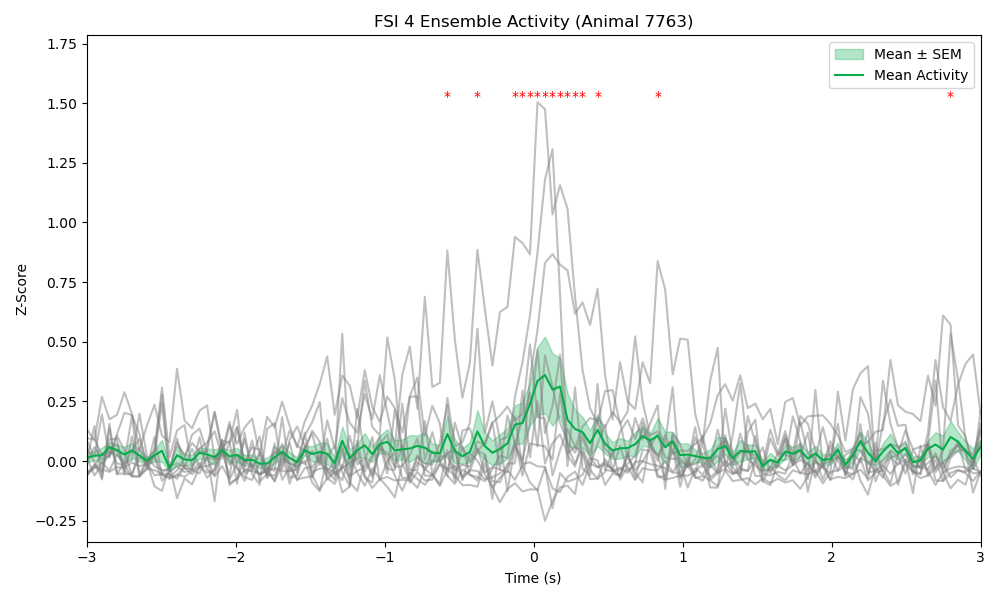

Analyzing Animal 7772 on Day day2
Analyzing Animal 7816 on Day day2
Analyzing Animal 7917 on Day day2
Analyzing Animal 7918 on Day day2


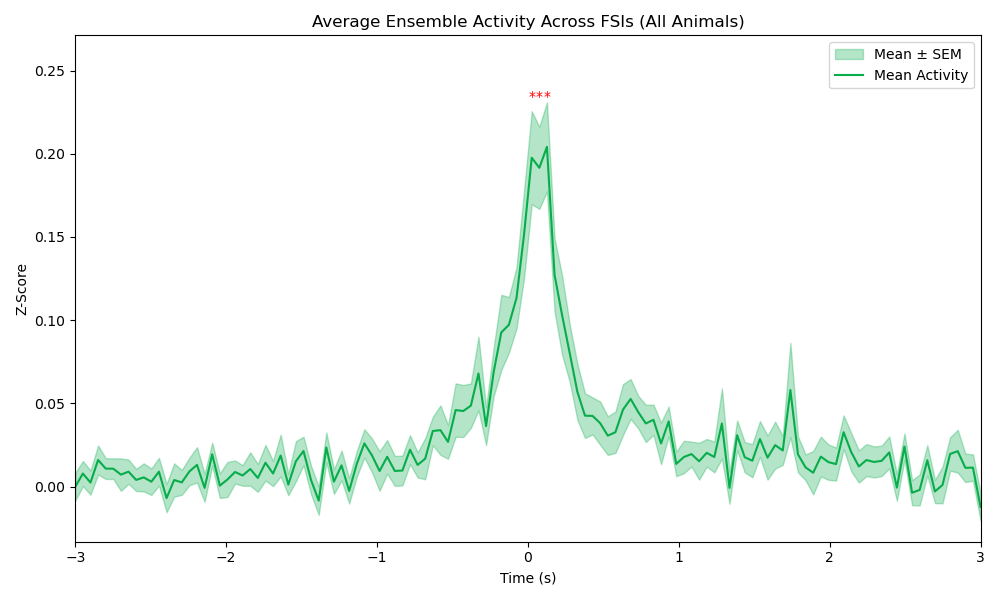

In [31]:
# Plot summary for all FSIs across all animals
fsi_ensemble_data = plot_fsi_ensemble_relationships(rate_data, assemblies_data_day2,
                                target_animal='7763', target_fsi=3,
                                saveDir=figDataSaveDir + '/ephys')


### threshold analysis

Analyzing Animal 7632 on Day day2
Analyzing Animal 7762 on Day day2
Analyzing Animal 7763 on Day day2


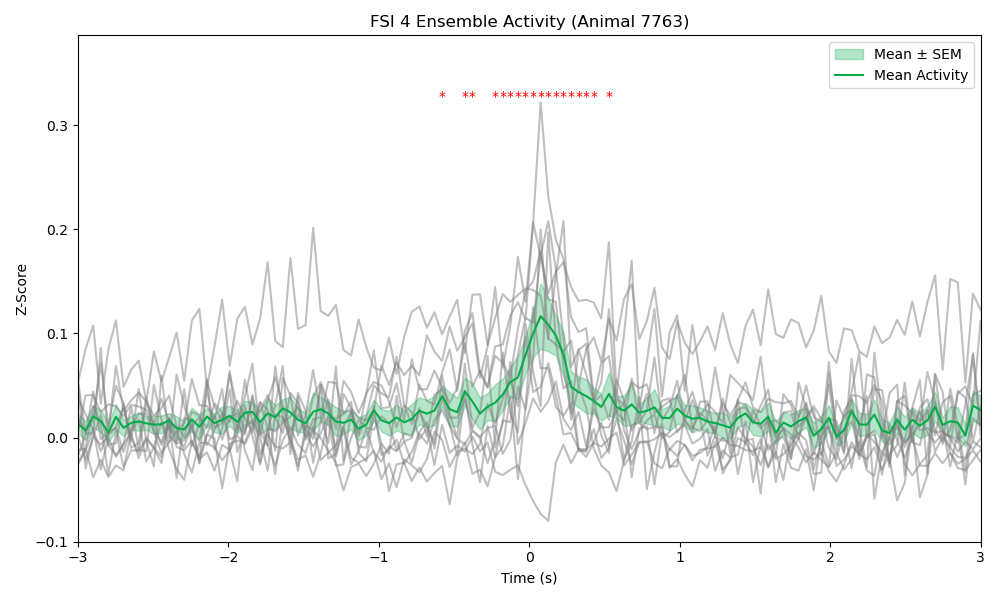

Analyzing Animal 7772 on Day day2
Analyzing Animal 7816 on Day day2
Analyzing Animal 7917 on Day day2
Analyzing Animal 7918 on Day day2


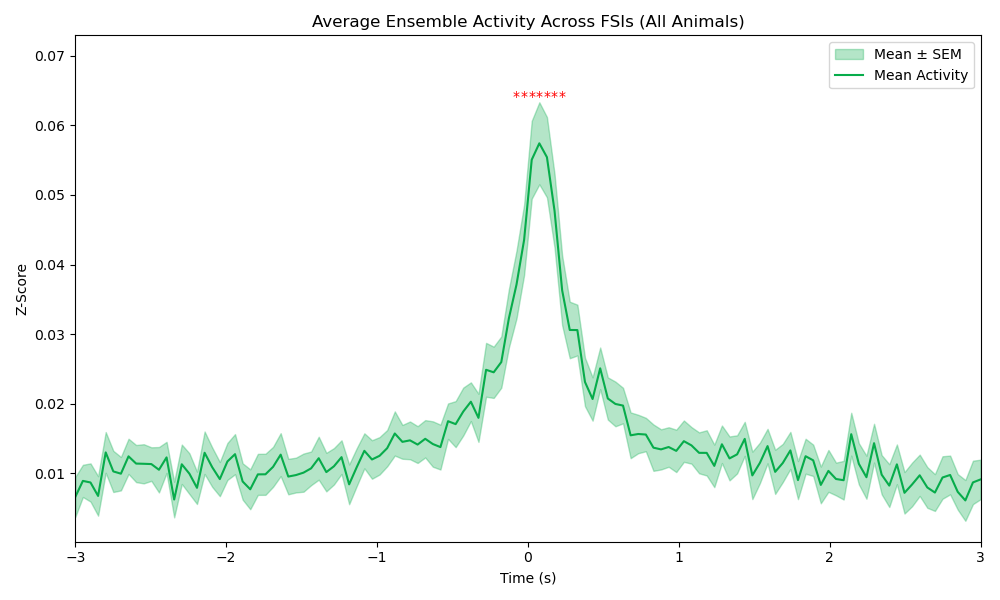

Analyzing Animal 7632 on Day day2
Analyzing Animal 7762 on Day day2
Analyzing Animal 7763 on Day day2


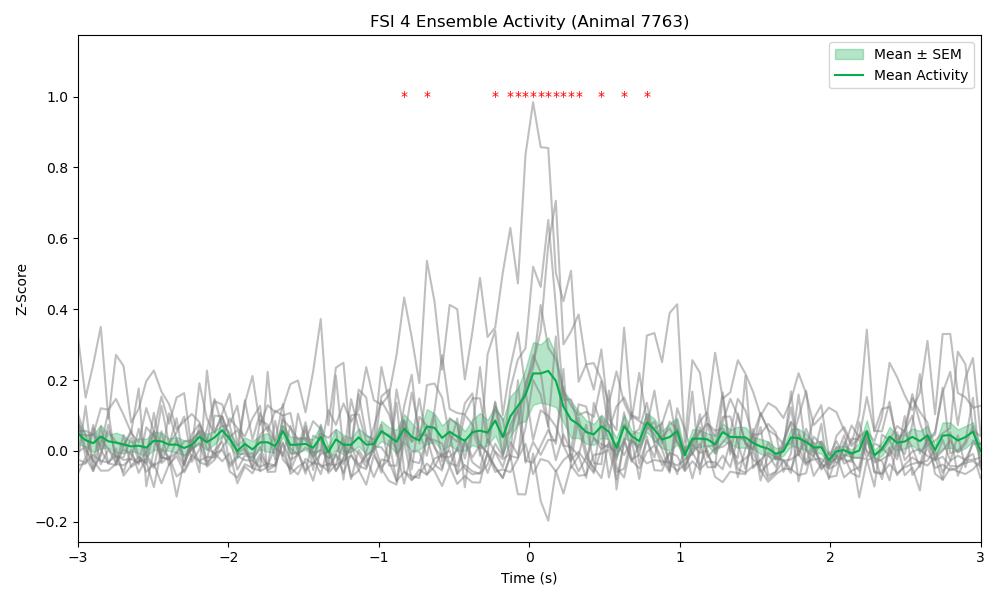

Analyzing Animal 7772 on Day day2
Analyzing Animal 7816 on Day day2
Analyzing Animal 7917 on Day day2
Analyzing Animal 7918 on Day day2


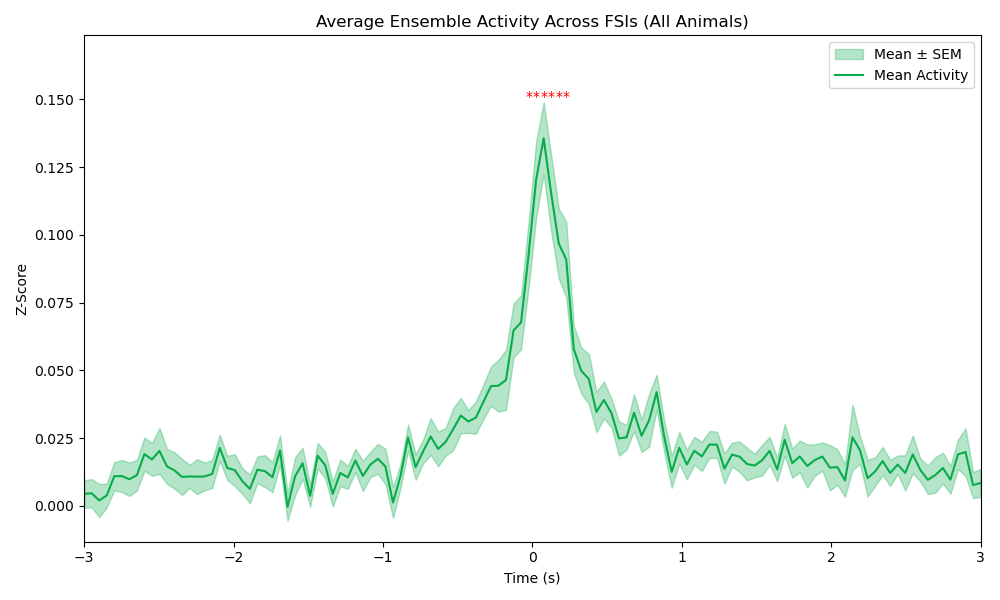

Analyzing Animal 7632 on Day day2
Analyzing Animal 7762 on Day day2
Analyzing Animal 7763 on Day day2


C:\Users\ephys\AppData\Local\Temp\ipykernel_22296\4125663475.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


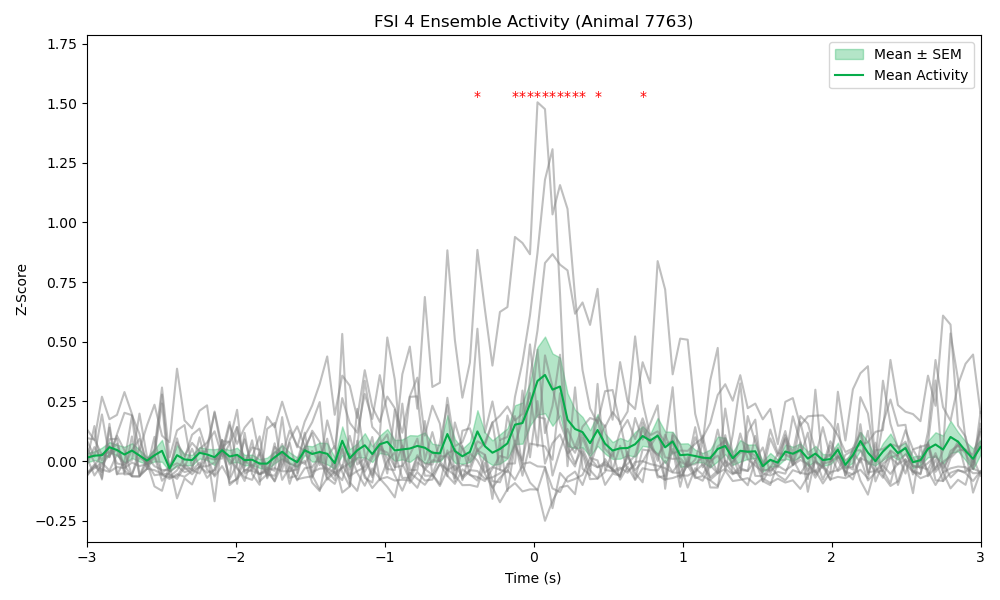

Analyzing Animal 7772 on Day day2
Analyzing Animal 7816 on Day day2
Analyzing Animal 7917 on Day day2
Analyzing Animal 7918 on Day day2


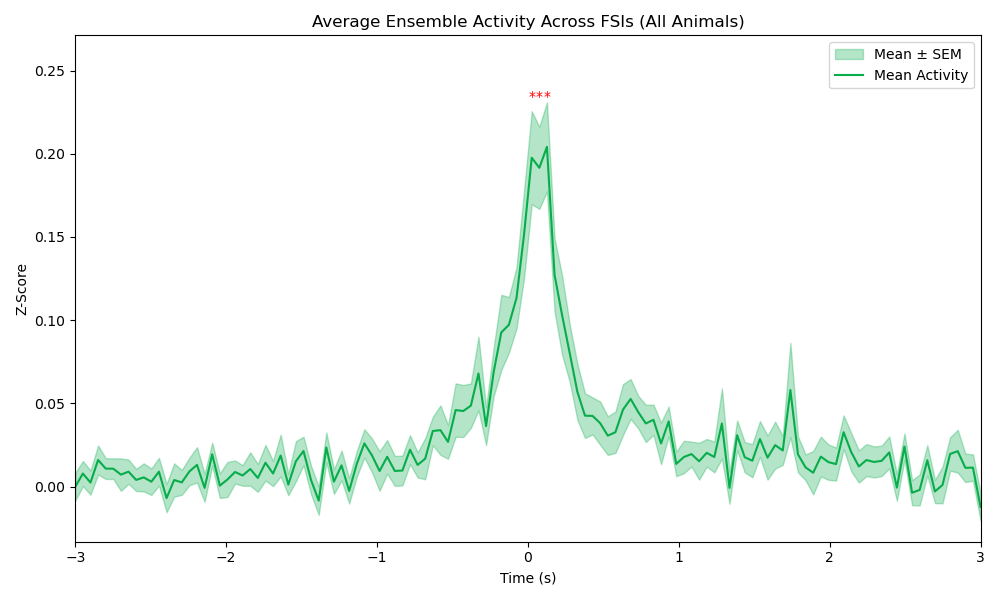

Analyzing Animal 7632 on Day day2
Analyzing Animal 7762 on Day day2
Analyzing Animal 7763 on Day day2


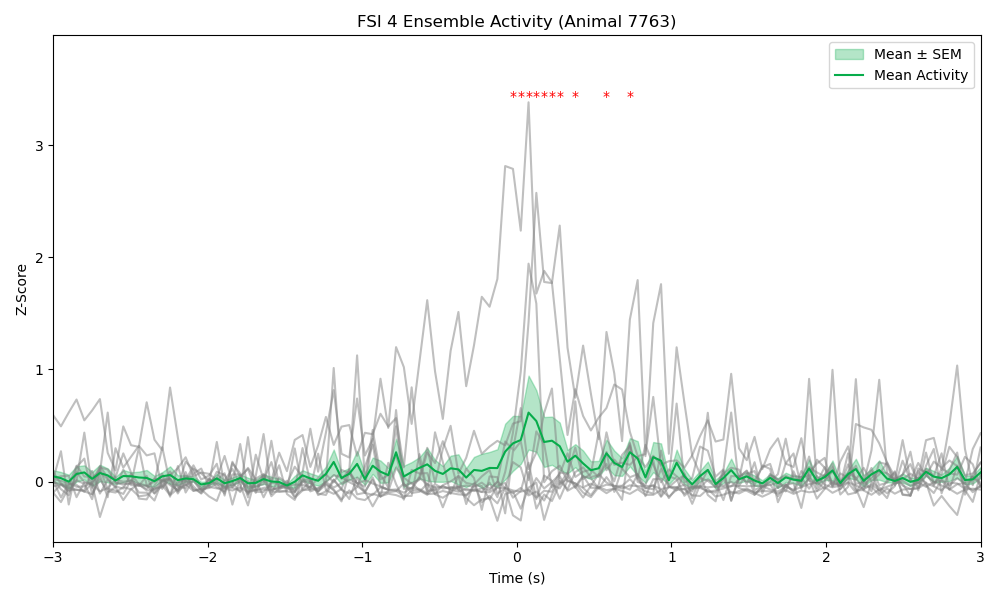

Analyzing Animal 7772 on Day day2
Analyzing Animal 7816 on Day day2
Analyzing Animal 7917 on Day day2
Analyzing Animal 7918 on Day day2


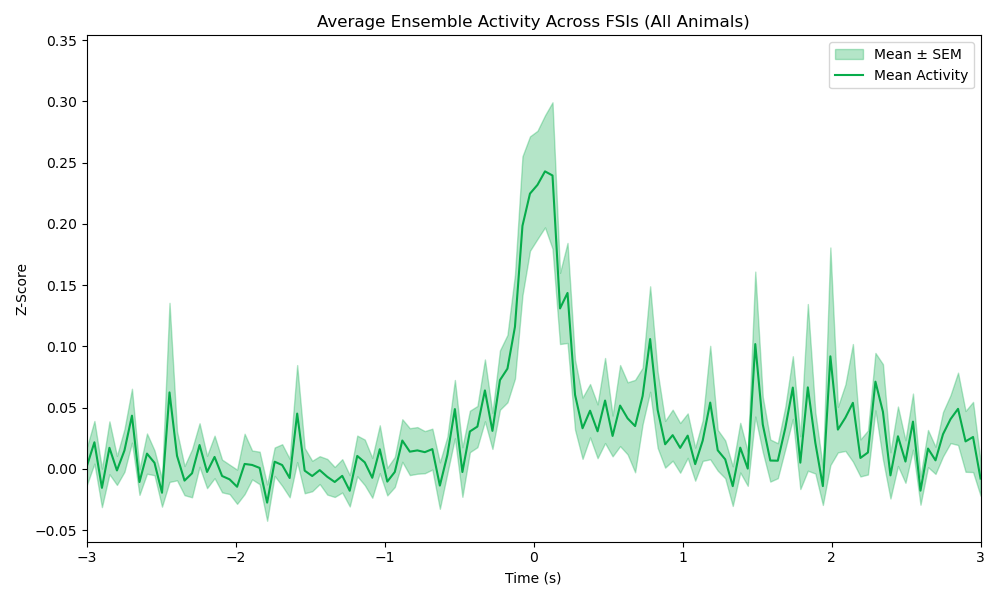

In [35]:
#bug if you run with suppressPlotting=True, b/c time windows dont get created
thresholds = [1, 2, 2.5, 3]
threshold_results = []

for thresh in thresholds:
    result = plot_fsi_ensemble_relationships(rate_data, assemblies_data_day2,
                                           target_animal='7763', target_fsi=3,
                                           z_score_thresh=thresh,
                                           saveDir=figDataSaveDir + '/ephys',
                                            suppressPlotting=False)
    threshold_results.append(result)

type: list index out of range

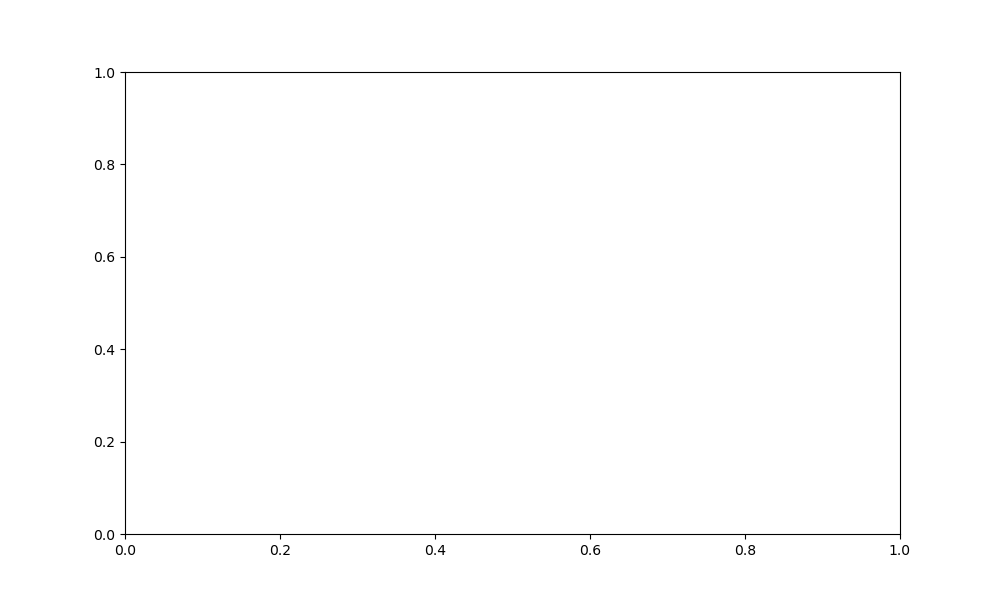

In [33]:
def plot_threshold_comparison(threshold_results, saveDir=None, title='FSI-Ensemble Relationship Across Burst Thresholds'):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create color map from cool (low threshold) to warm (high threshold) 
    colors = plt.cm.viridis(np.linspace(0, 1, len(threshold_results)))
    
    # Collect data for CSV
    csv_data = {
        'Time (s)': threshold_results[0]['summary_stats']['time']
    }
    
    for result, color in zip(threshold_results, colors):
        thresh = result['parameters']['z_score_thresh']
        stats = result['summary_stats']
        
        # Plot mean with SEM
        ax.fill_between(stats['time'],
                       stats['mean_across_fsis'] - stats['sem_across_fsis'],
                       stats['mean_across_fsis'] + stats['sem_across_fsis'],
                       color=color, alpha=0.2)
        ax.plot(stats['time'], stats['mean_across_fsis'],
                color=color, label=f'Z≥{thresh}')
                
        # Add to CSV data
        csv_data[f'Mean_Z{thresh}'] = stats['mean_across_fsis']
        csv_data[f'SEM_Z{thresh}'] = stats['sem_across_fsis']
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean Ensemble Z-Score')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    
    if saveDir:
        os.makedirs(saveDir, exist_ok=True)
        
        # Save figures
        plt.savefig(f"{saveDir}/Threshold_Comparison.png", dpi=300)
        plt.savefig(f"{saveDir}/Threshold_Comparison.svg", dpi=300)
        
        # Save data
        results_df = pd.DataFrame(csv_data)
        results_df.to_csv(f"{saveDir}/Threshold_Comparison.csv", index=False)
    
    plt.show()

# Usage:
plot_threshold_comparison(threshold_results, 
                        saveDir=figDataSaveDir + '/ephys_supp',
                        title='FSI Burst Threshold Effects on Ensemble Activity')

### P vs non-P

In [ ]:
def plot_fsi_ensemble_population_by_type(rate_data, assemblies_data, prediction_results, 
                                       day='day2', z_score_thresh=2.5, consecutive_bins=3, 
                                       analysis_window=3, bin_size_seconds=0.05,
                                       n_surrogates=1000, percentile_thresh=99.9,
                                       saveDir=None):
    """
    Analyze population-level FSI relationships with partner (P) and non-partner (non-P) ensembles.
    
    Parameters:
    -----------
    rate_data : dict
        Dictionary containing FSI firing rate data
    assemblies_data : dict
        Dictionary containing ensemble activation data
    prediction_results : dict
        Output from assembly_prediction_PPTs containing P-ensemble classifications
    """
    # Storage for P and non-P ensembles
    p_ensemble_averages = []
    nonp_ensemble_averages = []
    p_ensemble_surrogates = []
    nonp_ensemble_surrogates = []

    # Loop through all animals
    for animal_id in rate_data[day].keys():
        # Get P-ensemble indices for this animal
        animal_results = prediction_results['control'][animal_id][day]
        p_ensemble_indices = animal_results['pos_indices']
        
        rate_info = rate_data[day][animal_id]
        assembly_info = assemblies_data['control'][animal_id][day]

        raw_rates = rate_info['raw_rates']
        time_bins = rate_info['time_bins']
        fsi_ids = rate_info['cell_ids']
        activations = assembly_info['activations']
        n_ensembles = assembly_info['num_assemblies']

        # Z-score ensemble activations
        z_scored_activations = np.zeros_like(activations)
        for i in range(n_ensembles):
            mean_act = np.mean(activations[i])
            std_act = np.std(activations[i])
            z_scored_activations[i] = (activations[i] - mean_act) / std_act

        # Z-score FSI rates
        z_scored_rates = np.zeros_like(raw_rates)
        for fsi_idx in range(raw_rates.shape[0]):
            mean_rate = np.mean(raw_rates[fsi_idx])
            std_rate = np.std(raw_rates[fsi_idx])
            if std_rate > 0:
                z_scored_rates[fsi_idx] = (raw_rates[fsi_idx] - mean_rate) / std_rate

        activation_bins = find_fsi_activation_bins(z_scored_rates, 
                                                z_score_thresh=z_score_thresh, 
                                                consecutive_bins=consecutive_bins)
        
        # Generate surrogate data
        surrogate_activations = generate_surrogate_data(z_scored_activations, 
                                                      n_surrogates=n_surrogates)

        # Process each FSI
        for fsi_idx in range(len(fsi_ids)):
            bins = activation_bins[fsi_idx]
            if not bins:
                continue

            window_bins = int(analysis_window / bin_size_seconds)
            
            # Separate P and non-P ensemble data
            p_data = []
            nonp_data = []
            
            # Process real data
            for ensemble_idx in range(n_ensembles):
                ensemble_triggers = []
                for burst_start in bins:
                    if burst_start >= window_bins and burst_start + window_bins < len(time_bins):
                        ensemble_triggers.append(
                            z_scored_activations[ensemble_idx, 
                                               burst_start - window_bins:burst_start + window_bins]
                        )
                if ensemble_triggers:
                    mean_trigger = np.mean(ensemble_triggers, axis=0)
                    if ensemble_idx in p_ensemble_indices:
                        p_data.append(mean_trigger)
                    else:
                        nonp_data.append(mean_trigger)

            # Process surrogate data
            p_surrogates = []
            nonp_surrogates = []
            
            for surr in range(n_surrogates):
                p_surr_data = []
                nonp_surr_data = []
                
                for ensemble_idx in range(n_ensembles):
                    surr_triggers = []
                    for burst_start in bins:
                        if burst_start >= window_bins and burst_start + window_bins < len(time_bins):
                            surr_triggers.append(
                                surrogate_activations[surr, ensemble_idx,
                                                    burst_start - window_bins:burst_start + window_bins]
                            )
                    
                    if surr_triggers:
                        mean_surr = np.mean(surr_triggers, axis=0)
                        if ensemble_idx in p_ensemble_indices:
                            p_surr_data.append(mean_surr)
                        else:
                            nonp_surr_data.append(mean_surr)
                
                if p_surr_data:
                    p_surrogates.append(np.mean(p_surr_data, axis=0))
                if nonp_surr_data:
                    nonp_surrogates.append(np.mean(nonp_surr_data, axis=0))

            # Store results
            if p_data:
                p_ensemble_averages.append(np.mean(p_data, axis=0))
            if nonp_data:
                nonp_ensemble_averages.append(np.mean(nonp_data, axis=0))
            if p_surrogates:
                p_ensemble_surrogates.append(np.array(p_surrogates))
            if nonp_surrogates:
                nonp_ensemble_surrogates.append(np.array(nonp_surrogates))

    
    # Plot population comparison
    if p_ensemble_averages and nonp_ensemble_averages:
        fig, ax = plt.subplots(figsize=(10, 6))
        relative_time_window = np.linspace(-analysis_window, analysis_window, 
                                         p_ensemble_averages[0].shape[0])
        
        # Convert to arrays
        p_averages = np.array(p_ensemble_averages)
        nonp_averages = np.array(nonp_ensemble_averages)
        p_surrogates = np.array(p_ensemble_surrogates)
        nonp_surrogates = np.array(nonp_ensemble_surrogates)
        
        # Calculate statistics for both types
        p_mean = np.mean(p_averages, axis=0)
        p_sem = np.std(p_averages, axis=0) / np.sqrt(p_averages.shape[0])
        p_surrogate_mean = np.mean(p_surrogates, axis=(0, 1))
        p_percentile_high = np.percentile(p_surrogates, percentile_thresh, axis=(0, 1))
        p_percentile_low = np.percentile(p_surrogates, 100-percentile_thresh, axis=(0, 1))
        
        nonp_mean = np.mean(nonp_averages, axis=0)
        nonp_sem = np.std(nonp_averages, axis=0) / np.sqrt(nonp_averages.shape[0])
        nonp_surrogate_mean = np.mean(nonp_surrogates, axis=(0, 1))
        nonp_percentile_high = np.percentile(nonp_surrogates, percentile_thresh, axis=(0, 1))
        nonp_percentile_low = np.percentile(nonp_surrogates, 100-percentile_thresh, axis=(0, 1))
        
        # Find significant timepoints
        p_sig_above = p_mean > p_percentile_high
        p_sig_below = p_mean < p_percentile_low
        nonp_sig_above = nonp_mean > nonp_percentile_high
        nonp_sig_below = nonp_mean < nonp_percentile_low
        
        # Print significant timepoints
        print("\nSignificant timepoints for Partner Ensembles:")
        sig_times_p = relative_time_window[p_sig_above | p_sig_below]
        sig_values_p = p_mean[p_sig_above | p_sig_below]
        sig_direction_p = ['above' if above else 'below' for above, below in 
                          zip(p_sig_above[p_sig_above | p_sig_below], 
                              p_sig_below[p_sig_above | p_sig_below])]
        
        for time, value, direction in zip(sig_times_p, sig_values_p, sig_direction_p):
            print(f"Time: {time:.3f}s, Value: {value:.3f}, Direction: {direction}")
            
        print("\nSignificant timepoints for Non-Partner Ensembles:")
        sig_times_nonp = relative_time_window[nonp_sig_above | nonp_sig_below]
        sig_values_nonp = nonp_mean[nonp_sig_above | nonp_sig_below]
        sig_direction_nonp = ['above' if above else 'below' for above, below in 
                             zip(nonp_sig_above[nonp_sig_above | nonp_sig_below], 
                                 nonp_sig_below[nonp_sig_above | nonp_sig_below])]
        
        for time, value, direction in zip(sig_times_nonp, sig_values_nonp, sig_direction_nonp):
            print(f"Time: {time:.3f}s, Value: {value:.3f}, Direction: {direction}")
        
        # Plot Partner ensembles
        ax.fill_between(relative_time_window, p_mean - p_sem, p_mean + p_sem,
                       color='#0E8BA8', alpha=0.3)
        ax.plot(relative_time_window, p_mean, color='#0E8BA8', 
               label='Partner Ensembles', linewidth=2)
        
        # Plot Non-Partner ensembles
        ax.fill_between(relative_time_window, nonp_mean - nonp_sem, nonp_mean + nonp_sem,
                       color='#CC2128', alpha=0.3)
        ax.plot(relative_time_window, nonp_mean, color='#CC2128', 
               label='Non-Partner Ensembles', linewidth=2)
        
        # Add significance markers
        ymin, ymax = ax.get_ylim()
        y_range = ymax - ymin
        
        
        ax.set_ylim(ymin, ymax + y_range * 0.1)
        ax.set_title('Average Ensemble Activity Across FSIs (All Animals)')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Z-Score')
        ax.legend()
        plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        
        if saveDir:
            plt.savefig(f"{saveDir}/Population_Ensemble_Comparison_Overlay.png", dpi=300)
            plt.savefig(f"{saveDir}/Population_Ensemble_Comparison_Overlay.svg", dpi=300)
            
            # Save results
            results_df = pd.DataFrame({
                'Time (s)': relative_time_window,
                'P_Ensemble_Mean': p_mean,
                'P_Ensemble_SEM': p_sem,
                'NonP_Ensemble_Mean': nonp_mean,
                'NonP_Ensemble_SEM': nonp_sem,
            })
            results_df.to_csv(f"{saveDir}/Population_Ensemble_Comparison_Overlay.csv", 
                            index=False)
        
        plt.show()

    return {
        'p_ensemble_averages': np.array(p_ensemble_averages) if p_ensemble_averages else None,
        'nonp_ensemble_averages': np.array(nonp_ensemble_averages) if nonp_ensemble_averages else None,
        'p_ensemble_surrogates': np.array(p_ensemble_surrogates) if p_ensemble_surrogates else None,
        'nonp_ensemble_surrogates': np.array(nonp_ensemble_surrogates) if nonp_ensemble_surrogates else None,
        'statistics': {
            'p_significant_times': sig_times_p.tolist() if 'sig_times_p' in locals() else None,
            'p_significant_values': sig_values_p.tolist() if 'sig_values_p' in locals() else None,
            'nonp_significant_times': sig_times_nonp.tolist() if 'sig_times_nonp' in locals() else None,
            'nonp_significant_values': sig_values_nonp.tolist() if 'sig_values_nonp' in locals() else None
        }
    }

In [ ]:

population_results = plot_fsi_ensemble_population_by_type(
    rate_data=rate_data,
    assemblies_data=assemblies_data_day2,
    prediction_results=assembly_results_partner_day2,
    saveDir=figDataSaveDir + '/ephys_supp'
)

### single example pop bursts

In [ ]:
def find_population_bursts(rate_matrix, bin_size_seconds=0.05, 
                         min_fsi_percent=100, z_score_thresh=2.5, 
                         consecutive_bins=3, min_burst_separation=3,
                         min_fsi_count=3):
    """
    Find periods of coordinated FSI activation
    
    Parameters:
    -----------
    rate_matrix : array
        FSI rates over time (FSIs x time bins)
    bin_size_seconds : float
        Size of time bins in seconds
    min_fsi_percent : float
        Minimum percentage of FSIs that must be active (0-100)
    z_score_thresh : float
        Number of standard deviations above mean to count as active
    consecutive_bins : int
        Number of consecutive bins required for burst
    min_burst_separation : float
        Minimum separation between bursts in seconds
    min_fsi_count : int
        Minimum number of FSIs required for analysis
    
    Returns:
    --------
    burst_times : list of tuples
        Start and end times of each burst in seconds, or empty list if not enough FSIs
    burst_mask : array
        Boolean array marking burst periods, or zeros if not enough FSIs
    """
    n_fsis, n_bins = rate_matrix.shape
                             
    # Check if we have enough FSIs
    if n_fsis < min_fsi_count:
        raise ValueError(f"Only {n_fsis} FSIs found (minimum {min_fsi_count} required)")
    
    
    # Check if we have enough FSIs
    if n_fsis < min_fsi_count:
        print(f"Warning: Only {n_fsis} FSIs (minimum {min_fsi_count} required)")
        return [], np.zeros(n_bins, dtype=bool)
    
    min_active_fsis = int(np.ceil(n_fsis * min_fsi_percent / 100))
    min_separation_bins = int(min_burst_separation / bin_size_seconds)
    
    # Z-score each FSI's activity
    z_scored = np.zeros_like(rate_matrix)
    for i in range(n_fsis):
        mean_rate = np.mean(rate_matrix[i])
        std_rate = np.std(rate_matrix[i])
        if std_rate > 0:
            z_scored[i] = (rate_matrix[i] - mean_rate) / std_rate
    
    # For each time bin, count FSIs exceeding threshold
    active_counts = np.sum(z_scored > z_score_thresh, axis=0)
    population_active = active_counts >= min_active_fsis
    
    # Find periods of consecutive activation
    burst_mask = np.zeros(n_bins, dtype=bool)
    current_streak = 0
    
    for i in range(n_bins):
        if population_active[i]:
            current_streak += 1
            if current_streak >= consecutive_bins:
                burst_mask[i-consecutive_bins+1:i+1] = True
        else:
            current_streak = 0
    
    # Convert to burst times and ensure minimum separation
    burst_starts = []
    burst_ends = []
    in_burst = False
    last_end = -min_separation_bins
    
    for i in range(n_bins):
        if burst_mask[i] and not in_burst and (i - last_end) >= min_separation_bins:
            burst_starts.append(i)
            in_burst = True
        elif not burst_mask[i] and in_burst:
            burst_ends.append(i)
            last_end = i
            in_burst = False
    
    if in_burst:
        burst_ends.append(n_bins)
    
    # Convert to seconds
    burst_times = [(start * bin_size_seconds, end * bin_size_seconds) 
                   for start, end in zip(burst_starts, burst_ends)]
    
    return burst_times, burst_mask
                             


# Create custom colormaps
colors = ['#000000', '#4B2E8D', '#FFFFFF']
custom_cmap = LinearSegmentedColormap.from_list('custom_magma', colors, N=256)


# Define a broader but exactly 10-color palette focusing on greens and complementary colors
broad_color_palette = [
    '#A7F3D0',  # Very Light Green
    '#34D399',  # Normal Green
    '#065F46',  # Dark Green
    '#2DD4BF',  # Teal
    '#06B6D4',  # Cyan
    '#0891B2',  # Deep Cyan
    '#3B82F6',  # Blue
    '#FB923C',  # Orange
    '#F97316',  # Dark Orange
    '#EA580C'   # Burnt Orange
]

def analyze_and_plot_burst_activity_example(rate_data, assemblies_data, day='day2',
                                    min_fsi_percent=50, z_score_thresh=2, 
                                    consecutive_bins=3, min_burst_separation=3,
                                    bin_size_seconds=0.05, saveDir=None,
                                    animal_id_filter=None,
                                    time_window=None):
    if saveDir is not None:
        os.makedirs(saveDir, exist_ok=True)

    rate_animals = set(rate_data[day].keys())
    assembly_animals = set(assemblies_data['control'].keys())
    common_animals = rate_animals.intersection(assembly_animals)
    
    if animal_id_filter is not None:
        if animal_id_filter not in common_animals:
            raise ValueError(f"Animal {animal_id_filter} not found in dataset")
        common_animals = [animal_id_filter]
    
    for animal_id in common_animals:
        if assemblies_data['control'][animal_id] == 'none':
            print(f"No assemblies found for {animal_id}")
            continue
    
        # Use a copy to avoid in-place modification
        rate_info = copy.deepcopy(rate_data[day][animal_id])
        assembly_info = assemblies_data['control'][animal_id][day]
    
        if time_window is not None:
            start_time, end_time = time_window
            start_idx = int(start_time / bin_size_seconds)
            end_idx = int(end_time / bin_size_seconds)
    
            # Check bounds before slicing
            if start_idx >= len(rate_info['time_bins']) or end_idx > len(rate_info['time_bins']):
                raise ValueError(f"Time window {time_window} exceeds available data range.")
            
            rate_info['raw_rates'] = rate_info['raw_rates'][:, start_idx:end_idx]
            rate_info['time_bins'] = rate_info['time_bins'][start_idx:end_idx]
            activations = assembly_info['activations'][:, start_idx:end_idx]

        # Z-score the raw rates for each neuron
        z_scored_rates = np.zeros_like(rate_info['raw_rates'])
        for i in range(rate_info['raw_rates'].shape[0]):
            mean_rate = np.mean(rate_info['raw_rates'][i])
            std_rate = np.std(rate_info['raw_rates'][i])
            if std_rate > 0:  # Avoid division by zero
                z_scored_rates[i] = (rate_info['raw_rates'][i] - mean_rate) / std_rate
            else:
                z_scored_rates[i] = np.zeros_like(rate_info['raw_rates'][i])

        n_assemblies = assembly_info['num_assemblies']

        # Z-score assembly activations
        z_scored_activations = np.zeros_like(activations)
        for i in range(n_assemblies):
            mean_act = np.mean(activations[i])
            std_act = np.std(activations[i])
            if std_act > 0:  # Avoid division by zero
                z_scored_activations[i] = (activations[i] - mean_act) / std_act
            else:
                z_scored_activations[i] = np.zeros_like(activations[i])

        # Create figure with adjusted gridspec for colorbar
        fig = plt.figure(figsize=(14, 8))  # Increased width to accommodate colorbar
        gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[3, 2])
        
        # Rate panel
        ax_rates = fig.add_subplot(gs[0, 0])
        extent = [time_window[0], time_window[1], -0.5, len(rate_info['cell_ids']) - 0.5] if time_window else \
                 [0, rate_info['time_bins'][-1], -0.5, len(rate_info['cell_ids']) - 0.5]
        
        # Use z-scored rates instead of normalized rates
        im = ax_rates.imshow(z_scored_rates, 
                           aspect='auto', 
                           extent=extent,
                           origin='lower', 
                           cmap=custom_cmap) 
        
        # Add colorbar with z-score label
        cax = fig.add_subplot(gs[0, 1])
        plt.colorbar(im, cax=cax, label='Z-score')
        
        ax_rates.set_ylabel('FSI Neuron')
        ax_rates.set_title(f'Neural Activity with FSI Bursts - {animal_id} {day}')
        ax_rates.set_xlim(*time_window) if time_window else ax_rates.set_xlim(0, rate_info['time_bins'][-1])

        # Assembly panel
        ax_assembly = fig.add_subplot(gs[1, 0], sharex=ax_rates)
        for i, color in enumerate(broad_color_palette[:n_assemblies]):
            ax_assembly.plot(rate_info['time_bins'], z_scored_activations[i], color=color, label=f'Assembly {i+1}')
        
        ax_assembly.set_xlabel('Time (seconds)')
        ax_assembly.set_ylabel('Assembly Activity\n(Z-score)')
        ax_assembly.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        if saveDir:
            fig.savefig(f"{saveDir}/{animal_id}_{day}_multifsi_ensemble_activity.svg", format='svg', bbox_inches='tight')
            fig.savefig(f"{saveDir}/{animal_id}_{day}_multifsi_ensemble_activity.png", format='png', bbox_inches='tight', dpi=300)
        plt.show()

        # Save CSVs
        if saveDir:
            fsi_activity_path = os.path.join(saveDir, f"{animal_id}_{day}_multifsi_ensemble_activity_FSIs.csv")
            pd.DataFrame(z_scored_rates).to_csv(fsi_activity_path, index=False)
            
            ensemble_activity_path = os.path.join(saveDir, f"{animal_id}_{day}_multifsi_ensemble_activity_ensembles.csv")
            pd.DataFrame(z_scored_activations).to_csv(ensemble_activity_path, index=False)
            print(f"Saved FSI activity to {fsi_activity_path}")
            print(f"Saved ensemble activity to {ensemble_activity_path}")

In [ ]:
# Note - these parameters have no influence on this plotting. Are remnants from previous 
# functions. 
analysis_results = analyze_and_plot_burst_activity_example(
    rate_data=rate_data,
    assemblies_data=assemblies_data,
    animal_id_filter='7763', 
    time_window=(621,629),  
    min_fsi_percent=50,
    z_score_thresh=1.5,
    consecutive_bins=1,
    min_burst_separation=1,
    bin_size_seconds=0.05,
    saveDir=figDataSaveDir + '/ephys'
)


### regression approach

In [39]:


def find_ensemble_activation_bins(activity, z_score_thresh=2.5, consecutive_bins=3):
    """
    Find activation bins for each ensemble using same criteria as FSIs
    """
    n_ensembles = activity.shape[0]
    activation_bins = []
    
    for ens_idx in range(n_ensembles):
        # Find bins where activity exceeds threshold
        thresh_bins = np.where(activity[ens_idx] > z_score_thresh)[0]
        
        # Find sequences of consecutive bins
        sequences = []
        if len(thresh_bins) > 0:
            sequence = [thresh_bins[0]]
            for bin_idx in thresh_bins[1:]:
                if bin_idx == sequence[-1] + 1:
                    sequence.append(bin_idx)
                else:
                    if len(sequence) >= consecutive_bins:
                        sequences.append(sequence[0])  # Store start of sequence
                    sequence = [bin_idx]
            if len(sequence) >= consecutive_bins:
                sequences.append(sequence[0])
                
        activation_bins.append(sequences)
        
    return activation_bins

def analyze_fsi_ensemble_relationships(rate_data, assemblies_data, day='day2', 
                                     z_score_thresh=2.5, consecutive_bins=3,
                                     min_fsis=3, pre_burst_bins=1, post_burst_bins=1):
    """
    For each ensemble's activation periods, analyze how FSIs predict its activity
    """
    rate_animals = set(rate_data[day].keys())
    assembly_animals = set(assemblies_data['control'].keys())
    common_animals = rate_animals.intersection(assembly_animals)
    
    results = {}
    
    for animal_id in common_animals:
        if assemblies_data['control'][animal_id] == 'none':
            print(f"No assemblies found for {animal_id}")
            continue
            
        rate_info = copy.deepcopy(rate_data[day][animal_id])
        assembly_info = assemblies_data['control'][animal_id][day]
        
        n_fsis = rate_info['normalized_rates'].shape[0]
        if n_fsis < min_fsis:
            print(f"Skipping {animal_id}: only {n_fsis} FSIs")
            continue
            
        print(f"\nAnalyzing animal {animal_id}")
        
        # Z-score ensemble activations
        activations = assembly_info['activations']
        n_ensembles = activations.shape[0]
        z_scored_activations = np.zeros_like(activations)
        for i in range(n_ensembles):
            mean_act = np.mean(activations[i])
            std_act = np.std(activations[i])
            if std_act > 0:
                z_scored_activations[i] = (activations[i] - mean_act) / std_act
        
        # Find activation bins for each ensemble
        ensemble_activation_bins = find_ensemble_activation_bins(
            z_scored_activations,
            z_score_thresh=z_score_thresh,
            consecutive_bins=consecutive_bins
        )
        
        baseline_r2s = np.zeros(n_ensembles)
        r2_changes = np.zeros((n_ensembles, n_fsis))
        n_timepoints = np.zeros(n_ensembles)
        
        # Analyze each ensemble separately
        for ens_idx in range(n_ensembles):
            # Get timepoints when this ensemble is active
            activation_timepoints = set()
            for burst_start in ensemble_activation_bins[ens_idx]:
                for offset in range(-pre_burst_bins, post_burst_bins):
                    timepoint = burst_start + offset
                    if 0 <= timepoint < activations.shape[1]:
                        activation_timepoints.add(timepoint)
            
            if not activation_timepoints:
                print(f"No activation periods found for ensemble {ens_idx+1}")
                continue
                
            activation_timepoints = sorted(list(activation_timepoints))
            n_timepoints[ens_idx] = len(activation_timepoints)
            
            # Get FSI activity (X) and this ensemble's activity (Y) during activation periods
            X = rate_info['normalized_rates'][:, activation_timepoints].T
            Y = activations[ens_idx, activation_timepoints]
            
            # Fit full model
            reg = LinearRegression()
            reg.fit(X, Y)
            y_pred = reg.predict(X)
            baseline_r2s[ens_idx] = r2_score(Y, y_pred)
            
            # Dropout analysis
            for fsi_idx in range(n_fsis):
                # Remove one FSI
                X_dropped = np.delete(X, fsi_idx, axis=1)
                
                # Fit model without this FSI
                reg_dropped = LinearRegression()
                reg_dropped.fit(X_dropped, Y)
                y_pred_dropped = reg_dropped.predict(X_dropped)
                r2_dropped = r2_score(Y, y_pred_dropped)
                
                # Store R² change
                r2_changes[ens_idx, fsi_idx] = r2_dropped - baseline_r2s[ens_idx]
        
        # Store results
        results[animal_id] = {
            'baseline_r2s': baseline_r2s,
            'r2_changes': r2_changes,
            'n_fsis': n_fsis,
            'n_ensembles': n_ensembles,
            'n_activation_timepoints': n_timepoints
        }
        
    return results

def plot_fsi_ensemble_relationships(results, save_dir=None):
    """
    Plot heatmaps of FSI contributions to each ensemble during its activation periods
    """
    n_animals = len(results)
    n_cols = 2
    n_rows = (n_animals + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)
    
    for idx, (animal_id, res) in enumerate(results.items()):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # Create heatmap
        sns.heatmap(res['r2_changes'] * 100,  # Convert to percentage
                   cmap='RdBu_r',
                   center=0,
                   ax=ax,
                   xticklabels=[f'FSI {i+1}' for i in range(res['n_fsis'])],
                   yticklabels=[f'{res["baseline_r2s"][i]:.2f}\n({int(res["n_activation_timepoints"][i])} pts)' 
                               for i in range(res['n_ensembles'])],
                   annot=True,
                   fmt='.1f')
        
        ax.set_title(f'Animal {animal_id}')
        ax.set_xlabel('FSI Dropped')
        ax.set_ylabel('Ensemble\n(baseline R², #timepoints)')
    
    # Remove any unused subplots
    for idx in range(n_animals, n_rows * n_cols):
        row = idx // 2
        col = idx % 2
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/fsi_ensemble_relationships.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{save_dir}/fsi_ensemble_relationships.svg", bbox_inches='tight')
    plt.show()

def print_ensemble_summary(results):
    """
    Print summary statistics for ensemble-specific analysis
    """
    print("\nSummary Statistics:")
    for animal_id, res in results.items():
        print(f"\nAnimal {animal_id}:")
        print(f"Number of FSIs: {res['n_fsis']}")
        print(f"Number of ensembles: {res['n_ensembles']}")
        print("\nEnsemble statistics:")
        for ens_idx in range(res['n_ensembles']):
            print(f"\nEnsemble {ens_idx + 1}:")
            print(f"  Baseline R²: {res['baseline_r2s'][ens_idx]:.3f}")
            print(f"  Number of timepoints: {int(res['n_activation_timepoints'][ens_idx])}")
            max_change_idx = np.argmin(res['r2_changes'][ens_idx])
            max_change = res['r2_changes'][ens_idx, max_change_idx]
            print(f"  Largest effect: {max_change*100:.1f}% drop when removing FSI {max_change_idx + 1}")


def calculate_gini_and_lorenz(drops):
    """Calculate Gini coefficient and Lorenz curve points for FSI drops"""
    # Use absolute values of drops
    drops = np.abs(drops)
    
    # Sort drops in ascending order
    sorted_drops = np.sort(drops)
    cumsum = np.cumsum(sorted_drops)
    
    # Calculate Lorenz curve points
    n_fsis = len(drops)
    lorenz_x = np.arange(n_fsis + 1) / n_fsis
    lorenz_y = np.concatenate(([0], cumsum / cumsum[-1]))
    
    # Calculate Gini coefficient from Lorenz curve
    # G = 1 - 2 * area under Lorenz curve
    gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)
    
    return gini, lorenz_x, lorenz_y

def plot_gini_analysis(results, save_dir=None):
    """
    Plot Gini coefficient distribution and Lorenz curves for FSI influence patterns.
    """
    # Collect Gini coefficients and Lorenz curves for all ensembles
    gini_data = []
    lorenz_curves = []
    
    for animal_id, res in results.items():
        n_fsis = res['n_fsis']
        for ens_idx in range(res['n_ensembles']):
            drops = res['r2_changes'][ens_idx]
            if np.sum(np.abs(drops)) > 0:  # Only include if there were meaningful drops
                gini, lorenz_x, lorenz_y = calculate_gini_and_lorenz(drops)
                gini_data.append({
                    'animal_id': animal_id,
                    'ensemble_idx': ens_idx,
                    'gini': gini,
                    'n_fsis': n_fsis,
                    'n_timepoints': res['n_activation_timepoints'][ens_idx]
                })
                lorenz_curves.append((lorenz_x, lorenz_y))
    
    if not gini_data:
        print("No valid Gini coefficients found")
        return
        
    # Convert to DataFrame
    df = pd.DataFrame(gini_data)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Histogram of Gini coefficients
    bins = np.linspace(0, 1, 20)
    ax1.hist(df['gini'], bins=bins, alpha=0.7, color='#4B2E8D', edgecolor='black')
    ax1.axvline(np.mean(df['gini']), color='red', linestyle='-', 
                label=f'Mean: {np.mean(df["gini"]):.3f}')
    
    ax1.set_xlabel('Gini Coefficient\n(0 = equal, 1 = unequal)')
    ax1.set_ylabel('Number of Ensembles')
    ax1.set_title('Distribution of FSI Influence Inequality')
    ax1.legend()
    
    # Plot 2: Lorenz curves
    # Create common x-axis for interpolation
    common_x = np.linspace(0, 1, 100)
    interpolated_curves = []
    
    # Plot perfect equality and inequality lines
    ax2.plot([0, 1], [0, 1], 'k-', linewidth=2, label='Perfect Equality')
    ax2.plot([0, 1, 1], [0, 0, 1], 'k-', linewidth=2, label='Perfect Inequality')
    
    # Plot individual Lorenz curves and interpolate for averaging
    for lorenz_x, lorenz_y in lorenz_curves:
        ax2.plot(lorenz_x, lorenz_y, color='#4B2E8D', alpha=0.2)
        # Interpolate to common x-axis
        interpolated_y = np.interp(common_x, lorenz_x, lorenz_y)
        interpolated_curves.append(interpolated_y)
    
    # Plot mean Lorenz curve
    mean_y = np.mean(interpolated_curves, axis=0)
    ax2.plot(common_x, mean_y, color='#4B2E8D', linewidth=2, label='Mean')
    
    ax2.set_xlabel('Cumulative Proportion of FSIs')
    ax2.set_ylabel('Cumulative Proportion of Influence')
    ax2.set_title('Lorenz Curves of FSI Influence')
    ax2.legend()
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/fsi_gini_analysis.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{save_dir}/fsi_gini_analysis.svg", bbox_inches='tight')
        
        # Save data to CSV (excluding baseline_r2)
        df.to_csv(f"{save_dir}/fsi_gini_data.csv", index=False)
    plt.show()
    
    # Print summary statistics
    print("\nGini Coefficient Summary:")
    print(f"Number of ensembles: {len(df)}")
    print(f"Mean ± SEM: {np.mean(df['gini']):.3f} ± {df['gini'].sem():.3f}")
    print("\nDistribution Summary:")
    print(f"Very equal (<0.25): {np.mean(df['gini'] < 0.25)*100:.1f}%")
    print(f"Moderately equal (0.25-0.5): {np.mean((df['gini'] >= 0.25) & (df['gini'] < 0.5))*100:.1f}%")
    print(f"Moderately unequal (0.5-0.75): {np.mean((df['gini'] >= 0.5) & (df['gini'] < 0.75))*100:.1f}%")
    print(f"Very unequal (>0.75): {np.mean(df['gini'] >= 0.75)*100:.1f}%")


Analyzing animal 7632
Skipping 7762: only 1 FSIs

Analyzing animal 7763

Analyzing animal 7816
No activation periods found for ensemble 3
Skipping 7772: only 1 FSIs

Analyzing animal 7917

Analyzing animal 7918


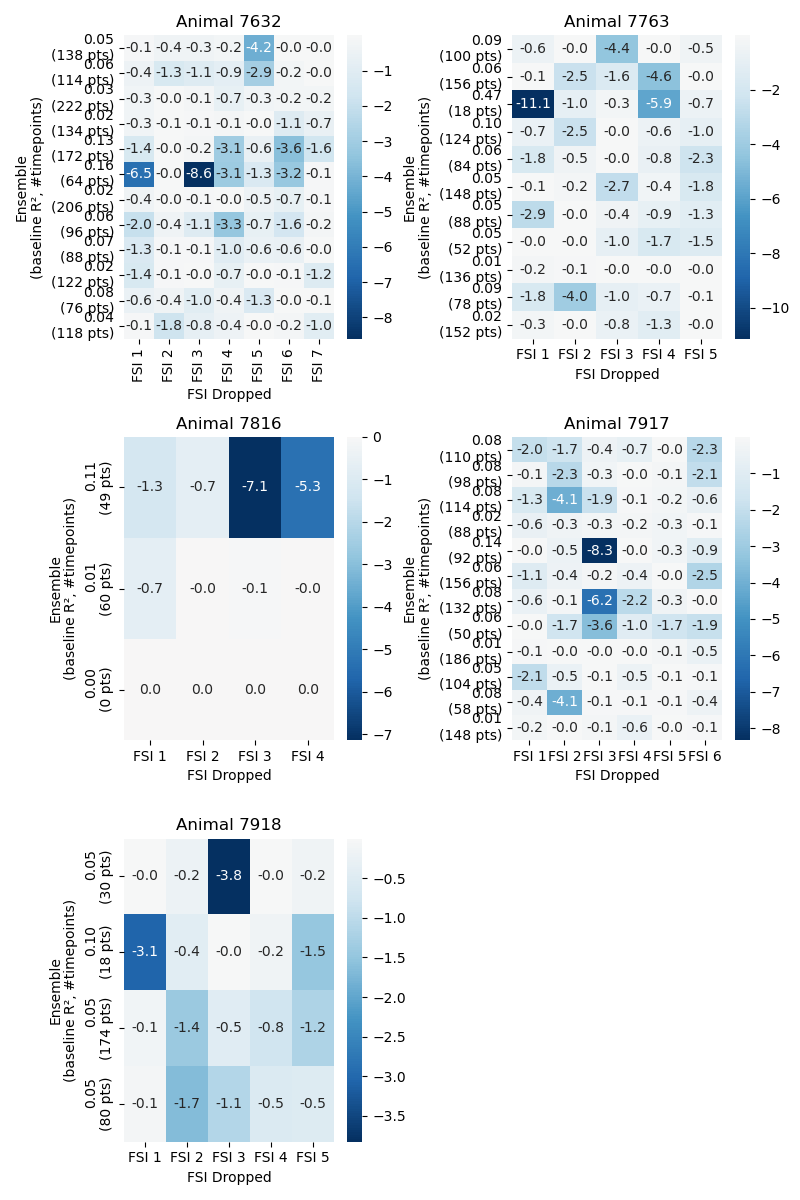

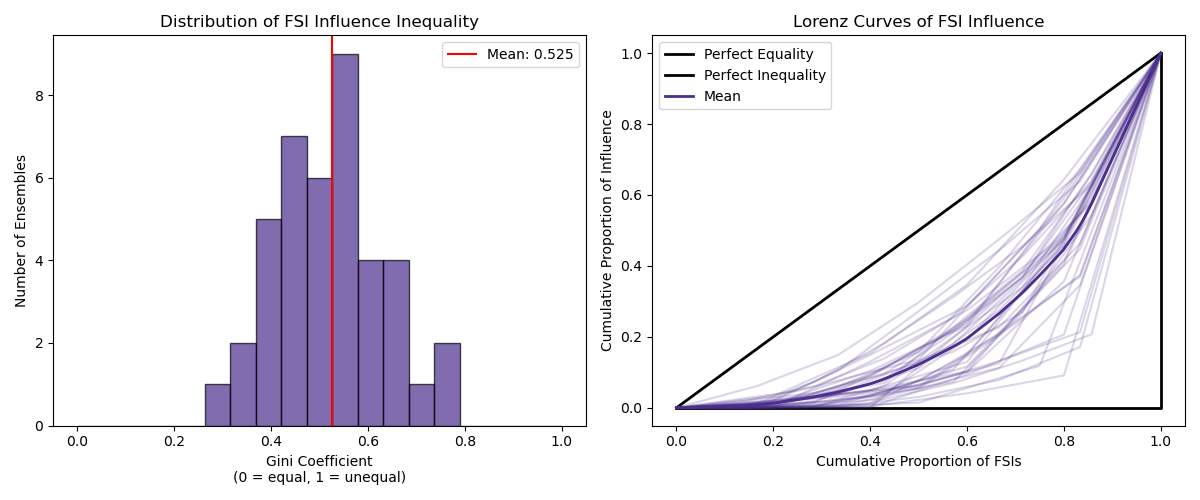


Gini Coefficient Summary:
Number of ensembles: 41
Mean ± SEM: 0.525 ± 0.018

Distribution Summary:
Very equal (<0.25): 0.0%
Moderately equal (0.25-0.5): 41.5%
Moderately unequal (0.5-0.75): 58.5%
Very unequal (>0.75): 0.0%


In [42]:
results = analyze_fsi_ensemble_relationships(
    rate_data, 
    assemblies_data_day2, 
    day='day2',
    z_score_thresh=2.5,
    consecutive_bins=2,
    min_fsis=3,
    pre_burst_bins=1, 
    post_burst_bins=1
)

plot_fsi_ensemble_relationships(results, save_dir=figDataSaveDir + '/ephys_supp')
#print_ensemble_summary(results)

plot_gini_analysis(results, save_dir=figDataSaveDir + '/ephys')
